In [1]:
!pip install copent

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from copent import transent

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.gaussian_process import GaussianProcessRegressor

import tensorflow as tf
import keras.layers as layers

import torch
from torch import nn, optim

from itertools import product
import pickle as pkl
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
strategy = tf.distribute.MirroredStrategy()

## Import data and preprocessing

In [4]:
data = pd.read_csv('/kaggle/input/world-stock/stock.csv')
data.rename({'Unnamed: 0': 'Date'}, axis=1, inplace=True)
data.head()

Date  Price_AAPL  Price_AMZN   Price_BA  Price_DIS  Price_GOOGL  \
0  2004-08-19    2.193571   38.630001  50.250000  22.097601    50.220219   
1  2004-08-20    2.200000   39.509998  50.459999  22.137060    54.209209   
2  2004-08-21    2.200000   39.509998  50.459999  22.137060    54.209209   
3  2004-08-22    2.200000   39.509998  50.459999  22.137060    54.209209   
4  2004-08-23    2.220000   39.450001  50.650002  21.870705    54.754753   

   Price_INTC  Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
0   22.010000   27.120001    9.20625    3.886667     11.1625  
1   21.620001   27.200001    9.28250    4.116667     11.2600  
2   21.620001   27.200001    9.28250    4.116667     11.2600  
3   21.620001   27.200001    9.28250    4.116667     11.2600  
4   21.889999   27.240000    9.24250    4.206666     11.2475

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5705 entries, 0 to 5704
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5705 non-null   object 
 1   Price_AAPL   5705 non-null   float64
 2   Price_AMZN   5705 non-null   float64
 3   Price_BA     5705 non-null   float64
 4   Price_DIS    5705 non-null   float64
 5   Price_GOOGL  5705 non-null   float64
 6   Price_INTC   5705 non-null   float64
 7   Price_MSFT   5705 non-null   float64
 8   Price_NKE    5705 non-null   float64
 9   Price_NVDA   5705 non-null   float64
 10  Price_SBUX   5705 non-null   float64
dtypes: float64(10), object(1)
memory usage: 490.4+ KB


In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.head()

Date  Price_AAPL  Price_AMZN   Price_BA  Price_DIS  Price_GOOGL  \
0 2004-08-19    2.193571   38.630001  50.250000  22.097601    50.220219   
1 2004-08-20    2.200000   39.509998  50.459999  22.137060    54.209209   
2 2004-08-21    2.200000   39.509998  50.459999  22.137060    54.209209   
3 2004-08-22    2.200000   39.509998  50.459999  22.137060    54.209209   
4 2004-08-23    2.220000   39.450001  50.650002  21.870705    54.754753   

   Price_INTC  Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
0   22.010000   27.120001    9.20625    3.886667     11.1625  
1   21.620001   27.200001    9.28250    4.116667     11.2600  
2   21.620001   27.200001    9.28250    4.116667     11.2600  
3   21.620001   27.200001    9.28250    4.116667     11.2600  
4   21.889999   27.240000    9.24250    4.206666     11.2475

In [7]:
data.describe()

Date   Price_AAPL   Price_AMZN     Price_BA  \
count                 5705  5705.000000  5705.000000  5705.000000   
mean   2012-06-10 00:00:00    80.268048   483.661252   133.029341   
min    2004-08-19 00:00:00     2.193571    26.070000    29.360001   
25%    2008-07-15 00:00:00    19.624287    77.099998    68.849998   
50%    2012-06-10 00:00:00    64.121429   225.229996    89.529999   
75%    2016-05-06 00:00:00   116.949997   679.750000   144.440002   
max    2020-04-01 00:00:00   327.200012  2170.219971   440.619995   
std                    NaN    69.658238   578.706657    98.829057   

         Price_DIS  Price_GOOGL   Price_INTC   Price_MSFT    Price_NKE  \
count  5705.000000  5705.000000  5705.000000  5705.000000  5705.000000   
mean     64.084173   509.208047    29.010631    47.812812    35.616663   
min      15.590000    50.055054    12.080000    15.150000     9.206250   
25%      31.459484   238.433426    21.170000    26.870001    14.285000   
50%      46.240002   328.828827    24.820000    30.610001    24.497499   
75%     100.970001   758.479980    34.669998    54.189999    54.939999   
max     151.639999  1524.869995    68.470001   188.699997   104.580002   
std      37.489668   357.247775    11.062003    34.099912    24.986873   

        Price_NVDA   Price_SBUX  
count  5705.000000  5705.000000  
mean     54.938924    33.344510  
min       3.886667     3.585000  
25%      13.150000    13.485000  
50%      18.780001    25.264999  
75%      37.770000    55.119999  
max     314.700012    99.110001  
std      74.086555    23.190949

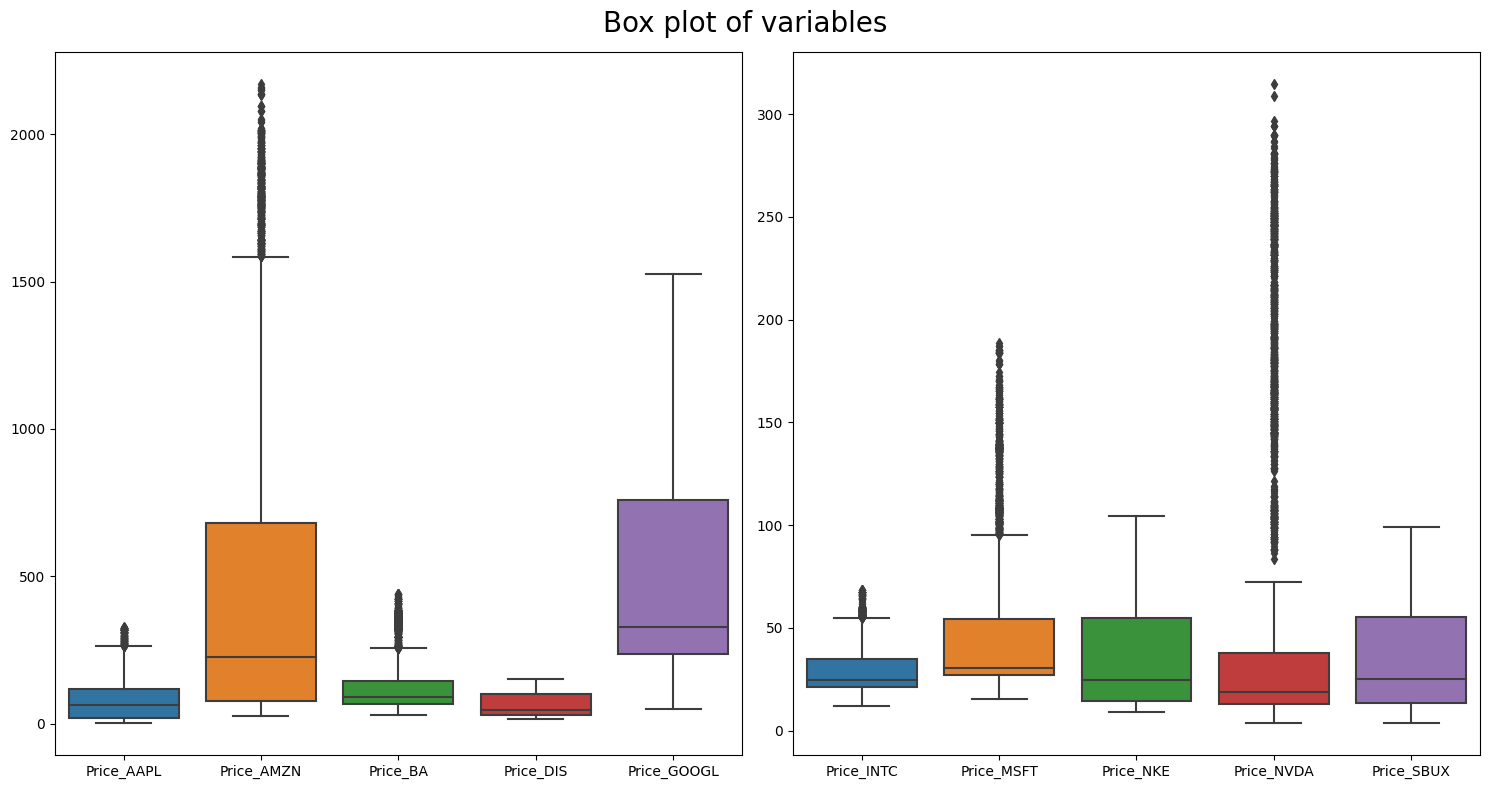

In [8]:
plt.figure(figsize=(15, 8))
plt.suptitle('Box plot of variables', fontsize=20)

plt.subplot(1, 2, 1)
sns.boxplot(data[['Price_AAPL', 'Price_AMZN', 'Price_BA', 'Price_DIS', 'Price_GOOGL']])

plt.subplot(1, 2, 2)
sns.boxplot(data[['Price_INTC', 'Price_MSFT', 'Price_NKE', 'Price_NVDA', 'Price_SBUX']])

plt.tight_layout()
plt.show()

## Data Visualization

In [9]:
def plot_ts(data, label):
    sns.lineplot(data=data, x='Date', y=label)
    plt.title(label)
    plt.ylabel('')
    plt.xlabel('')
    
    plt.xticks(
        ticks=pd.date_range(start='2004-05-01', end='2020-05-01', freq='YS'),
        labels=[str(year) for year in range(2004, 2020)],
        rotation=45
    )

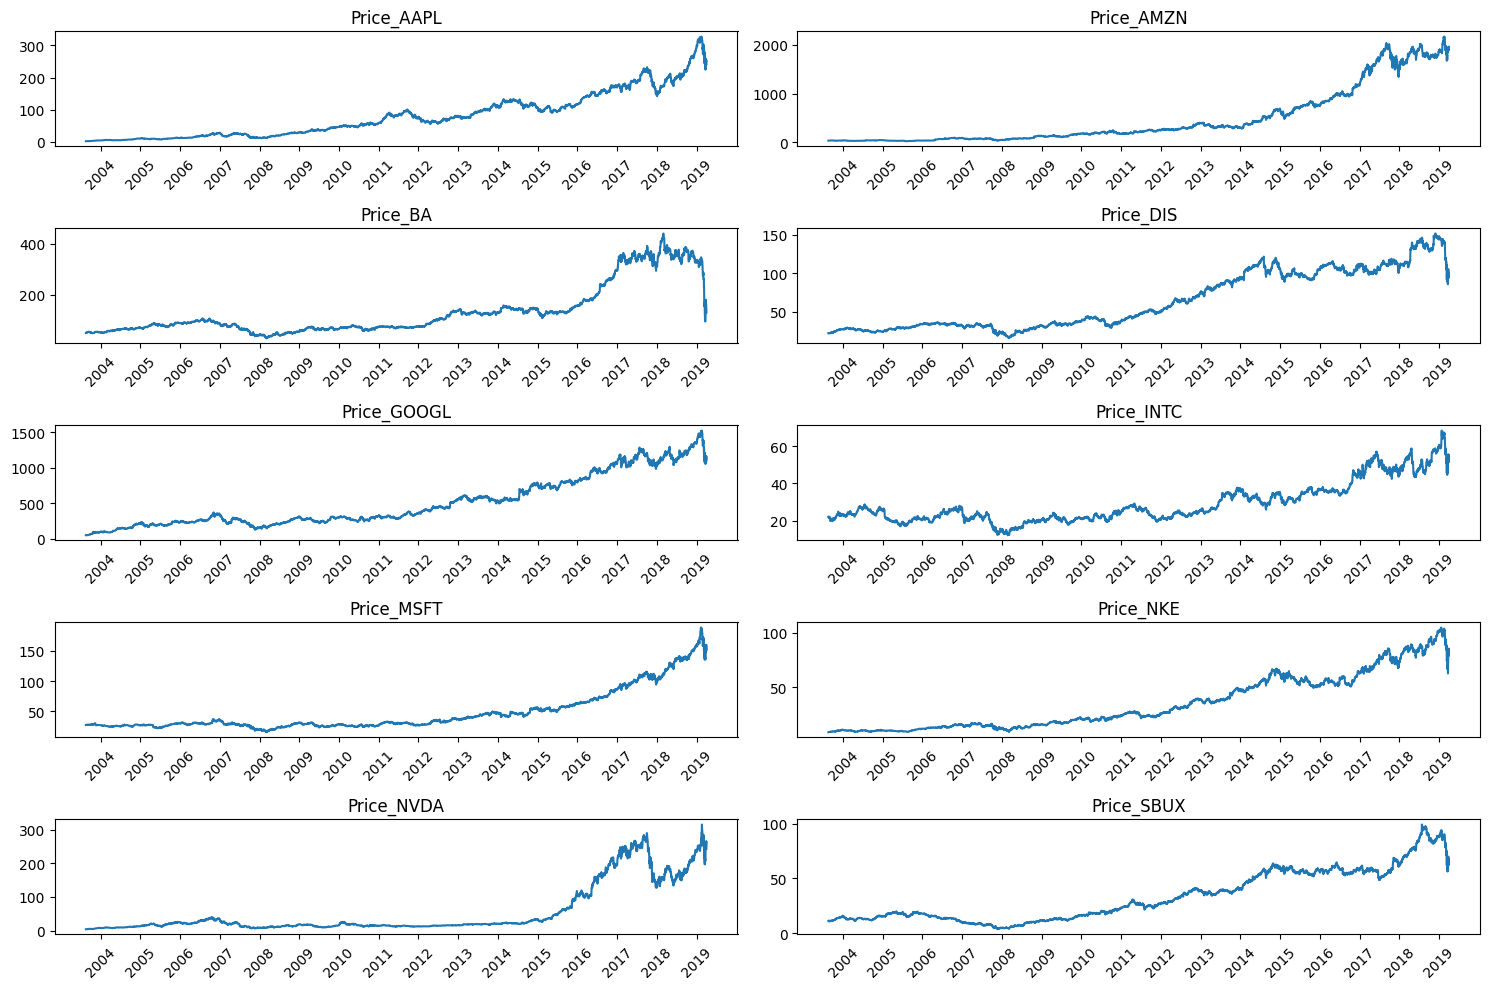

In [10]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(data.columns[1:]):
    plt.subplot(5, 2, i + 1)
    plot_ts(data, col)

plt.tight_layout()
plt.show()

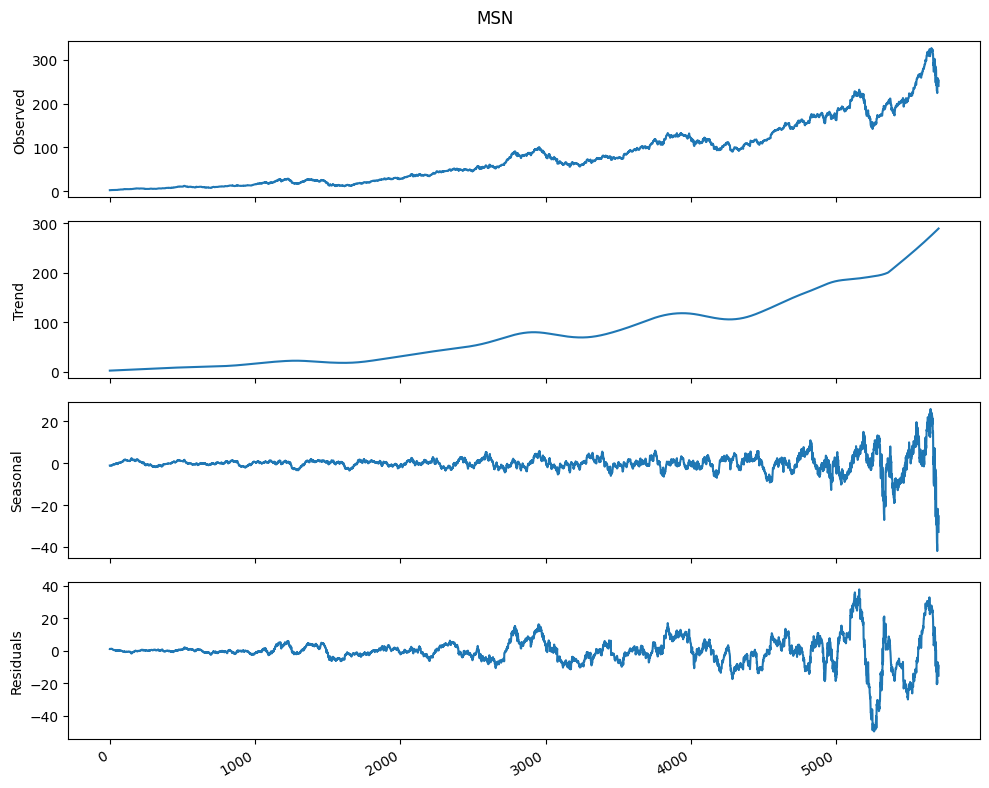

In [11]:
decomposition = STL(data['Price_AAPL'], period=365).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.suptitle('MSN')
plt.tight_layout()

## Split & Scale Data

In [ ]:
len(data[data['Date'] < '2019-01-01'])

5248

In [ ]:
train_df = data[:5248].drop(columns=['Date']).reset_index(drop=True)
test_df = data[5248:].drop(columns=['Date']). reset_index(drop=True)

In [ ]:
scalers = {}
scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_train = train_df
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    s_s = scaler.fit_transform(scaled_train[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_' + i] = scaler
    scaled_train[i] = s_s
    
scaled_test = test_df
for i in test_df.columns:
    s_s = scaler.fit_transform(scaled_test[i].values.reshape(-1, 1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_' + i] = scaler
    scaled_test[i] = s_s

## SARIMAX

In [14]:
target = scaled_train['Price_AAPL']
exog = scaled_train.drop(columns=['Price_AAPL'])

In [15]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.09614322684543486
p-value: 0.9657967856763771


In [16]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -11.386486474273708
p-value: 8.26581292470254e-21


### Find the optimize hyperparameters

In [17]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    i = 0
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        i += 1
        print(i)
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [18]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 0
Q = range(0, 2, 1)
s = 365

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [ ]:
result_df = optimize_SARIMAX(target, exog, parameters_list, d, D, s)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(p,q,P,Q)           AIC
0  (1, 0, 0, 0) -19453.571142
1  (0, 1, 0, 0) -19453.568357
2  (1, 1, 0, 0) -19451.450331

In [20]:
def optimize_ARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [21]:
p = range(0, 7, 1)
d = 1
q = range(0, 7, 1)

parameters = product(p, q)
parameters_list = list(parameters)

In [22]:
result_df = optimize_ARIMAX(target, exog, parameters_list, d)
result_df

  0%|          | 0/49 [00:00<?, ?it/s]

(p,q)           AIC
0   (0, 0) -27930.824978
1   (1, 0) -27928.887547
2   (0, 1) -27928.885932
3   (2, 0) -27926.946589
4   (0, 2) -27926.945061
5   (1, 1) -27926.639077
6   (0, 3) -27924.956854
7   (3, 0) -27924.955842
8   (2, 1) -27924.868418
9   (1, 2) -27924.825545
10  (1, 3) -27923.570282
11  (5, 0) -27923.329944
12  (0, 5) -27923.310875
13  (4, 0) -27923.101477
14  (0, 4) -27923.078665
15  (3, 1) -27922.954795
16  (2, 2) -27922.825553
17  (6, 0) -27921.819483
18  (0, 6) -27921.801603
19  (5, 1) -27921.326237
20  (2, 3) -27921.195970
21  (4, 1) -27921.099468
22  (1, 4) -27920.952806
23  (1, 5) -27920.861660
24  (3, 2) -27920.825626
25  (2, 5) -27920.154738
26  (6, 1) -27919.817526
27  (6, 6) -27919.596745
28  (2, 4) -27919.569019
29  (3, 3) -27919.524543
30  (1, 6) -27919.386872
31  (4, 2) -27918.825662
32  (4, 6) -27918.695377
33  (4, 3) -27918.379790
34  (6, 5) -27918.372803
35  (6, 2) -27917.836010
36  (4, 5) -27917.614025
37  (5, 3) -27917.458718
38  (3, 5) -27917.351544
39  (5, 6) -27917.328416
40  (2, 6) -27917.296712
41  (3, 4) -27917.065089
42  (5, 2) -27916.825828
43  (5, 5) -27916.777636
44  (5, 4) -27915.146678
45  (4, 4) -27915.092461
46  (6, 4) -27913.849626
47  (3, 6) -27913.815365
48  (6, 3) -27912.827087

In [23]:
p = range(7, 14, 1)
d = 1
q = range(7, 14, 1)

parameters = product(p, q)
parameters_list = list(parameters)

In [24]:
result_df = optimize_ARIMAX(target, exog, parameters_list, d)
result_df

  0%|          | 0/49 [00:00<?, ?it/s]

(p,q)           AIC
0    (8, 12) -27943.308493
1   (12, 13) -27939.279488
2   (13, 13) -27938.112467
3    (7, 13) -27937.600432
4    (8, 13) -27936.784899
5    (7, 12) -27935.918923
6    (9, 12) -27934.873745
7    (9, 13) -27933.842540
8   (10, 12) -27933.064043
9   (10, 13) -27927.905821
10    (9, 7) -27907.637543
11    (7, 9) -27907.457536
12   (13, 7) -27906.858643
13    (7, 8) -27906.548731
14    (7, 7) -27906.332597
15    (8, 7) -27906.262716
16   (10, 7) -27905.999722
17    (9, 8) -27905.712883
18    (8, 9) -27905.454175
19   (9, 10) -27905.324450
20   (13, 8) -27904.611788
21    (8, 8) -27904.400547
22   (10, 8) -27904.018336
23   (11, 7) -27904.016717
24   (8, 10) -27903.738554
25    (9, 9) -27903.480139
26   (13, 9) -27902.698843
27   (12, 7) -27902.062064
28   (11, 8) -27902.055503
29   (10, 9) -27901.769346
30   (8, 11) -27901.764655
31  (13, 10) -27900.623313
32   (12, 8) -27900.091250
33  (10, 10) -27899.880297
34   (11, 9) -27899.790082
35   (9, 11) -27899.748426
36  (13, 11) -27898.717114
37   (12, 9) -27898.005341
38  (11, 10) -27897.823406
39  (10, 11) -27897.820345
40   (7, 10) -27896.829169
41  (13, 12) -27896.659204
42  (11, 11) -27895.901980
43  (12, 10) -27895.867461
44   (7, 11) -27894.829220
45  (12, 11) -27893.976557
46  (11, 12) -27893.913202
47  (12, 12) -27891.929686
48  (11, 13) -27889.965836

### Model training

In [25]:
start = time.time()
best_model = SARIMAX(target, exog, order=(8,1,12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
end = time.time()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Price_AAPL   No. Observations:                 4564
Model:              SARIMAX(8, 1, 12)   Log Likelihood               14001.654
Date:                Thu, 14 Nov 2024   AIC                         -27943.308
Time:                        07:32:25   BIC                         -27750.536
Sample:                             0   HQIC                        -27875.431
                               - 4564                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Price_AMZN      0.0664      0.012      5.714      0.000       0.044       0.089
Price_BA        0.0795      0.007     11.409      0.000       0.066       0.093
Price_DIS       0.0800      0.012      6.703    

In [26]:
print(end-start)

169.1941683292389


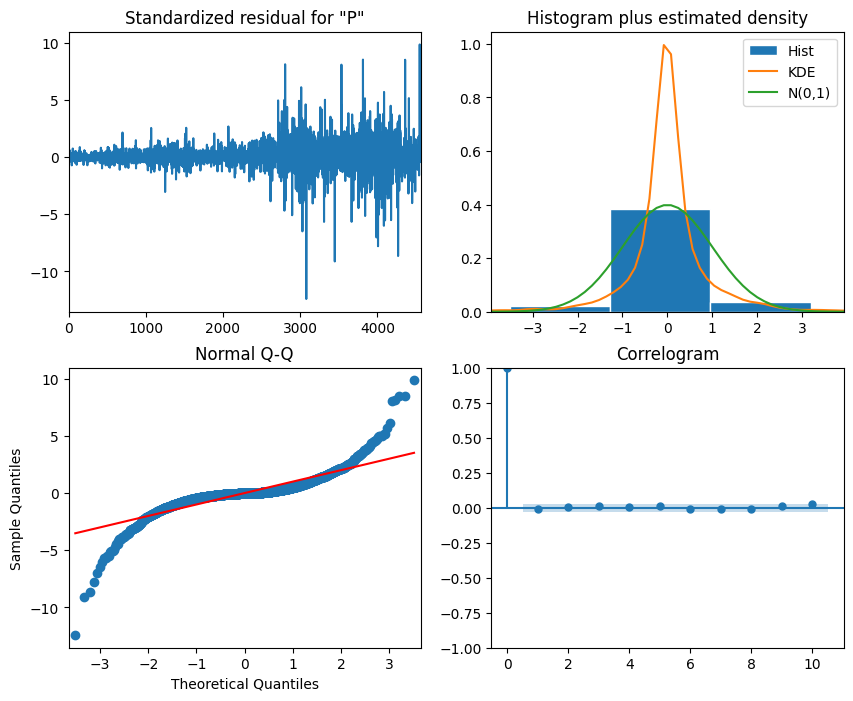

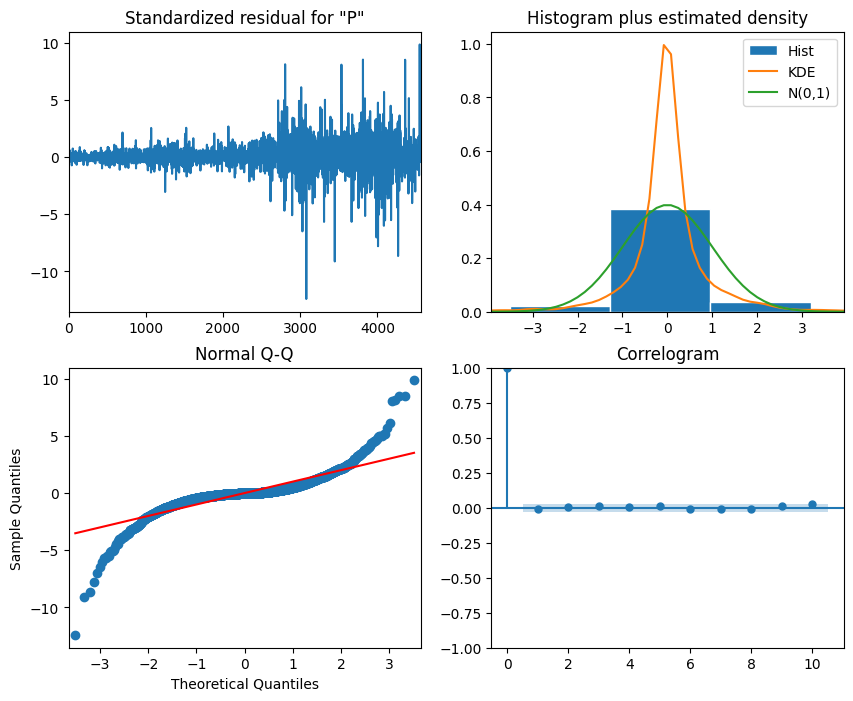

In [27]:
best_model_fit.plot_diagnostics(figsize=(10,8))

In [28]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(8,1,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [29]:
target_train = scaled_train['Price_AAPL']
target_test = scaled_test['Price_AAPL']

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 60

In [30]:
pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

In [31]:
pred_df['pred_last_value'] = pred_last_value[:HORIZON]
pred_df['pred_SARIMAX'] = pred_SARIMAX[:HORIZON]

pred_df.head()

actual  pred_last_value  pred_SARIMAX
0  0.997600              1.0      0.704437
1  1.003151              1.0      0.719818
2  1.003151              1.0      0.725733
3  1.003151              1.0      0.724232
4  1.003151              1.0      0.722526

### Model Evaluation
#### Scaled data

In [32]:
mse_last = mean_squared_error(pred_df.actual, pred_df.pred_last_value)
mse_SARIMAX = mean_squared_error(pred_df.actual, pred_df.pred_SARIMAX)

print(mse_last, mse_SARIMAX)

1.2040996876032897 1.6231458699401746


In [33]:
rmse_last = mean_squared_error(pred_df.actual, pred_df.pred_last_value, squared=False)
rmse_SARIMAX = mean_squared_error(pred_df.actual, pred_df.pred_SARIMAX, squared=False)

print(rmse_last, rmse_SARIMAX)

1.0973147623190393 1.2740274211884823


In [34]:
mae_last = mean_absolute_error(pred_df.actual, pred_df.pred_last_value)
mae_SARIMAX = mean_absolute_error(pred_df.actual, pred_df.pred_SARIMAX)

print(mae_last, mae_SARIMAX)

0.8741087523310508 1.0849979493132182


In [35]:
r2_last = r2_score(pred_df.actual, pred_df.pred_last_value)
r2_SARIMAX = r2_score(pred_df.actual, pred_df.pred_SARIMAX)

print(r2_last, r2_SARIMAX)

-1.736335648066048 -2.6886247473156


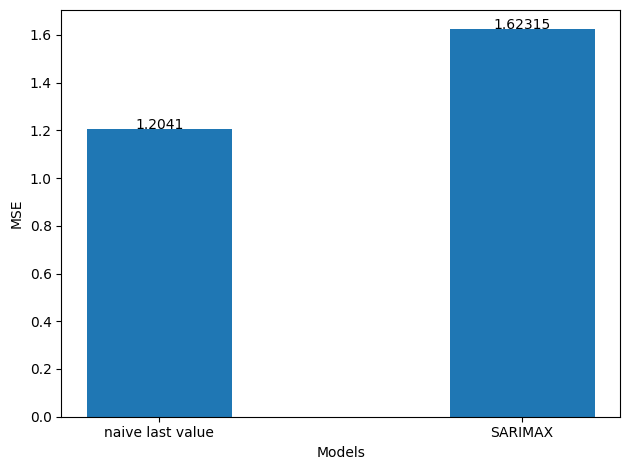

In [36]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mse_last, mse_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.0001, s=str(round(value,5)), ha='center')

plt.tight_layout()
plt.show()

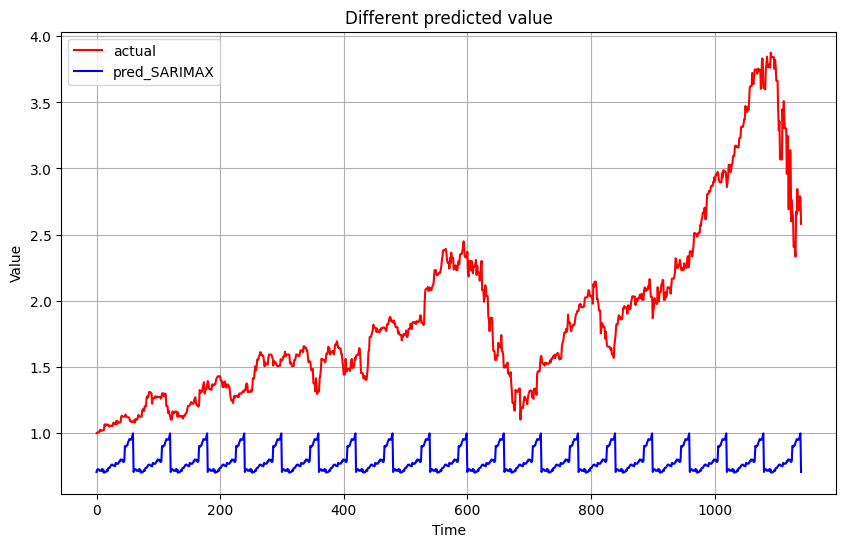

In [37]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=pred_df, x=pred_df.index, y='actual', label='actual', color='red')
sns.lineplot(data=pred_df, x=pred_df.index, y='pred_SARIMAX', label='pred_SARIMAX', color='blue')

plt.title('Different predicted value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### Unscaled data

In [38]:
unscaled_SARIMAX = scalers['scaler_Price_AAPL'].inverse_transform(np.array(pred_SARIMAX[:HORIZON]).reshape(-1,1))

In [ ]:
mse_SARIMAX = mean_squared_error(data.loc[5248:, 'Price_AAPL'].values, unscaled_SARIMAX)
rmse_SARIMAX = mean_squared_error(data.loc[5248:, 'Price_AAPL'].values, unscaled_SARIMAX, squared=False)
mae_SARIMAX = mean_absolute_error(data.loc[5248:, 'Price_AAPL'].values, unscaled_SARIMAX)
pred_df['real'] = data.loc[5248:, 'Price_AAPL'].values
pred_df['unscaled_SARIMAX'] = unscaled_SARIMAX
print(mse_SARIMAX, rmse_SARIMAX, mae_SARIMAX)

7212.1519169315425 84.92438941159095 72.32402287879921


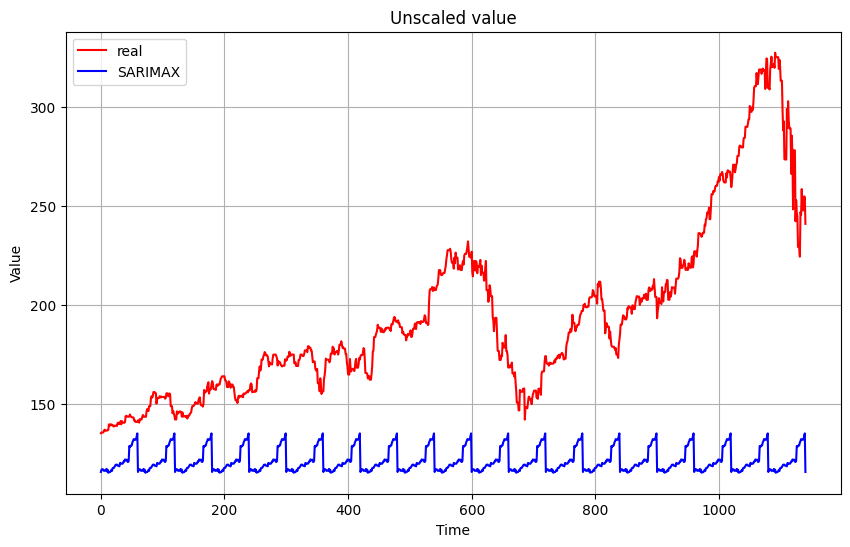

In [40]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=pred_df, x=pred_df.index, y='real', label='real', color='red')
sns.lineplot(data=pred_df, x=pred_df.index, y='unscaled_SARIMAX', label='SARIMAX', color='blue')

plt.title('Unscaled value')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Gaussian Process

In [41]:
statistic = []
p_value = []
for i in range(1, 11):
    ad_fuller_result = adfuller(data[data.columns[i]])
    statistic.append(ad_fuller_result[0])
    p_value.append(round(ad_fuller_result[1], 5))
    
ADF_res = pd.DataFrame({'Statistic': statistic, 'P-value': p_value}, index=data.columns[1:])
ADF_res

Statistic  P-value
Price_AAPL   -0.426044  0.90566
Price_AMZN    1.752502  0.99825
Price_BA     -1.474616  0.54603
Price_DIS    -1.051789  0.73391
Price_GOOGL  -0.565212  0.87865
Price_INTC   -0.820875  0.81291
Price_MSFT    2.917981  1.00000
Price_NKE    -0.215483  0.93665
Price_NVDA    0.402054  0.98157
Price_SBUX   -0.637134  0.86237

In [ ]:
diff_data = scaled_train.diff()
diff_data = diff_data.iloc[1:, :]

statistic = []
p_value = []
for i in range(10):
    ad_fuller_result = adfuller(diff_data[diff_data.columns[i]])
    statistic.append(ad_fuller_result[0])
    p_value.append(round(ad_fuller_result[1], 5))
    
ADF_res = pd.DataFrame({'Statistic': statistic, 'P-value': p_value}, index=diff_data.columns)
ADF_res

Statistic  P-value
Price_AAPL  -10.907818      0.0
Price_AMZN  -11.072580      0.0
Price_BA    -11.690744      0.0
Price_DIS   -16.128862      0.0
Price_GOOGL -23.031412      0.0
Price_INTC  -16.996233      0.0
Price_MSFT  -18.713874      0.0
Price_NKE   -12.941202      0.0
Price_NVDA   -9.385581      0.0
Price_SBUX  -73.052309      0.0

### Define model

In [43]:
train_Gaussian = diff_data
test_Gaussian = scaled_test

In [ ]:
X_train = train_Gaussian.index.values.reshape(-1, 1)
y_train = train_Gaussian.values

X_test = test_Gaussian.index.values.reshape(-1, 1)
y_test = test_Gaussian.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5247, 1) (5247, 10) (457, 1) (457, 10)


In [ ]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel as C

kernel = (C(7.07, (1e-1, 1e5)) * RBF(length_scale=3) + 
          C(2.12, (1e-1, 1e5)) * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=90) + 
          C(0.707, (1e-5, 1e1)) * RationalQuadratic(alpha=1, length_scale=3))

### Model training

In [46]:
start = time.time()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)
end = time.time()

In [ ]:
gp

GaussianProcessRegressor(kernel=2.66**2 * RBF(length_scale=3) + 1.46**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=90) + 0.841**2 * RationalQuadratic(alpha=1, length_scale=3),
                         n_restarts_optimizer=10)

In [ ]:
print(gp.score(X_train, y_train))
print(end-start)

0.9999999999995565
9302.479202985764


In [49]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(train_df.columns):
        scaler = scalers['scaler_' + i]
        temp[:, index] = scaler.inverse_transform(np.reshape(data[:, index], (-1, 1))).flatten()
    return temp

In [50]:
y_pred, sigma = gp.predict(X_test, return_std=True)
last_value = scaled_train.iloc[-1, :].values
y_pred = y_pred.cumsum(axis=0) + last_value

In [51]:
y_pred_unscale = unscale(y_pred)
sigma_unscale = unscale(sigma)

In [ ]:
pred_scaled_Gau = pd.DataFrame(data=y_pred, columns=data.drop(columns=['Date']).columns)
pred_scaled_Gau.index = pd.RangeIndex(5248,5248 + len(pred_scaled_Gau))
pred_scaled_Gau.head()

Price_AAPL  Price_AMZN  Price_BA  Price_DIS  Price_GOOGL  Price_INTC  \
5248    0.353483    0.465843  0.615260   0.773221     0.610785    0.548807   
5249    0.353539    0.466717  0.616418   0.773965     0.617243    0.531474   
5250    0.353539    0.466717  0.616418   0.773965     0.617243    0.531474   
5251    0.353539    0.466717  0.616418   0.773965     0.617243    0.531474   
5252    0.353713    0.466658  0.617465   0.768944     0.618126    0.543473   

      Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
5248    0.720317   0.701062   -0.091941    0.867413  
5249    0.721909   0.703060   -0.090330    0.870407  
5250    0.721909   0.703060   -0.090330    0.870407  
5251    0.721909   0.703060   -0.090330    0.870407  
5252    0.722706   0.702012   -0.089699    0.870023

In [ ]:
pred_Gau = pd.DataFrame(y_pred_unscale, columns=data.drop(columns=['Date']).columns)
pred_Gau.index = pd.RangeIndex(5248,5248 + len(pred_Gau))
pred_Gau.head()

Price_AAPL   Price_AMZN    Price_BA   Price_DIS  Price_GOOGL  \
5248  157.760549  1501.763588  322.481282  109.659398  1045.073215   
5249  157.766978  1502.643585  322.691281  109.698858  1049.062203   
5250  157.766978  1502.643584  322.691281  109.698858  1049.062203   
5251  157.766978  1502.643584  322.691281  109.698858  1049.062203   
5252  157.786978  1502.583587  322.881283  109.432502  1049.607747   

      Price_INTC  Price_MSFT  Price_NKE  Price_NVDA  Price_SBUX  
5248   46.928156  101.561505  74.138984  133.499957   64.401975  
5249   46.538157  101.641505  74.215234  133.729957   64.499474  
5250   46.538157  101.641505  74.215234  133.729957   64.499474  
5251   46.538157  101.641505  74.215234  133.729957   64.499474  
5252   46.808155  101.681504  74.175234  133.819956   64.486975

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(10):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(scaled_test, pred_scaled_Gau)}')

MSE for Price_AAPL: 0.4828011100134915
MSE for Price_AMZN: 0.11199142460336126
MSE for Price_BA: 0.11359060811149518
MSE for Price_DIS: 0.16809899747711016
MSE for Price_GOOGL: 0.06136283420001134
MSE for Price_INTC: 0.08687084759692584
MSE for Price_MSFT: 0.7007224898296028
MSE for Price_NKE: 0.15284804944033026
MSE for Price_NVDA: 0.20758272782288276
MSE for Price_SBUX: 0.30731025315831895
MSE total: 0.239317934225353


In [ ]:
for i in range(10):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(scaled_test, pred_scaled_Gau, squared=False)}')

RMSE for Price_AAPL: 0.6948389093980644
RMSE for Price_AMZN: 0.334651198419132
RMSE for Price_BA: 0.33703205798780506
RMSE for Price_DIS: 0.4099987774092871
RMSE for Price_GOOGL: 0.24771522803415083
RMSE for Price_INTC: 0.29473860893497794
RMSE for Price_MSFT: 0.8370916854381023
RMSE for Price_NKE: 0.39095786146377753
RMSE for Price_NVDA: 0.45561247549083067
RMSE for Price_SBUX: 0.5543557099537435
RMSE total: 0.45569925125298705


In [ ]:
for i in range(10):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(scaled_test, pred_scaled_Gau)}')

MAE for Price_AAPL: 0.5663150452398903
MAE for Price_AMZN: 0.3131886232629445
MAE for Price_BA: 0.23521459104160952
MAE for Price_DIS: 0.35149166166404894
MAE for Price_GOOGL: 0.20168424181224012
MAE for Price_INTC: 0.22273249023703437
MAE for Price_MSFT: 0.7287021911088908
MAE for Price_NKE: 0.34178819041751013
MAE for Price_NVDA: 0.3689495559778231
MAE for Price_SBUX: 0.47898907202019647
MAE total: 0.38090556627821887


In [ ]:
for i in range(10):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(scaled_test.iloc[:, i], pred_scaled_Gau.iloc[:, i])}')
    
print(f'R2 total: {r2_score(scaled_test, pred_scaled_Gau)}')

R2 for Price_AAPL: -1.7330468132289765
R2 for Price_AMZN: -6.9418402626362345
R2 for Price_BA: -0.2079595933109195
R2 for Price_DIS: -1.2160459451493209
R2 for Price_GOOGL: -0.7006036841878962
R2 for Price_INTC: -0.3074294033294023
R2 for Price_MSFT: -3.3832674700044816
R2 for Price_NKE: -2.722891523620409
R2 for Price_NVDA: -1.6657515565335377
R2 for Price_SBUX: -2.4312051332473748
R2 total: -2.131004138524854


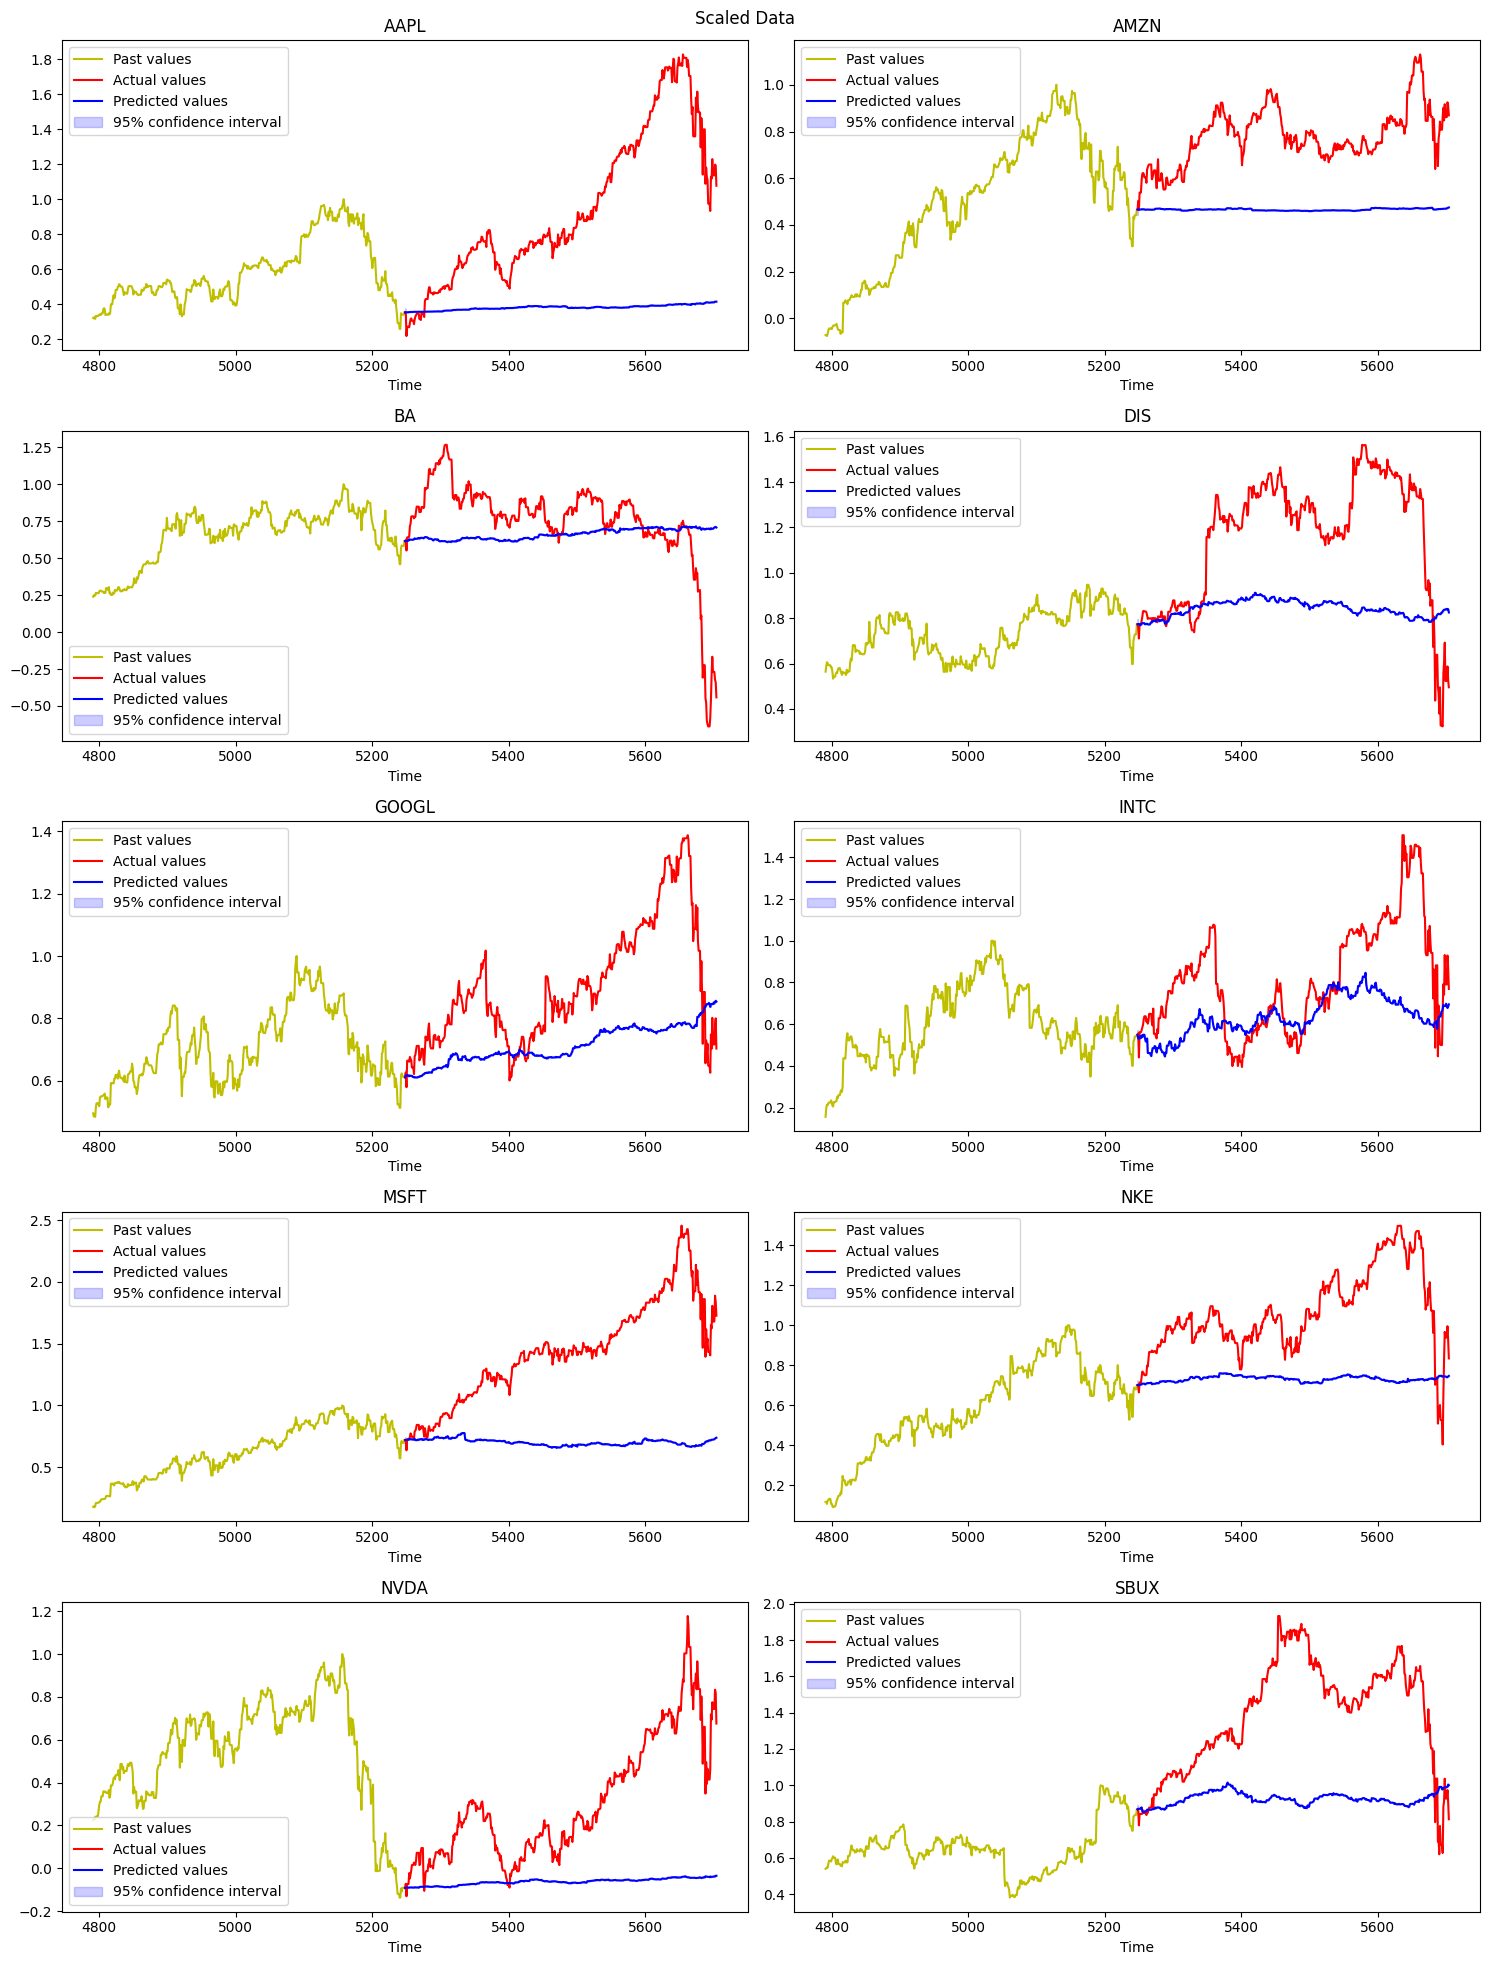

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(X_train[-len(pred_scaled_Gau):, :], scaled_train.iloc[-len(pred_scaled_Gau):, i], 'y-', markersize=10, label='Past values')
    plt.plot(pred_scaled_Gau.index, y_test[:, i], 'r-', markersize=10, label='Actual values')
    plt.plot(pred_scaled_Gau.index, pred_scaled_Gau.iloc[:, i], 'b-', label='Predicted values')
    plt.fill_between(pred_scaled_Gau.index, pred_scaled_Gau.iloc[:, i] - 1.96 * sigma[:, i], pred_scaled_Gau.iloc[:, i] + 1.96 * sigma[:, i], alpha=0.2, color='blue', label='95% confidence interval')
    plt.xlabel('Time')
    plt.title(f'{train_Gaussian.columns[i][6:]}')
    plt.legend()

plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
for i in range(10):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(test_df.iloc[:, i], pred_Gau.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(test_df, pred_Gau)}')

MSE for Price_AAPL: 6378.1859863348145
MSE for Price_AMZN: 113501.64783900167
MSE for Price_BA: 3740.693046361722
MSE for Price_DIS: 473.08144925821017
MSE for Price_GOOGL: 23414.894939900656
MSE for Price_INTC: 43.97837032403613
MSE for Price_MSFT: 1767.959944969223
MSE for Price_NKE: 222.713693016897
MSE for Price_NVDA: 4229.239411553525
MSE for Price_SBUX: 325.9461906519558
MSE total: 15409.834087137267


In [ ]:
for i in range(10):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(test_df.iloc[:, i], pred_Gau.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(test_df, pred_Gau, squared=False)}')

RMSE for Price_AAPL: 79.86354604157528
RMSE for Price_AMZN: 336.90005615761135
RMSE for Price_BA: 61.16120540311253
RMSE for Price_DIS: 21.750435610769046
RMSE for Price_GOOGL: 153.01926329681717
RMSE for Price_INTC: 6.631618982121646
RMSE for Price_MSFT: 42.047115774678566
RMSE for Price_NKE: 14.923595177332338
RMSE for Price_NVDA: 65.03260268168209
RMSE for Price_SBUX: 18.053979911696917
RMSE total: 79.93834190373968


In [ ]:
for i in range(10):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(test_df.iloc[:, i], pred_Gau.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(test_df, pred_Gau)}')

MAE for Price_AAPL: 65.09124212507544
MAE for Price_AMZN: 315.2932523883016
MAE for Price_BA: 42.684390328903156
MAE for Price_DIS: 18.646633053528078
MAE for Price_GOOGL: 124.58488864653665
MAE for Price_INTC: 5.011481242747529
MAE for Price_MSFT: 36.60271142077075
MAE for Price_NKE: 13.046696570025322
MAE for Price_NVDA: 52.66262706621536
MAE for Price_SBUX: 15.599476886233486
MAE total: 68.92233997283375


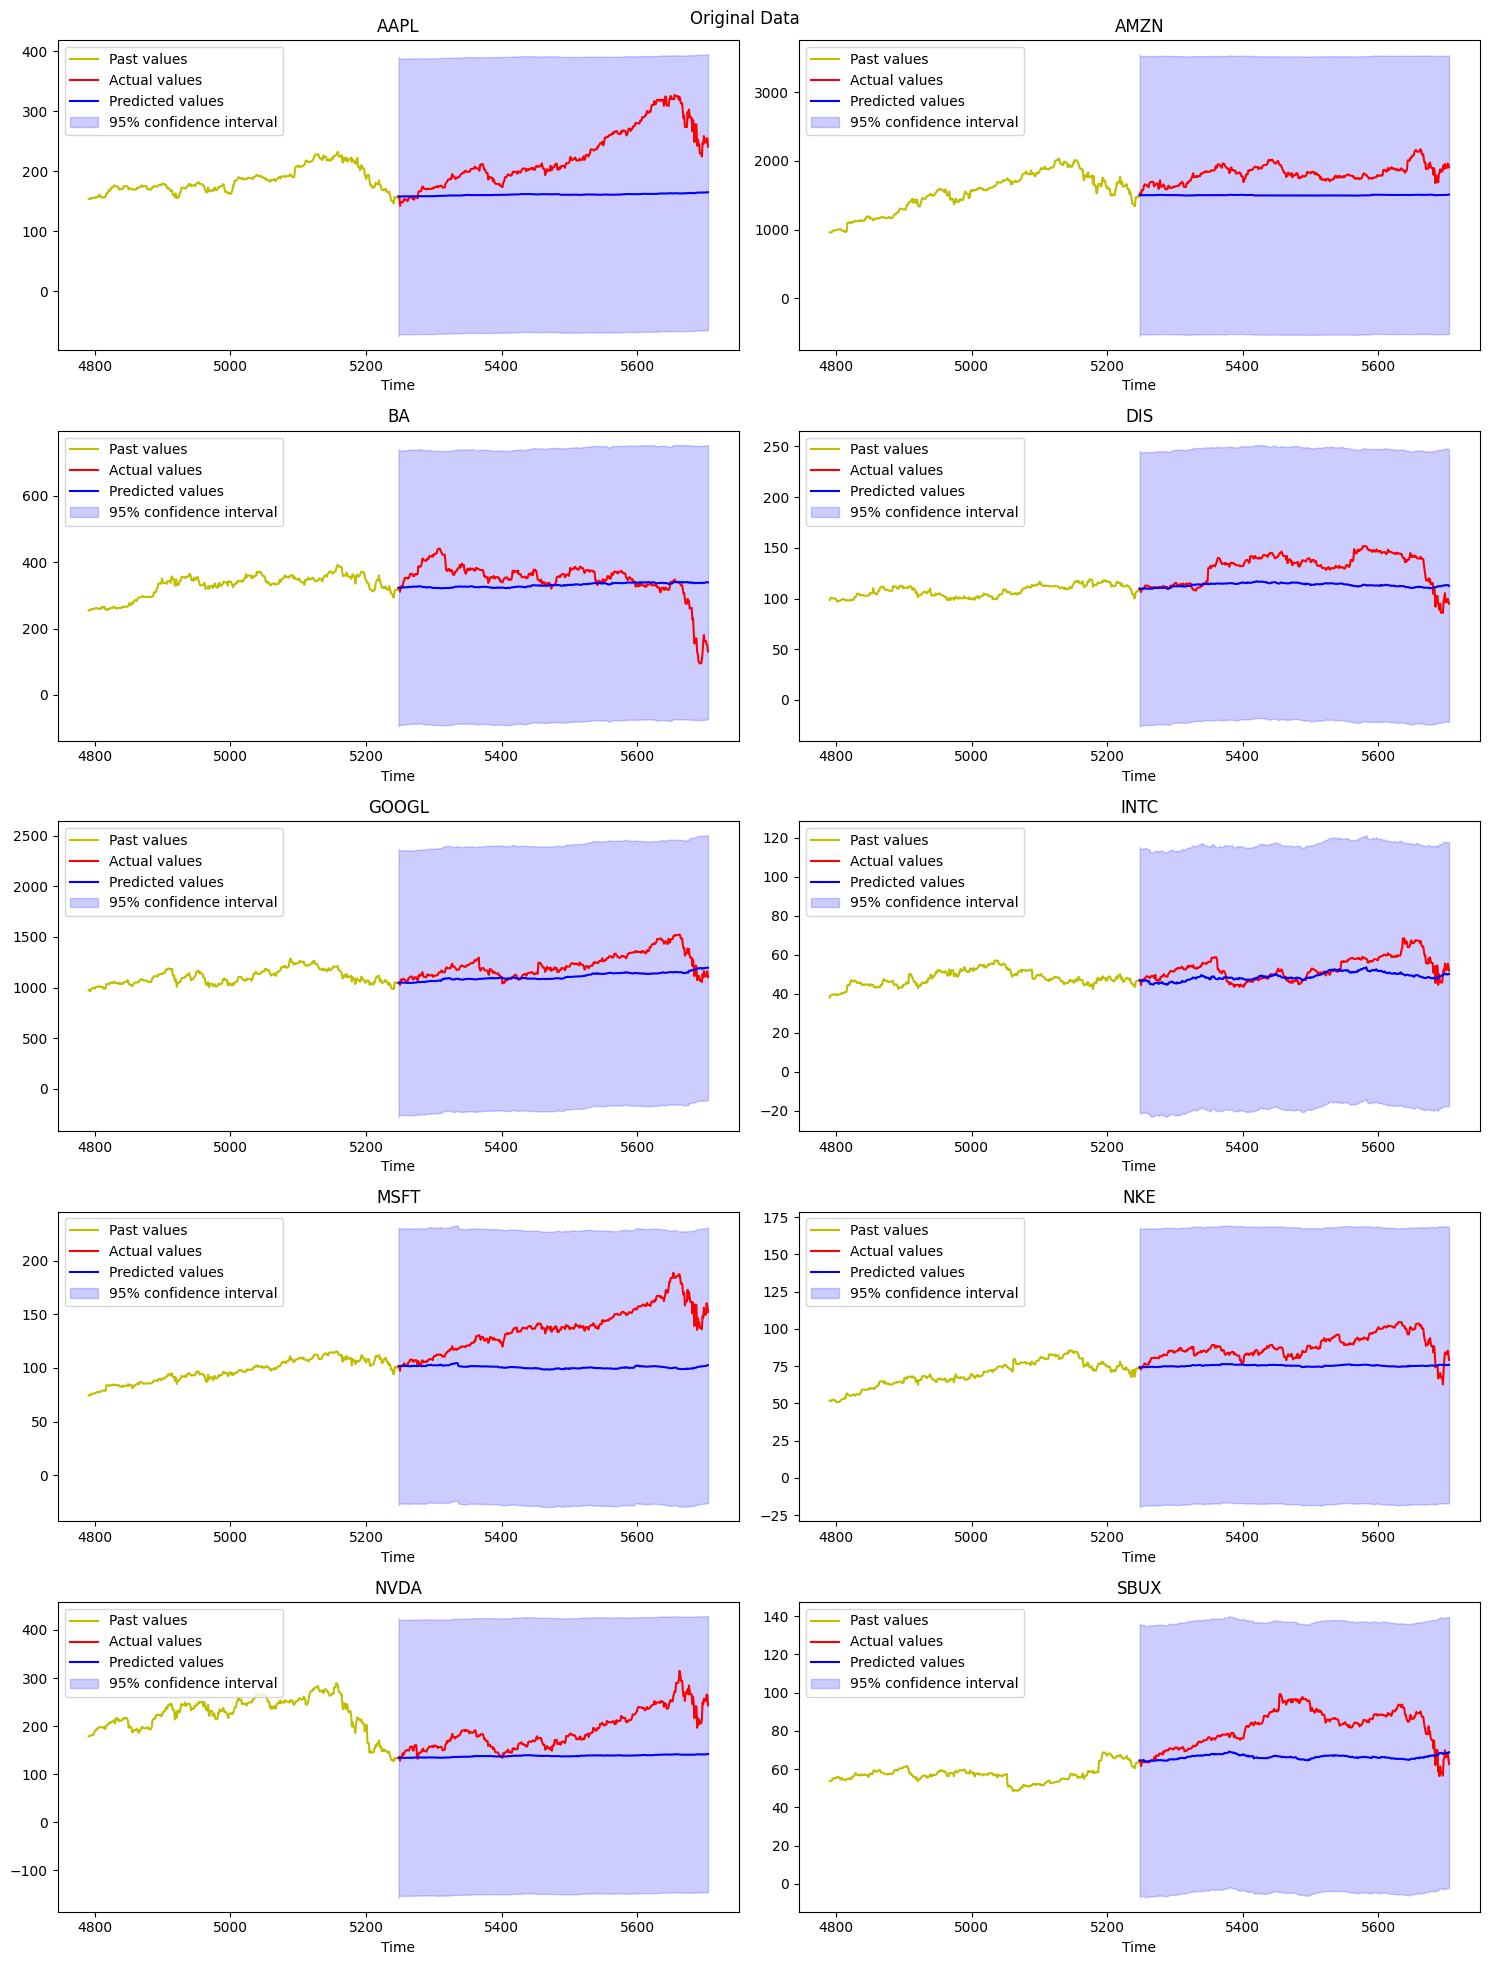

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(10):
    plt.subplot(5, 2, i + 1)
    plt.plot(X_train[-len(pred_Gau):, :], train_df.iloc[-len(pred_Gau):, i], 'y-', markersize=10, label='Past values')
    plt.plot(pred_Gau.index, test_df.iloc[:, i], 'r-', markersize=10, label='Actual values')
    plt.plot(pred_Gau.index, pred_Gau.iloc[:, i], 'b-', label='Predicted values')
    plt.fill_between(pred_Gau.index, pred_Gau.iloc[:, i] - 1.96 * sigma_unscale[:, i], pred_Gau.iloc[:, i] + 1.96 * sigma_unscale[:, i], alpha=0.2, color='blue', label='95% confidence interval')
    plt.xlabel('Time')
    plt.title(f'{train_Gaussian.columns[i][6:]}')
    plt.legend(loc='upper left')
 
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

## VAR
### Find the optimize hyperparameters

In [ ]:
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(1, 15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        print(results)
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
result_df = optimize_VAR(diff_data)
result_df

  0%|          | 0/1 [00:00<?, ?it/s]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          165     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20293D+01    |proj g|=  4.59993D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  165      3     39      2     0     0   1.330D-01  -3.203D+01
  F =  -32.029342480652517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


[[2, -335858.2762101097], [3, -335968.344847776], [4, -336104.8505978511], [5, -336248.0115256344], [6, -336330.30038219696], [7, -336562.9591011047], [8, -336579.2055910511], [9, -336631.8191163222], [10, -336658.1241173941], [11, -336653.4223165944], [12, -336716.2908896506], [13, -336783.1638928994], [14, -336989.0582531051], [1, -335785.9199919675]]


p            AIC
0   14 -336989.058253
1   13 -336783.163893
2   12 -336716.290890
3   10 -336658.124117
4   11 -336653.422317
5    9 -336631.819116
6    8 -336579.205591
7    7 -336562.959101
8    6 -336330.300382
9    5 -336248.011526
10   4 -336104.850598
11   3 -335968.344848
12   2 -335858.276210
13   1 -335785.919992

### Performing tests

In [ ]:
def granger_causality_matrix(data, max_lag):
    variables = data.columns
    df = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            test_result = grangercausalitytests(data[[var1, var2]], max_lag, verbose=False)
            p_values = [round(test[0]['ssr_ftest'][1], 4) for test in test_result.values()]
            min_p_value = np.min(p_values)
            df.loc[var1, var2] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
result = granger_causality_matrix(diff_data, 14)
result

Price_AAPL_x Price_AMZN_x Price_BA_x Price_DIS_x Price_GOOGL_x  \
Price_AAPL_y           1.0          0.0        0.0      0.0004           0.0   
Price_AMZN_y        0.0101          1.0        0.0      0.0001        0.0001   
Price_BA_y             0.0          0.0        1.0         0.0           0.0   
Price_DIS_y            0.0       0.0001     0.0864         1.0        0.0132   
Price_GOOGL_y       0.0005          0.0        0.0        0.16           1.0   
Price_INTC_y        0.2673       0.0003     0.0001      0.2365        0.1155   
Price_MSFT_y        0.1325       0.0052     0.0003      0.2285        0.0002   
Price_NKE_y            0.0          0.0        0.0      0.0005           0.0   
Price_NVDA_y           0.0          0.0        0.0      0.0234        0.0003   
Price_SBUX_y           0.0          0.0        0.0       0.001           0.0   

              Price_INTC_x Price_MSFT_x Price_NKE_x Price_NVDA_x Price_SBUX_x  
Price_AAPL_y           0.0          0.0      0.0061          0.0       0.0008  
Price_AMZN_y           0.0          0.0         0.0          0.0       0.0002  
Price_BA_y             0.0          0.0      0.0004          0.0       0.0157  
Price_DIS_y            0.0          0.0      0.0001          0.0       0.4426  
Price_GOOGL_y          0.0          0.0      0.0124          0.0       0.0003  
Price_INTC_y           1.0       0.0002      0.0011          0.0       0.0065  
Price_MSFT_y        0.0003          1.0         0.0          0.0       0.0003  
Price_NKE_y            0.0          0.0         1.0          0.0       0.0018  
Price_NVDA_y        0.0023          0.0      0.0022          1.0          0.0  
Price_SBUX_y        0.0006          0.0      0.0347       0.0002          1.0

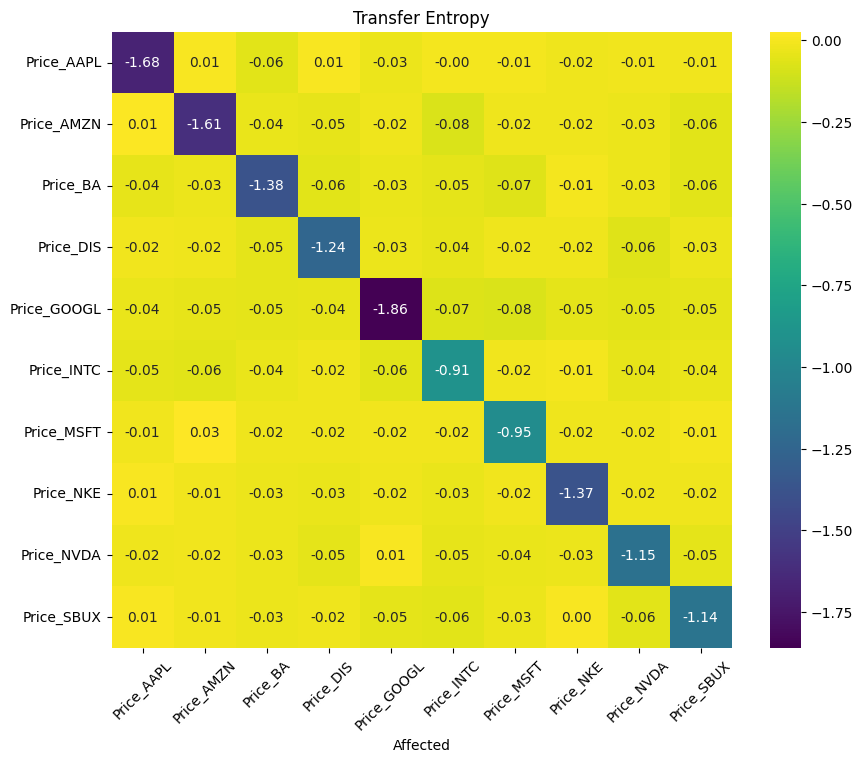

In [ ]:
transfer_entropy_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        transfer = transent(diff_data.iloc[:, i], diff_data.iloc[:, j], lag=14)
        transfer_entropy_matrix[i, j] = transfer

transfer_entropy_df = pd.DataFrame(transfer_entropy_matrix, 
                                   columns=[f'{diff_data.columns[i]}' for i in range(10)], 
                                   index=[f'{diff_data.columns[j]}' for j in range(10)])

plt.figure(figsize=(10, 8))
sns.heatmap(transfer_entropy_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Transfer Entropy')
plt.xlabel('Affected')
plt.xticks(rotation=45)
plt.show()

In [ ]:
VAR_train = scaled_train.drop(columns=['Price_INTC', 'Price_MSFT', 'Price_DIS'])
VAR_test = scaled_test.drop(columns=['Price_INTC', 'Price_MSFT', 'Price_DIS'])

diff_data = VAR_train.diff()
diff_data = diff_data.iloc[1:, :]

In [ ]:
granger_causality_matrix(diff_data, 14)

Price_AAPL_x Price_AMZN_x Price_BA_x Price_GOOGL_x Price_NKE_x  \
Price_AAPL_y           1.0          0.0        0.0           0.0      0.0061   
Price_AMZN_y        0.0101          1.0        0.0        0.0001         0.0   
Price_BA_y             0.0          0.0        1.0           0.0      0.0004   
Price_GOOGL_y       0.0005          0.0        0.0           1.0      0.0124   
Price_NKE_y            0.0          0.0        0.0           0.0         1.0   
Price_NVDA_y           0.0          0.0        0.0        0.0003      0.0022   
Price_SBUX_y           0.0          0.0        0.0           0.0      0.0347   

              Price_NVDA_x Price_SBUX_x  
Price_AAPL_y           0.0       0.0008  
Price_AMZN_y           0.0       0.0002  
Price_BA_y             0.0       0.0157  
Price_GOOGL_y          0.0       0.0003  
Price_NKE_y            0.0       0.0018  
Price_NVDA_y           1.0          0.0  
Price_SBUX_y        0.0002          1.0

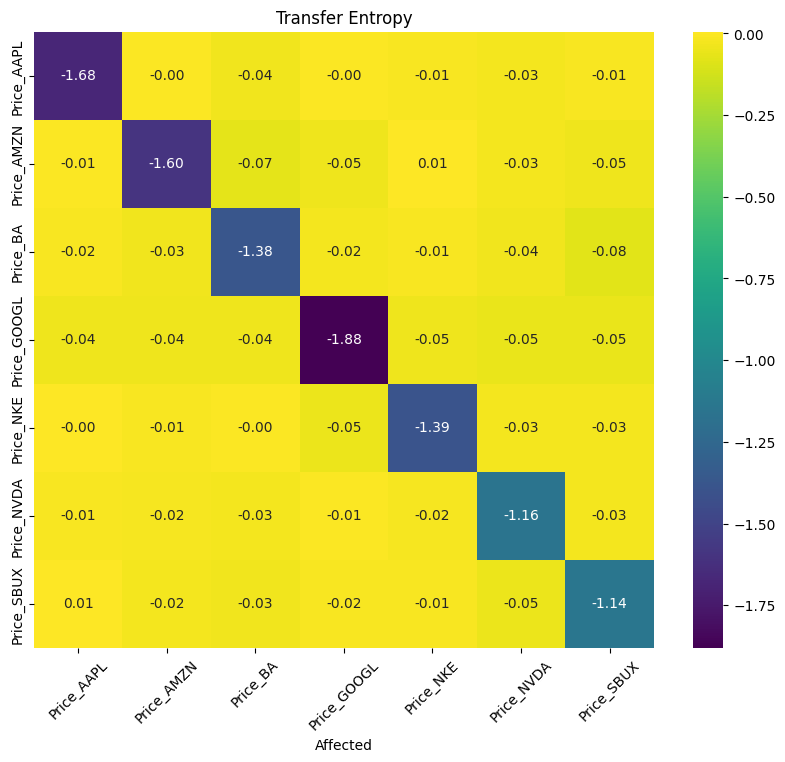

In [ ]:
transfer_entropy_matrix = np.zeros((7, 7))

for i in range(7):
    for j in range(7):
        transfer = transent(diff_data.iloc[:, i], diff_data.iloc[:, j], lag=14)
        transfer_entropy_matrix[i, j] = transfer

transfer_entropy_df = pd.DataFrame(transfer_entropy_matrix, 
                                   columns=[f'{diff_data.columns[i]}' for i in range(7)], 
                                   index=[f'{diff_data.columns[j]}' for j in range(7)])

plt.figure(figsize=(10, 8))
sns.heatmap(transfer_entropy_df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Transfer Entropy')
plt.xlabel('Affected')
plt.xticks(rotation=45)
plt.show()

### Model training

In [ ]:
start = time.time()
best_model = VARMAX(diff_data, order=(14,0))
best_model_fit = best_model.fit(disp=False)
end = time.time()
print(best_model_fit.summary())

                                                                  Statespace Model Results                                                                  
Dep. Variable:     ['Price_AAPL', 'Price_AMZN', 'Price_BA', 'Price_GOOGL', 'Price_NKE', 'Price_NVDA', 'Price_SBUX']   No. Observations:                 5247
Model:                                                                                                      VAR(14)   Log Likelihood              119874.690
                                                                                                        + intercept   AIC                        -238307.380
Date:                                                                                              Wed, 27 Nov 2024   BIC                        -233573.718
Time:                                                                                                      13:56:00   HQIC                       -236652.350
Sample:                                                   

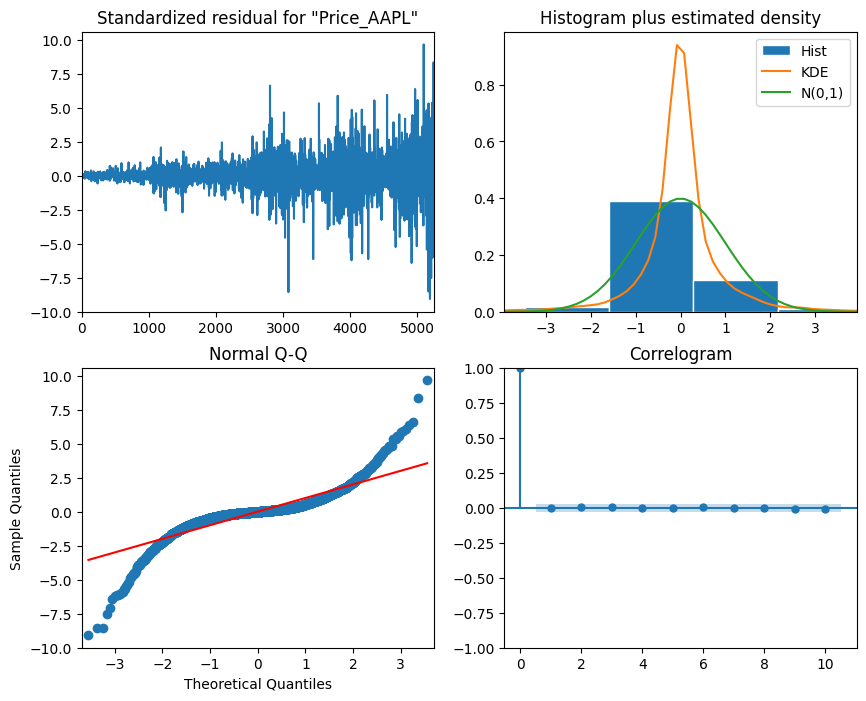

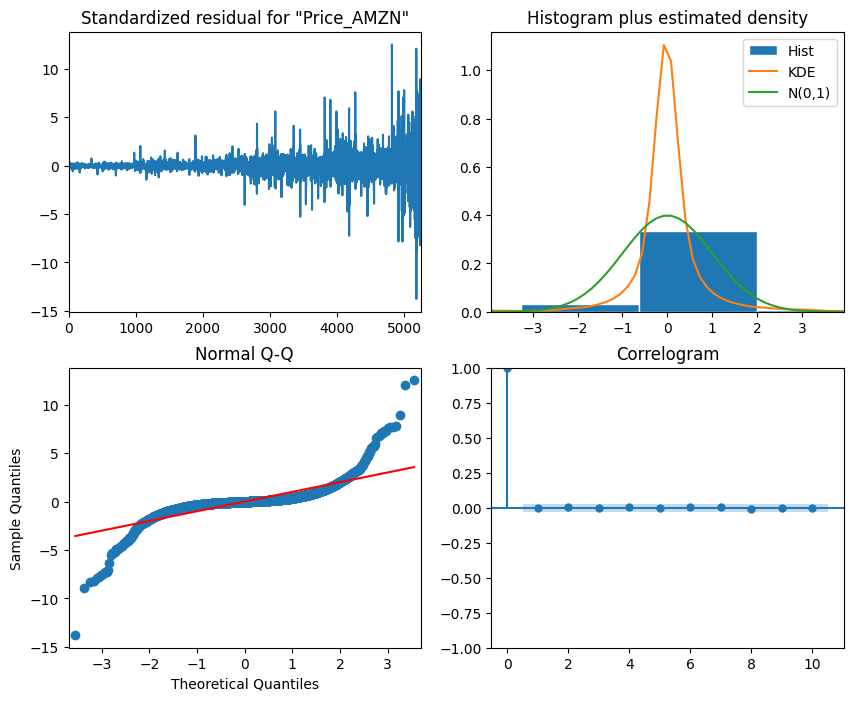

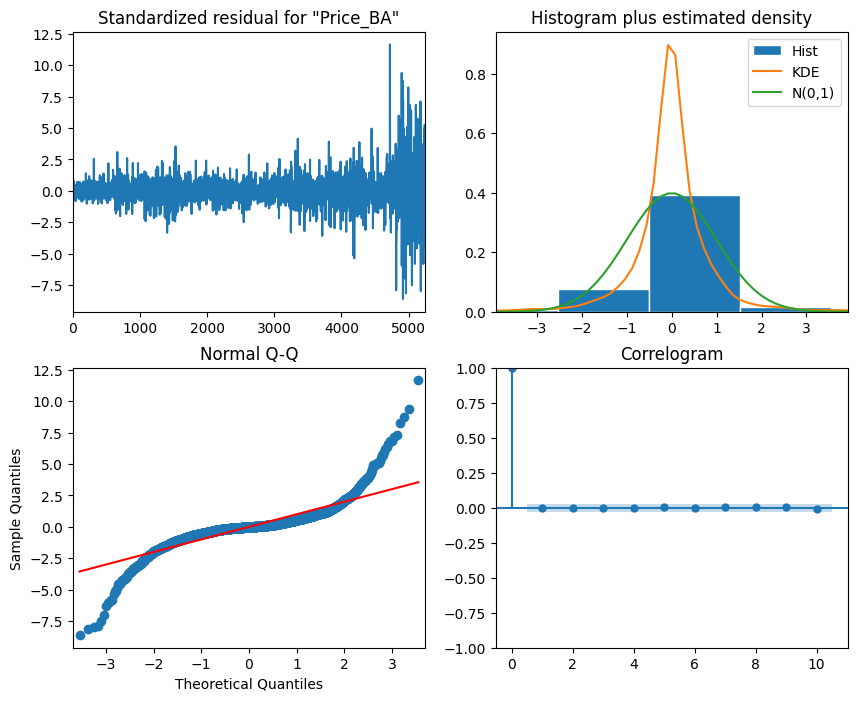

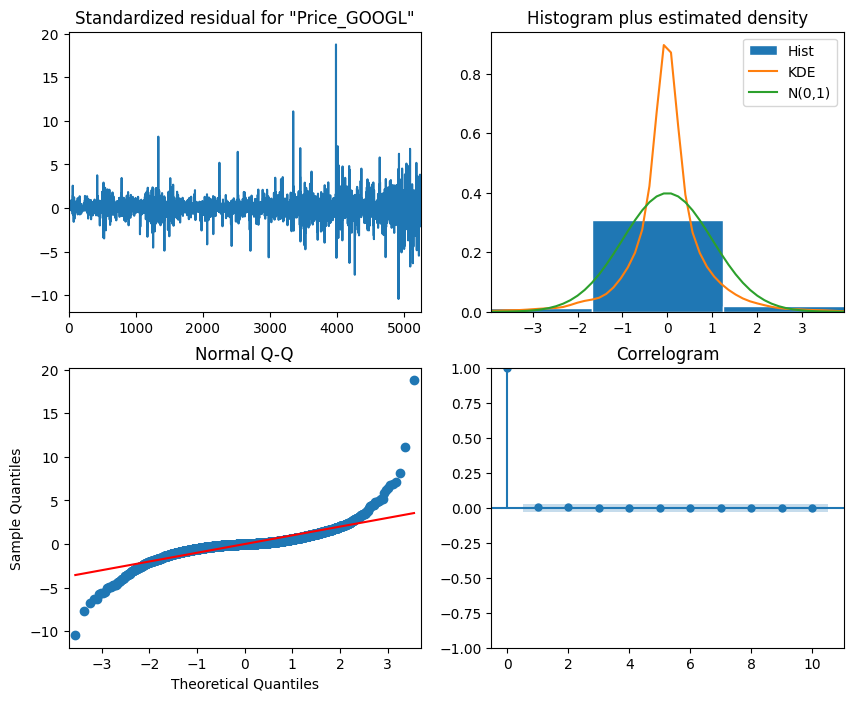

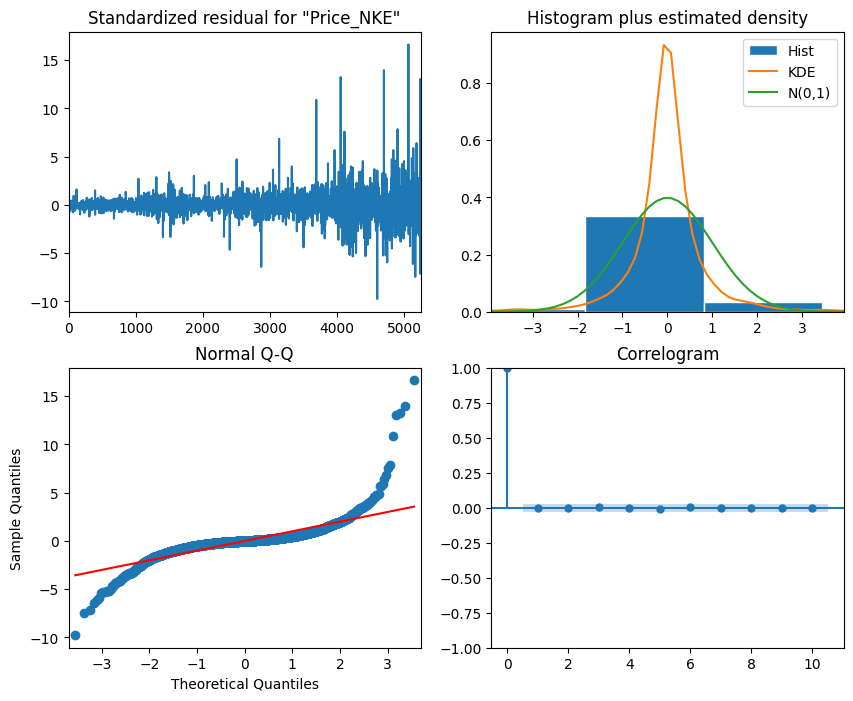

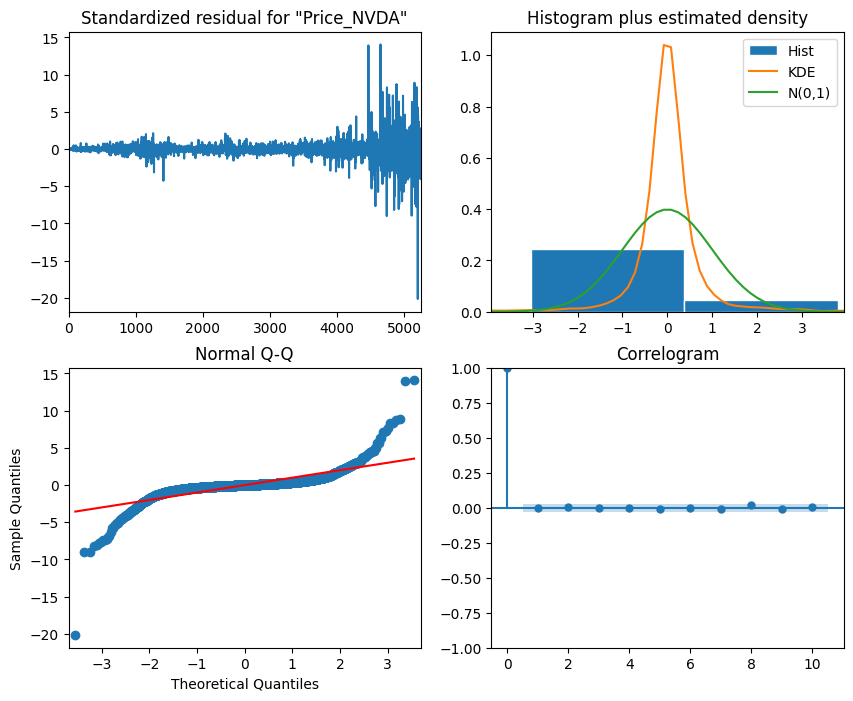

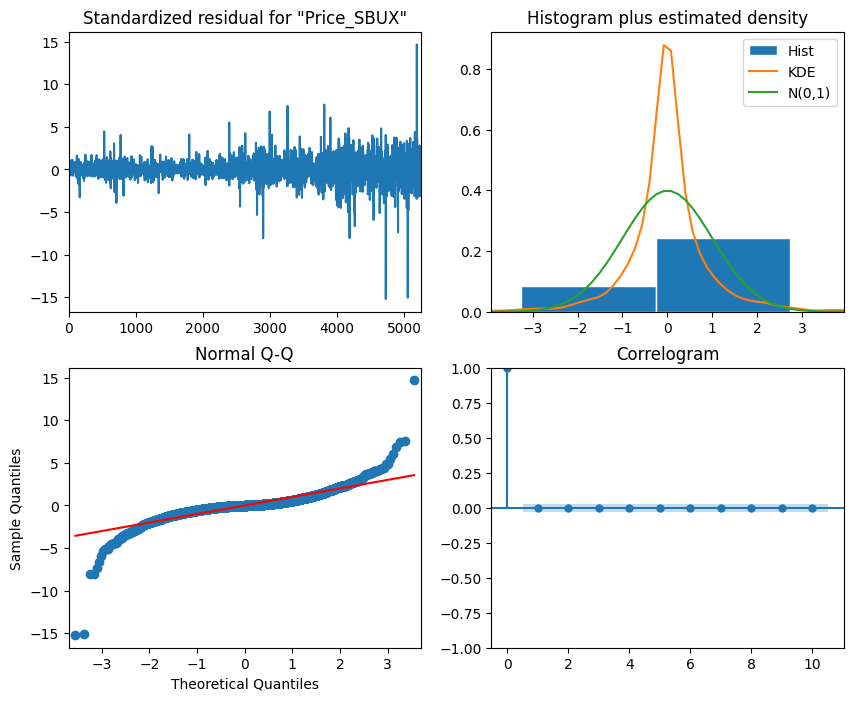

In [ ]:
for i in range(7):
    best_model_fit.plot_diagnostics(figsize=(10, 8), variable=i)

plt.show()

In [ ]:
print(end-start)

4975.649396181107


In [ ]:
TRAIN_LEN = len(diff_data)
HORIZON = len(scaled_test)
WINDOW = HORIZON

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int) -> pd.DataFrame:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    predictions_dict = {col: [] for col in df.columns}

    for i in range(train_len, total_len, window):
        model = VARMAX(df[:i], order=(14,0))
        res = model.fit(disp=False)
        predictions = res.get_prediction(0, i + window - 1)

        for col in df.columns:
            oos_pred = predictions.predicted_mean.iloc[-window:][col]
            predictions_dict[col].extend(oos_pred)

    predictions_df = pd.DataFrame(predictions_dict)
    return predictions_df

In [ ]:
pred_VAR = rolling_forecast(diff_data, TRAIN_LEN, HORIZON, WINDOW)
last_value = VAR_train.iloc[-1, :].values
pred_VAR = pred_VAR.cumsum(axis=0) + last_value

In [ ]:
pred_VAR.head()

Price_AAPL  Price_AMZN  Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0    0.362006    0.470233  0.619057     0.608029   0.688726   -0.084803   
1    0.374971    0.486030  0.641613     0.611740   0.687134   -0.075033   
2    0.360985    0.472641  0.633755     0.602487   0.680124   -0.088690   
3    0.366352    0.470999  0.638105     0.604638   0.691517   -0.090457   
4    0.367051    0.472674  0.635451     0.602519   0.693336   -0.087065   

   Price_SBUX  
0    0.867797  
1    0.869716  
2    0.870648  
3    0.869920  
4    0.865210

In [ ]:
VAR_test.head()

Price_AAPL  Price_AMZN  Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0    0.353305    0.466048  0.615363     0.610602   0.701089   -0.091941   
1    0.354871    0.502960  0.622582     0.626337   0.698993   -0.072885   
2    0.218015    0.464369  0.551441     0.579050   0.664675   -0.130543   
3    0.270826    0.538978  0.640602     0.664202   0.714449   -0.073095   
4    0.270826    0.538978  0.640602     0.664202   0.714449   -0.073095   

   Price_SBUX  
0    0.867352  
1    0.864896  
2    0.779228  
3    0.841867  
4    0.841867

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {VAR_test.columns[i]}: {mean_squared_error(VAR_test.iloc[:, i], pred_VAR.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(VAR_test, pred_VAR)}')

MSE for Price_AAPL: 0.4318493382842644
MSE for Price_AMZN: 0.07564527242864695
MSE for Price_BA: 0.11472285294544483
MSE for Price_GOOGL: 0.07917524505106446
MSE for Price_NKE: 0.13246557606131615
MSE for Price_NVDA: 0.1961230654032497
MSE for Price_SBUX: 0.300370386473322
MSE total: 0.19005024809247267


In [ ]:
for i in range(7):
    print(f'RMSE for {VAR_test.columns[i]}: {mean_squared_error(VAR_test.iloc[:, i], pred_VAR.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(VAR_test, pred_VAR, squared=False)}')

RMSE for Price_AAPL: 0.6571524467612249
RMSE for Price_AMZN: 0.27503685649135634
RMSE for Price_BA: 0.3387076216229048
RMSE for Price_GOOGL: 0.2813809607117448
RMSE for Price_NKE: 0.363958206476123
RMSE for Price_NVDA: 0.4428578388187904
RMSE for Price_SBUX: 0.5480605682525628
RMSE total: 0.41530778559067244


In [ ]:
for i in range(7):
    print(f'MAE for {VAR_test.columns[i]}: {mean_absolute_error(VAR_test.iloc[:, i], pred_VAR.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(VAR_test, pred_VAR)}')

MAE for Price_AAPL: 0.5339885421973752
MAE for Price_AMZN: 0.2541238011200103
MAE for Price_BA: 0.2304497723663873
MAE for Price_GOOGL: 0.23118840487206352
MAE for Price_NKE: 0.32676842297896996
MAE for Price_NVDA: 0.3578970661425766
MAE for Price_SBUX: 0.4838385270505836
MAE total: 0.34546493381828086


In [ ]:
for i in range(7):
    print(f'R2 for {VAR_test.columns[i]}: {r2_score(VAR_test.iloc[:, i], pred_VAR.iloc[:, i])}')
    
print(f'R2 total: {r2_score(VAR_test, pred_VAR)}')

R2 for Price_AAPL: -1.4446183600527958
R2 for Price_AMZN: -4.36436314101396
R2 for Price_BA: -0.22000025434694215
R2 for Price_GOOGL: -1.1942551250394309
R2 for Price_NKE: -2.226439408915645
R2 for Price_NVDA: -1.5185879979230594
R2 for Price_SBUX: -2.353719576065699
R2 total: -1.9031405519082187


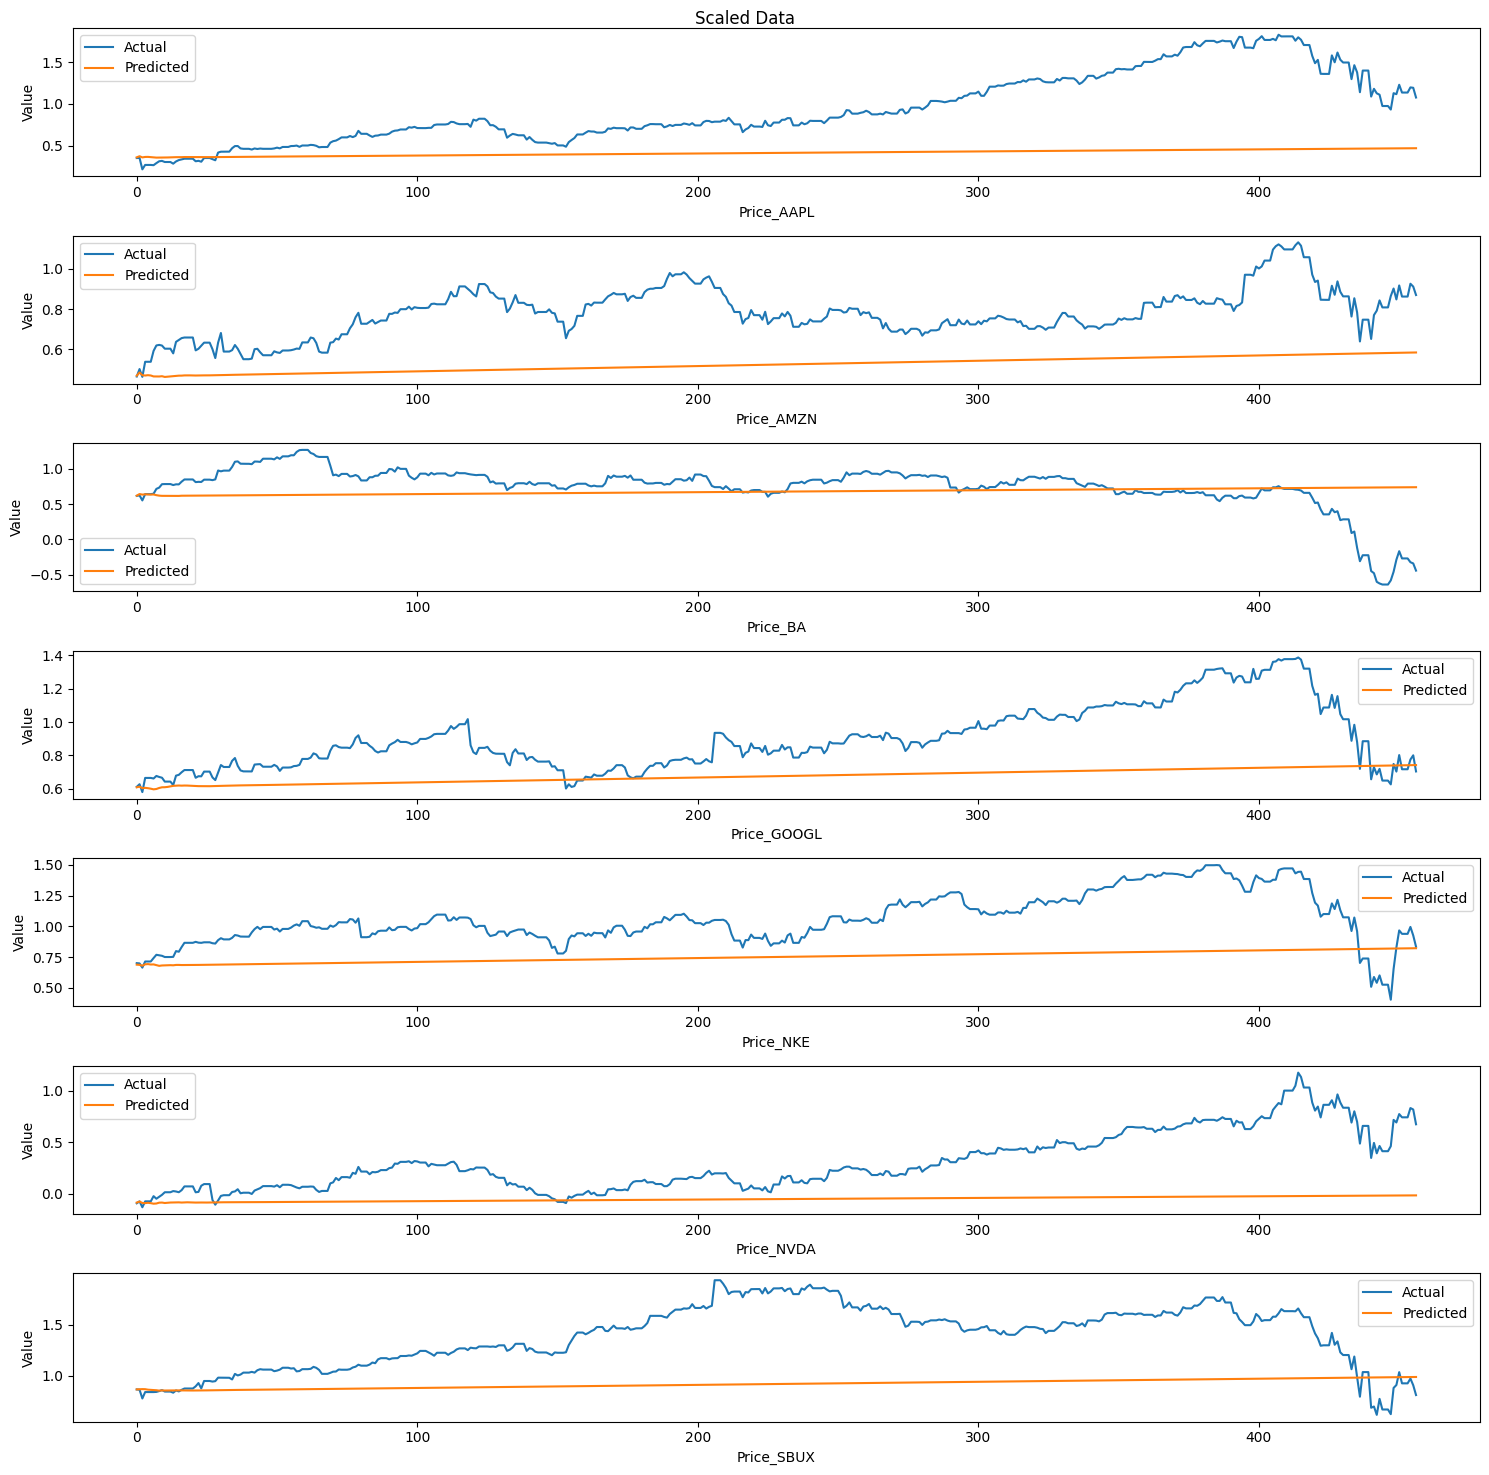

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(VAR_test.iloc[:, i], label='Actual')
    plt.plot(pred_VAR.iloc[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{VAR_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
def inverse(dataset):
    temp = dataset.copy()
    for index, i in enumerate(dataset.columns):
        scaler = scalers['scaler_' + i]
        temp.iloc[:, index] = scaler.inverse_transform(np.reshape(dataset.iloc[:, index], (-1, 1))).flatten()
    return temp

In [ ]:
inverse_VAR = inverse(pred_VAR)
inverse_VAR.head()

Price_AAPL   Price_AMZN    Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0  158.740066  1506.183128  323.170249  1043.370683  73.668108  134.518773   
1  160.230264  1522.086180  327.263431  1045.662804  73.607324  135.913370   
2  158.622736  1508.607142  325.837588  1039.947264  73.339750  133.963988   
3  159.239672  1506.953928  326.626901  1041.276005  73.774623  133.711769   
4  159.319942  1508.640765  326.145277  1039.966867  73.844064  134.195902   

   Price_SBUX  
0   64.414465  
1   64.476971  
2   64.507340  
3   64.483622  
4   64.330218

In [ ]:
temp_df = test_df.drop(columns=['Price_INTC', 'Price_MSFT', 'Price_DIS'])
temp_df.head()

Price_AAPL   Price_AMZN    Price_BA  Price_GOOGL  Price_NKE  Price_NVDA  \
0  157.740005  1501.969971  322.500000  1044.959961  74.139999  133.500000   
1  157.919998  1539.130005  323.809998  1054.680054  74.059998  136.220001   
2  142.190002  1500.280029  310.899994  1025.469971  72.750000  127.989998   
3  148.259995  1575.390015  327.079987  1078.069946  74.650002  136.190002   
4  148.259995  1575.390015  327.079987  1078.069946  74.650002  136.190002   

   Price_SBUX  
0   64.400002  
1   64.320000  
2   61.529999  
3   63.570000  
4   63.570000

In [ ]:
for i in range(7):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(temp_df.iloc[:, i], inverse_VAR.iloc[:, i])}')
    
print(f'MSE total: {mean_squared_error(temp_df, inverse_VAR)}')

MSE for Price_AAPL: 5705.072628303793
MSE for Price_AMZN: 76665.36167648625
MSE for Price_BA: 3777.9794069821105
MSE for Price_DIS: 30211.77344365917
MSE for Price_GOOGL: 193.01455105414033
MSE for Price_INTC: 3995.7630695836688
MSE for Price_MSFT: 318.58547591380545
MSE total: 17266.79289314042


In [ ]:
for i in range(7):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(temp_df.iloc[:, i], inverse_VAR.iloc[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(temp_df, inverse_VAR, squared=False)}')

RMSE for Price_AAPL: 75.53193118346566
RMSE for Price_AMZN: 276.885105551899
RMSE for Price_BA: 61.465269925235916
RMSE for Price_DIS: 173.81534294664314
RMSE for Price_GOOGL: 13.892967683477146
RMSE for Price_INTC: 63.212048452677664
RMSE for Price_MSFT: 17.848962880621535
RMSE total: 97.52166123200288


In [ ]:
for i in range(7):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(temp_df.iloc[:, i], inverse_VAR.iloc[:, i])}')
    
print(f'MAE total: {mean_absolute_error(temp_df, inverse_VAR)}')

MAE for Price_AAPL: 61.375691471276355
MAE for Price_AMZN: 255.83151434315184
MAE for Price_BA: 41.81971871444682
MAE for Price_DIS: 142.81027321991024
MAE for Price_GOOGL: 12.473363863346345
MAE for Price_INTC: 51.08503159031319
MAE for Price_MSFT: 15.757411515802994
MAE total: 83.02185781689255


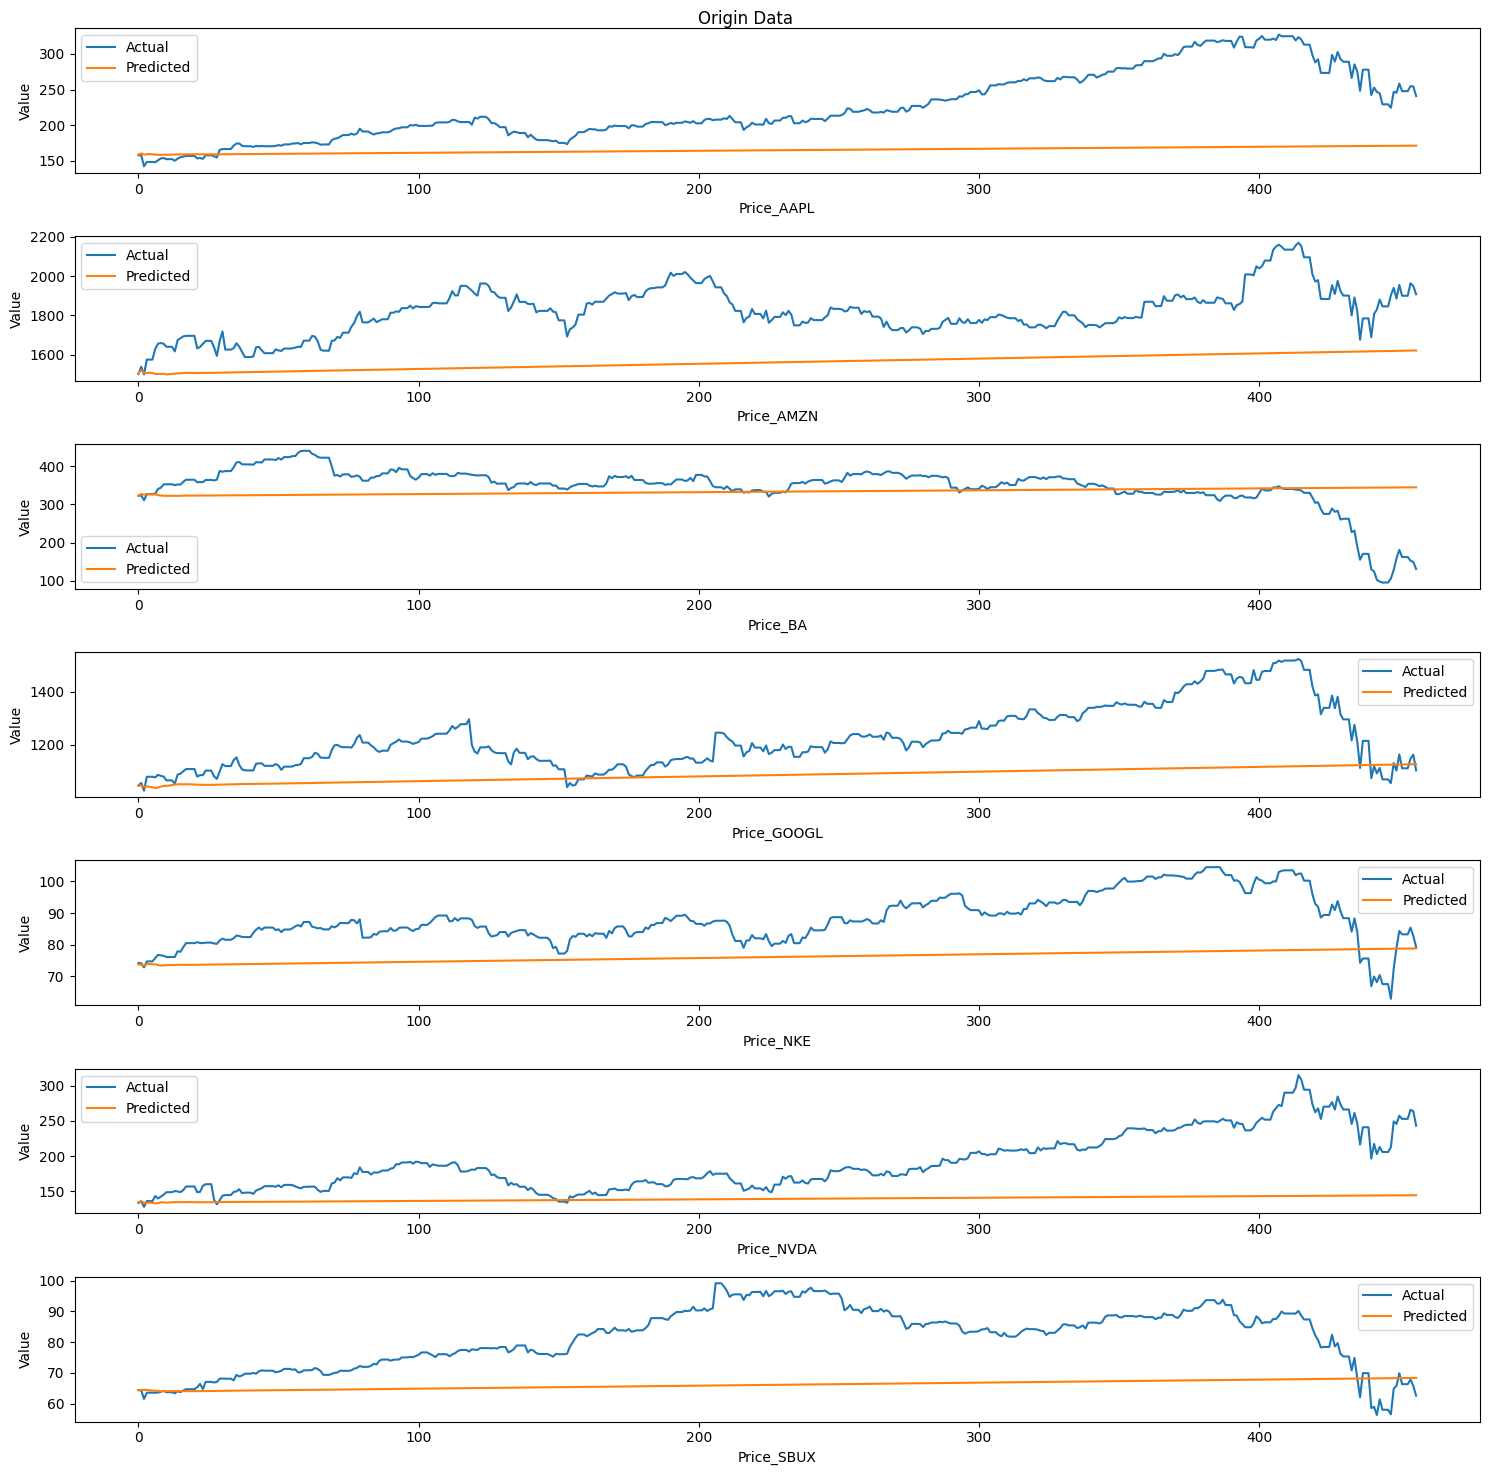

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(temp_df.iloc[:, i], label='Actual')
    plt.plot(inverse_VAR.iloc[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{temp_df.columns[i]}')
    plt.ylabel('Value')
    plt.legend()

plt.suptitle('Origin Data')
plt.tight_layout()
plt.show()

In [ ]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        
        if future_end > len(series):
            break
        
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [ ]:
n_past = 1
n_future = 1
n_features = 10

In [ ]:
trainX, trainY = split_series(scaled_train.values, n_past, n_future)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
trainY = trainY[:, 0, :].reshape((trainY.shape[0], n_features))

testX, testY = split_series(scaled_test.values, n_past, n_future)
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))
testY = testY[:, 0, :].reshape((testY.shape[0], n_features))

# CNN
### Find optimal parameters

In [ ]:
def build_cnn_model(filters, kernel_size, n_past, n_features):
    with strategy.scope():
        inputs = layers.Input(shape=(n_past, n_features), name='input_layer') # (batch_size, n_past, n_features)
        
        # Reshape input to (samples, n_past, n_features, 1) to work with Conv2D
        x = layers.Reshape((n_past, n_features, 1), name='reshape_layer')(inputs)
        
        # Lớp 1: Conv2D với kernel_size (7, n_features) và padding='same'
        conv1 = layers.Conv2D(
            filters=filters,  # Số lượng filter
            kernel_size=(kernel_size, n_features),  # Kích thước kernel (7, n_features)
            activation='relu',
            padding='same', 
            name='conv1_layer')(x) # (batch_size, n_past, n_features, filters)
        
        # Batch Normalization sau lớp Conv1
        conv1 = layers.BatchNormalization(name='conv1_bn')(conv1)
        
        # MaxPooling sau lớp Conv1 với pool_size (2, 2)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1)
        
        # Lớp 2: Conv2D với kernel_size (3, 3) và padding='same'
        conv2 = layers.Conv2D(
            filters=filters,  # Số lượng filter
            kernel_size=(3, 3),  # Kích thước kernel (3, 3)
            activation='relu',
            padding='same', 
            name='conv2_layer')(pool1)
        
        # Batch Normalization sau lớp Conv2
        conv2 = layers.BatchNormalization(name='conv2_bn')(conv2)
        
        # MaxPooling sau lớp Conv2 với pool_size (2, 2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2)
        
        # Flatten để đưa đầu ra vào lớp Dense
        flatten = layers.Flatten(name='flatten')(pool2)
        
        # Output layer: dự đoán cho mỗi đặc trưng (n_features)
        outputs = layers.Dense(n_features, name='output')(flatten)
        
        # Tạo và biên dịch mô hình
        model_CNN = tf.keras.models.Model(inputs, outputs)
        model_CNN.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model_CNN

In [ ]:
print('Starting find optimal parameters for CNN model')

# Tập giá trị tham số cần quét
param_grid = {
    'batch_size': [16, 32, 64],
    'filters': [16, 32, 64],
    'kernel_size': [5, 7, 10]
}

# Lưu kết quả
results = []
grid = ParameterGrid(param_grid)

# Lặp qua từng tổ hợp tham số
for params in grid:
    print(f"Testing with parameters: {params}")
    model = build_cnn_model(params['filters'], params['kernel_size'], n_past, n_features)
    
    # Huấn luyện mô hình
    history = model.fit(
        trainX, trainY,
        batch_size=params['batch_size'],
        epochs=5,
        verbose=0,
        validation_split=0.2
    )
    
    # Lưu kết quả
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    results.append({
        'batch_size': params['batch_size'],
        'filters': params['filters'],
        'kernel_size': params['kernel_size'],
        'loss': loss,
        'val_loss': val_loss
    })

# Sắp xếp kết quả theo val_loss
results = sorted(results, key=lambda x: x['val_loss'])

# Hiển thị kết quả tốt nhất
print("Best parameters:", results[0])
best_para_CNN = results[0]

### Model initialization

In [ ]:
class CNN:
    def __init__(self, n_past, n_features, best_para_CNN, strategy):
        self.n_past = n_past
        self.n_features = n_features
        self.best_para_CNN = best_para_CNN
        self.strategy = strategy

        # Xây dựng mô hình CNN
        with self.strategy.scope():
            self.model_CNN = self._build_model()

    def _build_model(filters, kernel_size, n_past, n_features):
        with strategy.scope():
            inputs = layers.Input(shape=(n_past, n_features), name='input_layer') # (batch_size, n_past, n_features)
            
            # Reshape input to (samples, n_past, n_features, 1) to work with Conv2D
            x = layers.Reshape((n_past, n_features, 1), name='reshape_layer')(inputs)
            
            # Lớp 1: Conv2D với kernel_size (7, n_features) và padding='same'
            conv1 = layers.Conv2D(
                filters=filters,  # Số lượng filter
                kernel_size=(kernel_size, n_features),  # Kích thước kernel (7, n_features)
                activation='relu',
                padding='same', 
                name='conv1_layer')(x) # (batch_size, n_past, n_features, filters)
            
            # Batch Normalization sau lớp Conv1
            conv1 = layers.BatchNormalization(name='conv1_bn')(conv1)
            
            # MaxPooling sau lớp Conv1 với pool_size (2, 2)
            pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1)
            
            # Lớp 2: Conv2D với kernel_size (3, 3) và padding='same'
            conv2 = layers.Conv2D(
                filters=filters,  # Số lượng filter
                kernel_size=(3, 3),  # Kích thước kernel (3, 3)
                activation='relu',
                padding='same', 
                name='conv2_layer')(pool1)
            
            # Batch Normalization sau lớp Conv2
            conv2 = layers.BatchNormalization(name='conv2_bn')(conv2)
            
            # MaxPooling sau lớp Conv2 với pool_size (2, 2)
            pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2)
            
            # Flatten để đưa đầu ra vào lớp Dense
            flatten = layers.Flatten(name='flatten')(pool2)
            
            # Output layer: dự đoán cho mỗi đặc trưng (n_features)
            outputs = layers.Dense(n_features, name='output')(flatten)
            
            # Tạo và biên dịch mô hình
            model_CNN = tf.keras.models.Model(inputs, outputs)
            model_CNN.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        return model_CNN

    def train(self, trainX, trainY):
        print('Start training CNN')

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        start = time.time()
        with self.strategy.scope():
            history_CNN = self.model_CNN.fit(
                trainX,
                trainY,
                validation_split=0.2,
                epochs=100,
                batch_size=self.best_para_CNN['batch_size'],
                verbose=0,
                callbacks=[reduce_lr, early_stop]
            )
        end = time.time()
        
        print('Complete training model')
        print(f'Training time: {end - start:.2f} seconds')
        return history_CNN

    def summary(self):
        self.model_CNN.summary()

    def plot_loss(self, history_CNN):
        loss = history_CNN.history['loss']
        val_loss = history_CNN.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'bo-', label='Training loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, testX):
        # Phương thức dự đoán
        return self.model_CNN.predict(testX)

In [ ]:
model_CNN = CNN(n_past, n_features, best_para_CNN, strategy)
model_CNN.summary()

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 14, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 14, 64)         │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_27     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,655 (14.28 KB)

 Trainable params: 3,655 (14.28 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
history_CNN = model_CNN.train(trainX, trainY)
model_CNN.plot_loss(history_CNN)

Start training CNN
Complete training model
Training time: 60.05 seconds


In [ ]:
pred_CNN = model_CNN.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


### Model Score
#### Scaled data

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_CNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY, pred_CNN)}')

MSE for Price_AAPL: 0.01465264327281533
MSE for Price_AMZN: 0.14796727084798966
MSE for Price_BA: 0.2051292450831764
MSE for Price_GOOGL: 0.1019207157796026
MSE for Price_NKE: 0.05558065105004484
MSE for Price_NVDA: 0.06485782711647595
MSE for Price_SBUX: 0.032110886721711404
MSE total: 0.08888846283883083


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_CNN[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY, pred_CNN, squared=False)}')

RMSE for Price_AAPL: 0.12104810313596545
RMSE for Price_AMZN: 0.3846651411916469
RMSE for Price_BA: 0.4529119617355854
RMSE for Price_GOOGL: 0.3192502400619342
RMSE for Price_NKE: 0.23575548996798534
RMSE for Price_NVDA: 0.2546719990821055
RMSE for Price_SBUX: 0.17919510797371507
RMSE total: 0.27821400616413394


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY[:, i], pred_CNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY, pred_CNN)}')

MAE for Price_AAPL: 0.09246701888535713
MAE for Price_AMZN: 0.3146137283589604
MAE for Price_BA: 0.4222968482107436
MAE for Price_GOOGL: 0.22645631170429514
MAE for Price_NKE: 0.17160328494942192
MAE for Price_NVDA: 0.21712425157589785
MAE for Price_SBUX: 0.13265922347047127
MAE total: 0.22531723816502108


In [ ]:
for i in range(n_features):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(testY[:, i], pred_CNN[:, i])}')
    
print(f'R2 total: {r2_score(testY, pred_CNN)}')

R2 for Price_AAPL: 0.9436870391037342
R2 for Price_AMZN: -0.26551180456984924
R2 for Price_BA: -0.9232797290301413
R2 for Price_GOOGL: 0.5248257513399538
R2 for Price_NKE: 0.5698782437204306
R2 for Price_NVDA: 0.6367409701900402
R2 for Price_SBUX: 0.8324756253722546
R2 total: 0.33125944230377563


#### Unscaled data

In [ ]:
unscaled_CNN = unscale(pred_CNN)
originY = unscale(testY)

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_CNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_CNN)}')

MSE for Price_AAPL: 6.704054096179413
MSE for Price_AMZN: 67.69977251270784
MSE for Price_BA: 93.85320853667334
MSE for Price_GOOGL: 46.63199515660814
MSE for Price_NKE: 25.429931739182337
MSE for Price_NVDA: 29.674537945170083
MSE for Price_SBUX: 14.691760522421886
MSE total: 40.66932292984899


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_CNN[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_CNN, squared=False)}')

RMSE for Price_AAPL: 2.589218819678903
RMSE for Price_AMZN: 8.227987148307163
RMSE for Price_BA: 9.687786565396316
RMSE for Price_GOOGL: 6.8287623444229
RMSE for Price_NKE: 5.04280990512059
RMSE for Price_NVDA: 5.447434069832336
RMSE for Price_SBUX: 3.8329832405610498
RMSE total: 5.95099744190275


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_CNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_CNN)}')

MAE for Price_AAPL: 1.9778694521575275
MAE for Price_AMZN: 6.729587471365116
MAE for Price_BA: 9.032929340759026
MAE for Price_GOOGL: 4.843900319956076
MAE for Price_NKE: 3.6705941426497546
MAE for Price_NVDA: 4.64428778872631
MAE for Price_SBUX: 2.8375807820270618
MAE total: 4.8195356139486965


### Plot predict data

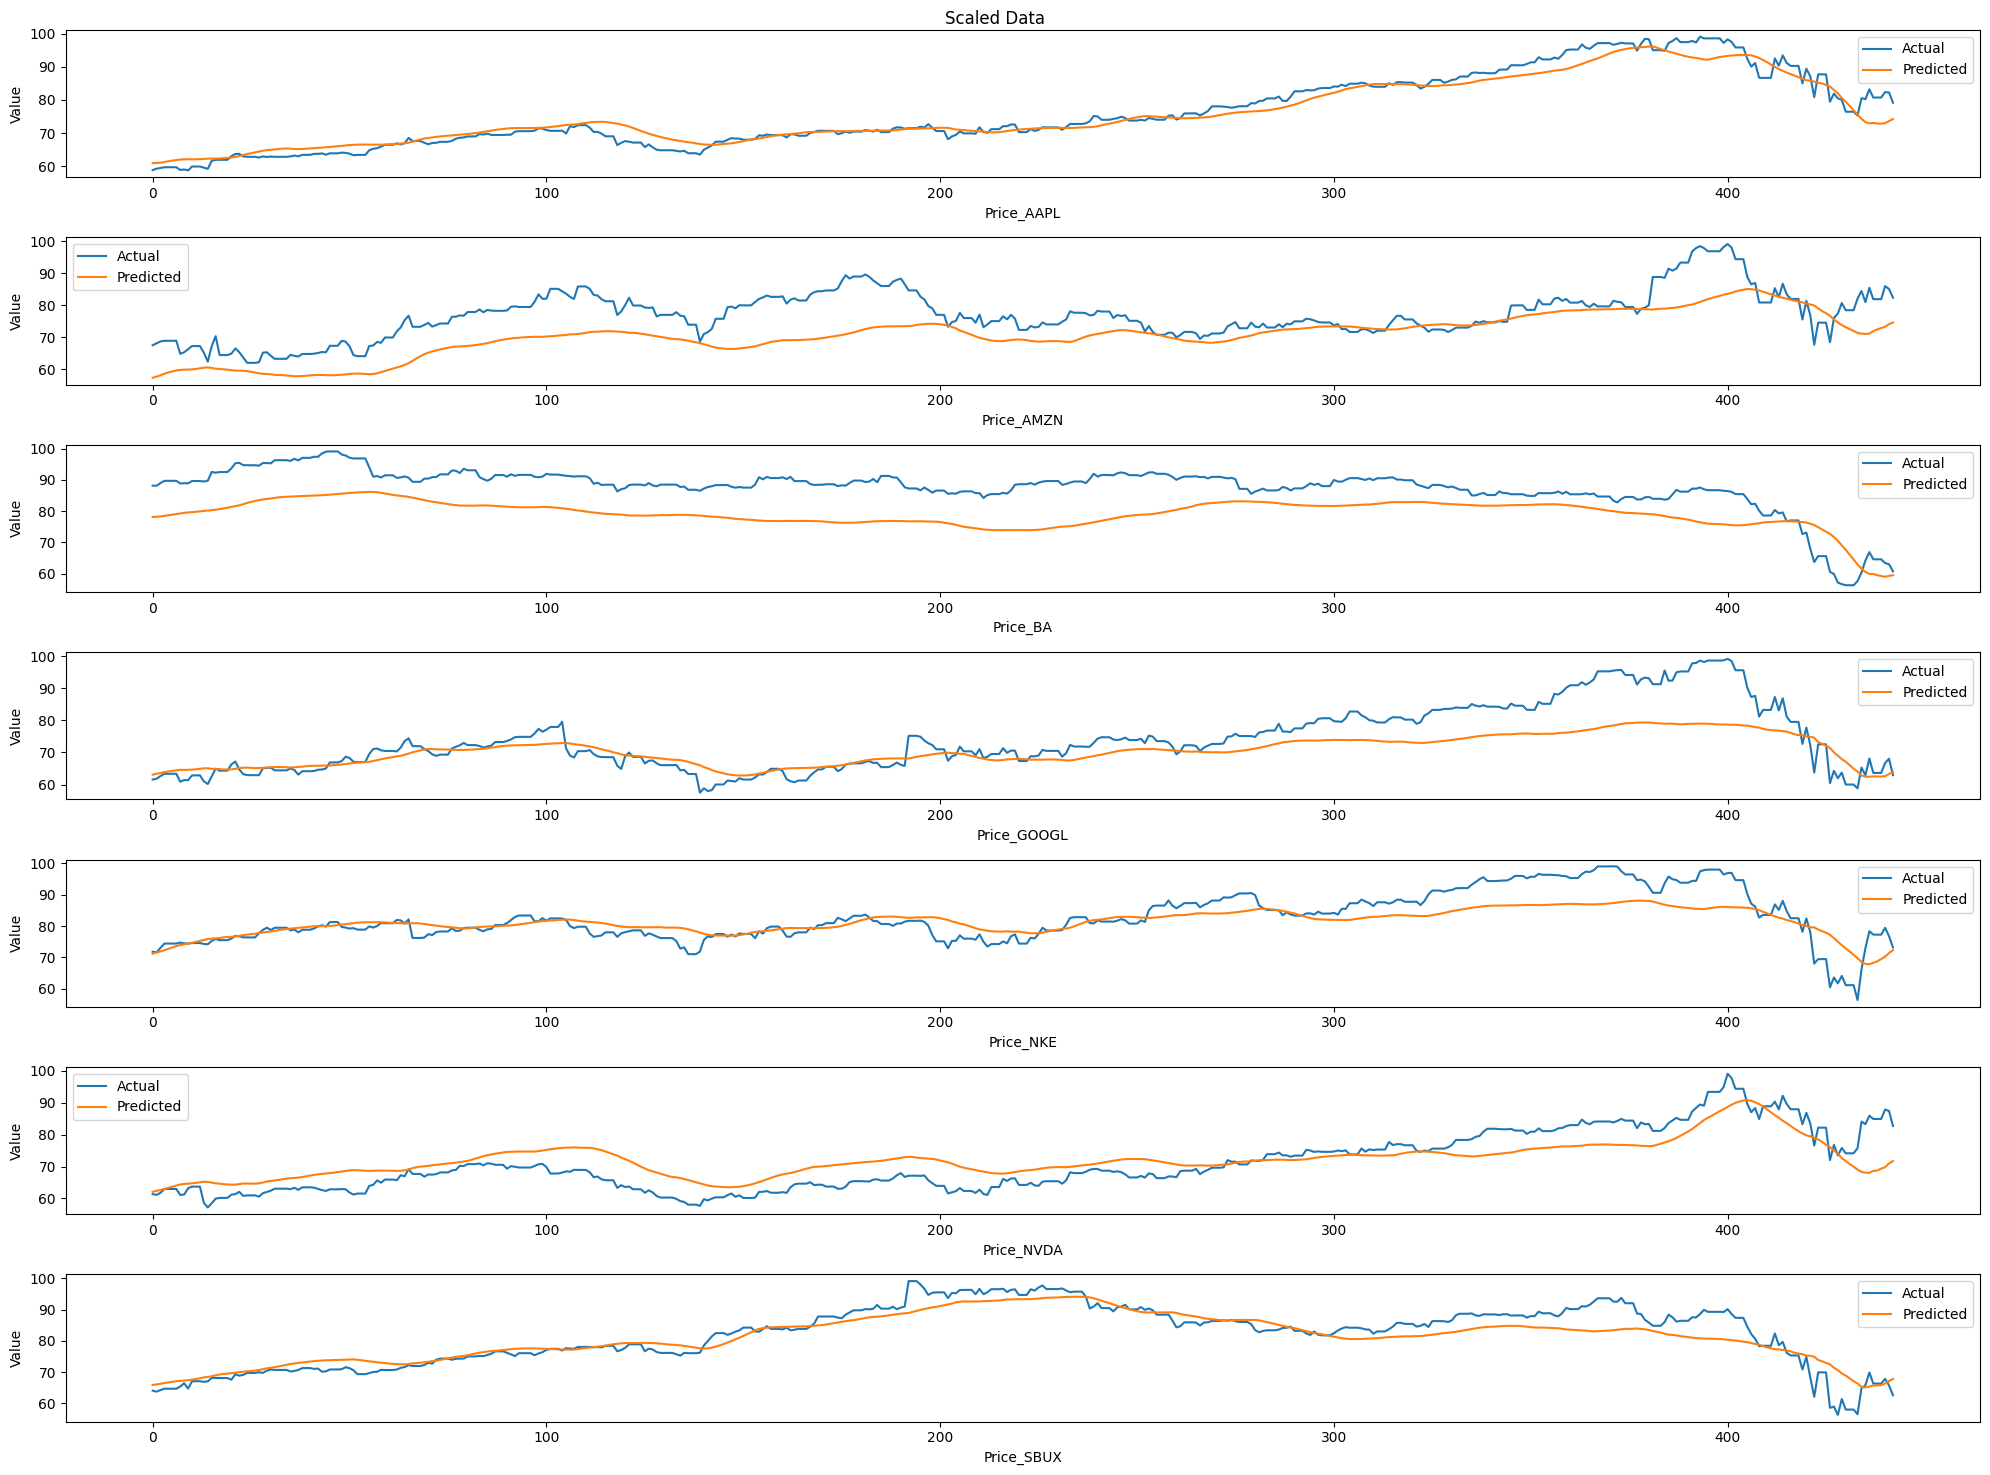

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_CNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

# LSTM
### Find optimal parameters

In [ ]:
def build_lstm_model(n_units, n_past, n_features):
    with strategy.scope():
        inputs = tf.keras.layers.Input(shape=(n_past, n_features), name='input') 
        lstm = tf.keras.layers.LSTM(n_units, return_state=True, name='lstm')
        _, state_h, _ = lstm(inputs)
        
        outputs = tf.keras.layers.Dense(n_features, name='dense')(state_h)
        
        model_LSTM = tf.keras.models.Model(inputs, outputs)
        model_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
    return model_LSTM

In [ ]:
print('Starting find optimal parameters for LSTM model')

# Tập giá trị tham số cần quét
param_grid = {
    'batch_size': [16, 32, 64],
    'units': [32, 64, 128]
}

# Lưu tham số và kết quả
results = []
grid = ParameterGrid(param_grid)

# Lặp qua từng tham số
for params in grid:
    print(f"Testing with parameters: {params}")
    model = build_lstm_model(params['units'], n_past, n_features)
    
    # Huấn luyện mô hình
    history = model.fit(
        trainX, trainY,
        batch_size=params['batch_size'],
        epochs=5,
        verbose=0
    )
    
    # Lưu lại kết quả
    loss = history.history['loss'][-1]
    mae = history.history['mae'][-1]
    results.append({
        'batch_size': params['batch_size'],
        'units': params['units'],
        'loss': loss,
        'mae': mae
    })

# Sắp xếp kết quả theo loss
results = sorted(results, key=lambda x: x['loss'])

# Hiển thị kết quả tốt nhất
print("Best parameters:", results[0])
best_para_LSTM = results[0]

Starting find optimal parameters for LSTM model
Testing with parameters: {'batch_size': 16, 'units': 32}
Testing with parameters: {'batch_size': 16, 'units': 64}
Testing with parameters: {'batch_size': 16, 'units': 128}
Testing with parameters: {'batch_size': 32, 'units': 32}
Testing with parameters: {'batch_size': 32, 'units': 64}
Testing with parameters: {'batch_size': 32, 'units': 128}
Testing with parameters: {'batch_size': 64, 'units': 32}
Testing with parameters: {'batch_size': 64, 'units': 64}
Testing with parameters: {'batch_size': 64, 'units': 128}
Best parameters: {'batch_size': 16, 'units': 128, 'loss': 0.000459738977951929, 'mae': 0.014648760668933392}


### Model initialization

In [ ]:
class LSTM_Model:
    def __init__(self, n_past, n_features, best_para_LSTM, strategy):
        self.n_past = n_past
        self.n_features = n_features
        self.best_para_LSTM = best_para_LSTM
        self.strategy = strategy

        # Xây dựng mô hình LSTM
        with self.strategy.scope():
            self.model_LSTM = self._build_model()

    def _build_model(n_units, n_past, n_features):
        with strategy.scope():
            inputs = tf.keras.layers.Input(shape=(n_past, n_features), name='input') 
            lstm = tf.keras.layers.LSTM(n_units, return_state=True, name='lstm')
            _, state_h, _ = lstm(inputs)
            
            outputs = tf.keras.layers.Dense(n_features, name='dense')(state_h)
            
            model_LSTM = tf.keras.models.Model(inputs, outputs)
            model_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
            
        return model_LSTM

    def train(self, trainX, trainY):
        print('Start training LSTM')

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        start = time.time()
        with self.strategy.scope():
            history_LSTM = self.model_LSTM.fit(
                trainX,
                trainY,
                epochs=50,
                validation_split=0.2,
                batch_size=self.best_para_LSTM['batch_size'],
                verbose=0,
                callbacks=[reduce_lr, early_stopping]
            )
        end = time.time()
        print('Complete training model')
        print(f'Training time: {end - start:.2f} seconds')
        return history_LSTM

    def summary(self):
        self.model_LSTM.summary()

    def plot_loss(self, history_LSTM):
        loss = history_LSTM.history['loss']
        val_loss = history_LSTM.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'bo-', label='Training loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, testX):
        # Phương thức dự đoán
        return self.model_LSTM.predict(testX)

In [ ]:
lstm_model = LSTM_Model(n_past=n_past, n_features=n_features, best_para_LSTM=best_para_LSTM, strategy=strategy)
lstm_model.summary()

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 14, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ [(None, 128), (None,   │        69,632 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,535 (275.53 KB)

 Trainable params: 70,535 (275.53 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
history_LSTM = lstm_model.train(trainX, trainY)
lstm_model.plot_loss(history_LSTM)

Start training LSTM
Complete training model
Training time: 64.45 seconds


In [ ]:
pred_LSTM = lstm_model.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Model Score
#### Scaled data

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_LSTM[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY, pred_LSTM)}')

MSE for Price_AAPL: 0.03605784506422958
MSE for Price_AMZN: 0.03640941678401231
MSE for Price_BA: 0.06321544592107906
MSE for Price_GOOGL: 0.04965503957697605
MSE for Price_NKE: 0.02371511429392591
MSE for Price_NVDA: 0.040156724853006226
MSE for Price_SBUX: 0.01365485046853668
MSE total: 0.03755206242310941


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_LSTM[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY, pred_LSTM, squared=False)}')

RMSE for Price_AAPL: 0.18988903355441455
RMSE for Price_AMZN: 0.1908125173672113
RMSE for Price_BA: 0.25142682021033286
RMSE for Price_GOOGL: 0.22283410775053278
RMSE for Price_NKE: 0.15399712430407883
RMSE for Price_NVDA: 0.20039142909068297
RMSE for Price_SBUX: 0.11685397070077114
RMSE total: 0.18945785756828923


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY[:, i], pred_LSTM[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY, pred_LSTM)}')

MAE for Price_AAPL: 0.1288423292564713
MAE for Price_AMZN: 0.14165016474074263
MAE for Price_BA: 0.23419905479202605
MAE for Price_GOOGL: 0.17286185593372239
MAE for Price_NKE: 0.11432689307975416
MAE for Price_NVDA: 0.15933948588285593
MAE for Price_SBUX: 0.08835157143174688
MAE total: 0.14851019358818848


In [ ]:
for i in range(n_features):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(testY[:, i], pred_LSTM[:, i])}')
    
print(f'R2 total: {r2_score(testY, pred_LSTM)}')

R2 for Price_AAPL: 0.8614226811299809
R2 for Price_AMZN: 0.6886031182868357
R2 for Price_BA: 0.40729569958533474
R2 for Price_GOOGL: 0.7684985241450151
R2 for Price_NKE: 0.8164759422970829
R2 for Price_NVDA: 0.7750881650066426
R2 for Price_SBUX: 0.9287618462485403
R2 total: 0.7494494252427762


#### Unscaled data

In [ ]:
unscaled_LSTM = unscale(pred_LSTM)
originY = unscale(testY)

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_LSTM[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_LSTM)}')

MSE for Price_AAPL: 16.497622896297205
MSE for Price_AMZN: 16.658475455965473
MSE for Price_BA: 28.92309510548627
MSE for Price_GOOGL: 22.71877440762131
MSE for Price_NKE: 10.850426155777694
MSE for Price_NVDA: 18.37298786198145
MSE for Price_SBUX: 6.2475316017513975
MSE total: 17.18127335498297


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_LSTM[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_LSTM, squared=False)}')

RMSE for Price_AAPL: 4.061726590539694
RMSE for Price_AMZN: 4.0814795670155535
RMSE for Price_BA: 5.378019626729366
RMSE for Price_GOOGL: 4.766421551606752
RMSE for Price_NKE: 3.2939985057339802
RMSE for Price_NVDA: 4.286372342900398
RMSE for Price_SBUX: 2.4995062715967324
RMSE total: 4.052503493731782


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_LSTM[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_LSTM)}')

MAE for Price_AAPL: 2.755937451543351
MAE for Price_AMZN: 3.0298970844064055
MAE for Price_BA: 5.009517821654134
MAE for Price_GOOGL: 3.697514858672038
MAE for Price_NKE: 2.4454522775032808
MAE for Price_NVDA: 3.4082711992058212
MAE for Price_SBUX: 1.8898400765240333
MAE total: 3.176632967072723


### Plot predict data

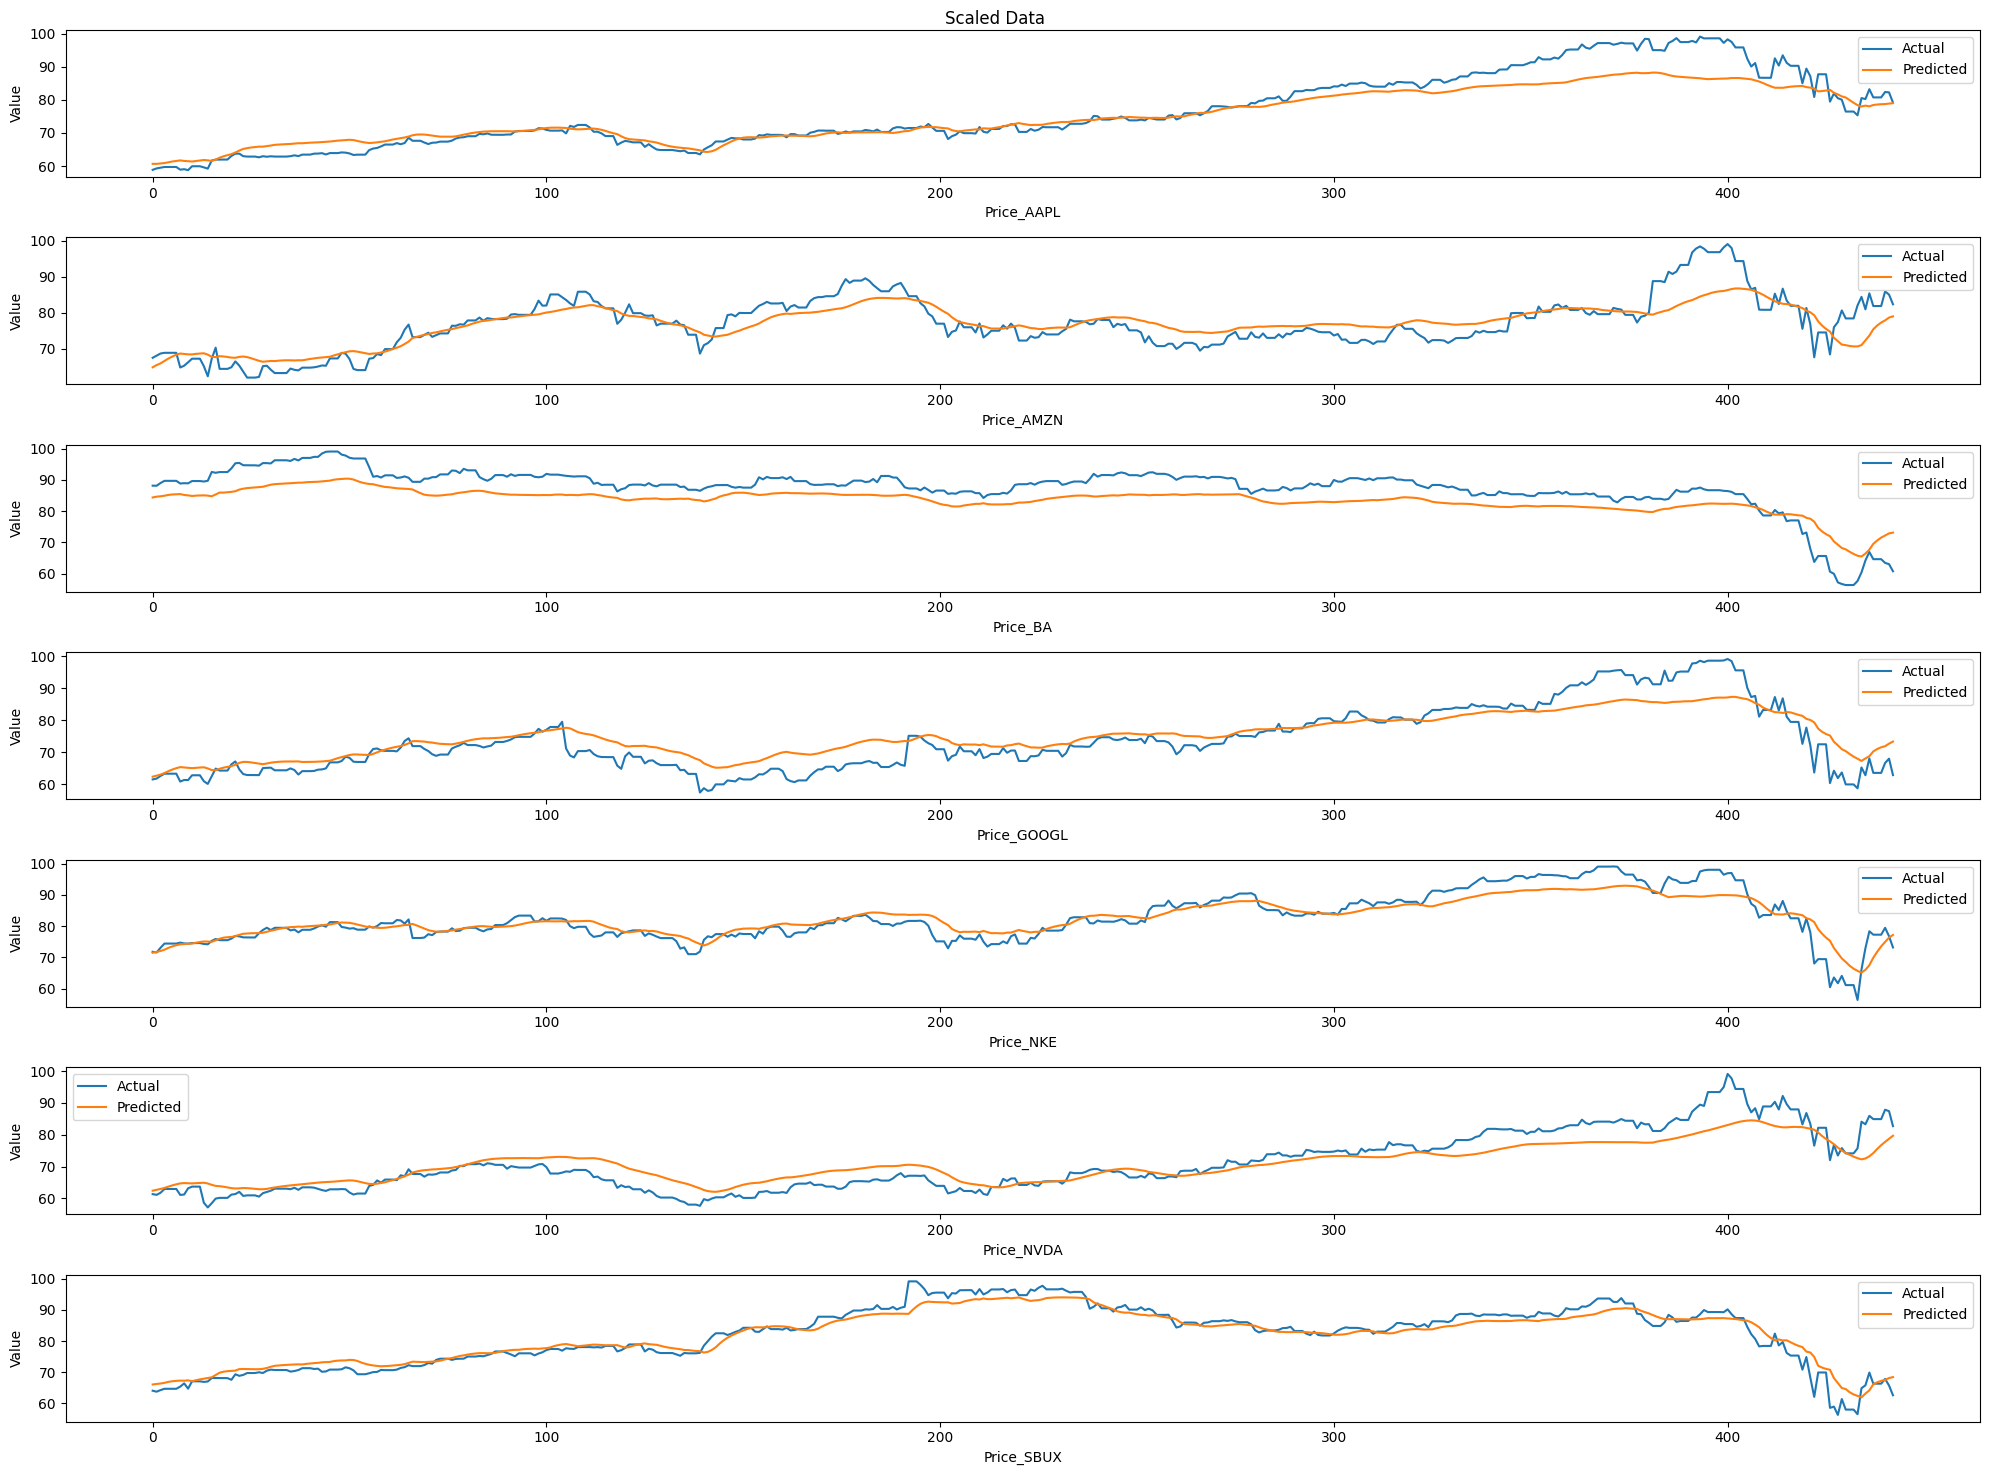

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_LSTM[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

# CNN + LSTM
### Find optimal parameters

In [ ]:
def build_cnn_lstm_model(filters, kernel_size, lstm_units, n_past, n_features):
    with strategy.scope():
        inputs = layers.Input(shape=(n_past, n_features), name='input_layer')
        x = layers.Reshape((n_past, n_features, 1), name='reshape_layer')(inputs)
    
        conv1 = layers.Conv2D(
            filters=filters,
            kernel_size=(kernel_size, n_features),
            activation='relu',
            padding='same',
            name='conv1')(x)
        conv1_bn = layers.BatchNormalization(name='conv1_bn')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1_bn)
    
        conv2 = layers.Conv2D(
            filters=filters,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            name='conv2')(pool1)
        conv2_bn = layers.BatchNormalization(name='conv2_bn')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2_bn)
    
        flatten = layers.Flatten(name='flatten')(pool2)
    
        lstm_input = layers.Reshape((1, flatten.shape[-1]), name='lstm_input')(flatten)
    
        lstm = layers.LSTM(lstm_units, return_state=True, name='lstm')
        _, state_h, _ = lstm(lstm_input)
        
        outputs = layers.Dense(n_features, name='outputs')(state_h)
        
        model_CNN_LSTM = tf.keras.models.Model(inputs, outputs)
        model_CNN_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
    return model_CNN_LSTM

In [ ]:
print('Starting find optimal parameters for CNN + LSTM model')
# Tập giá trị tham số cần quét
param_grid = {
    'filters': [16, 32, 64],
    'kernel_size': [5, 7, 10],
    'lstm_units': [32, 64, 128],
    'batch_size': [16, 32, 64]
}

# Lưu kết quả
results = []
grid = ParameterGrid(param_grid)

# Lặp qua từng tổ hợp tham số
for params in grid:
    print(f"Testing with parameters: {params}")
    cnn_lstm_model = build_cnn_lstm_model(params['filters'], params['kernel_size'], 
                                 params['lstm_units'], n_past, n_features)
    with strategy.scope():
        # Huấn luyện mô hình
        history = cnn_lstm_model.fit(
            trainX, trainY,
            batch_size=params['batch_size'],
            epochs=5,
            verbose=0,
            validation_split=0.2
        )
    
    # Lưu kết quả
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    results.append({
        'filters': params['filters'],
        'kernel_size': params['kernel_size'],
        'lstm_units': params['lstm_units'],
        'batch_size': params['batch_size'],
        'loss': loss,
        'val_loss': val_loss
    })

# Sắp xếp kết quả theo val_loss
results = sorted(results, key=lambda x: x['val_loss'])

# Hiển thị kết quả tốt nhất
print("Best parameters:", results[0])
best_para_cnn_lstm = results[0]

Starting find optimal parameters for CNN + LSTM model
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 3, 'lstm_units': 32}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 3, 'lstm_units': 64}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 3, 'lstm_units': 128}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5, 'lstm_units': 32}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5, 'lstm_units': 64}
Testing with parameters: {'batch_size': 16, 'filters': 16, 'kernel_size': 5, 'lstm_units': 128}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 3, 'lstm_units': 32}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 3, 'lstm_units': 64}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 3, 'lstm_units': 128}
Testing with parameters: {'batch_size': 16, 'filters': 32, 'kernel_size': 5, 'lstm_units

### Model initialization

In [ ]:
class CNN_LSTM_Model:
    def __init__(self, n_past, n_features, best_para_cnn_lstm, strategy):
        self.n_past = n_past
        self.n_features = n_features
        self.best_para_cnn_lstm = best_para_cnn_lstm
        self.strategy = strategy

        # Xây dựng mô hình CNN + LSTM
        with self.strategy.scope():
            self.model_CNN_LSTM = self._build_model()

    def _build_model(filters, kernel_size, lstm_units, n_past, n_features):
        with strategy.scope():
            inputs = layers.Input(shape=(n_past, n_features), name='input_layer')
            x = layers.Reshape((n_past, n_features, 1), name='reshape_layer')(inputs)
        
            conv1 = layers.Conv2D(
                filters=filters,
                kernel_size=(kernel_size, n_features),
                activation='relu',
                padding='same',
                name='conv1')(x)
            conv1_bn = layers.BatchNormalization(name='conv1_bn')(conv1)
            pool1 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool1')(conv1_bn)
        
            conv2 = layers.Conv2D(
                filters=filters,
                kernel_size=(3, 3),
                activation='relu',
                padding='same',
                name='conv2')(pool1)
            conv2_bn = layers.BatchNormalization(name='conv2_bn')(conv2)
            pool2 = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool2')(conv2_bn)
        
            flatten = layers.Flatten(name='flatten')(pool2)
        
            lstm_input = layers.Reshape((1, flatten.shape[-1]), name='lstm_input')(flatten)
        
            lstm = layers.LSTM(lstm_units, return_state=True, name='lstm')
            _, state_h, _ = lstm(lstm_input)
            
            outputs = layers.Dense(n_features, name='outputs')(state_h)
            
            model_CNN_LSTM = tf.keras.models.Model(inputs, outputs)
            model_CNN_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
            
        return model_CNN_LSTM

    def train(self, trainX, trainY):
        print('Start training CNN + LSTM')

        reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        start = time.time()
        with self.strategy.scope():        
            history_CNN_LSTM = self.model_CNN_LSTM.fit(
                trainX,
                trainY,
                epochs=100,
                validation_split=0.2,
                batch_size=self.best_para_cnn_lstm['batch_size'],
                verbose=0,
                callbacks=[reduce_lr, early_stopping]
            )
        end = time.time()
        print('Complete training model')
        print(f'Training time: {end - start:.2f} seconds')
        return history_CNN_LSTM

    def summary(self):
        self.model_CNN_LSTM.summary()

    def plot_loss(self, history_CNN_LSTM):
        loss = history_CNN_LSTM.history['loss']
        val_loss = history_CNN_LSTM.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'bo-', label='Training loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, testX):
        # Phương thức dự đoán
        return self.model_CNN_LSTM.predict(testX)

In [ ]:
cnn_lstm_model = CNN_LSTM_Model(n_past=n_past, n_features=n_features, best_para_cnn_lstm=best_para_cnn_lstm, strategy=strategy)
cnn_lstm_model.summary()

Model: "functional_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_92 (InputLayer)     │ (None, 14, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 14, 16)         │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ [(None, 128), (None,   │        74,240 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,495 (294.90 KB)

 Trainable params: 75,495 (294.90 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
history_CNN_LSTM = cnn_lstm_model.train(trainX, trainY)
cnn_lstm_model.plot_loss(history_CNN_LSTM)

Start training CNN + LSTM
Complete training model
Training time: 13.97 seconds


In [ ]:
pred_CNN_LSTM = cnn_lstm_model.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


### Model Score
#### Scaled data

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_CNN_LSTM[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY, pred_CNN_LSTM)}')

MSE for Price_AAPL: 0.03836880448044341
MSE for Price_AMZN: 0.10315206902406715
MSE for Price_BA: 0.2447939604780594
MSE for Price_GOOGL: 0.03361566128162948
MSE for Price_NKE: 0.13341768282751626
MSE for Price_NVDA: 0.18973326076670288
MSE for Price_SBUX: 0.044177182731251624
MSE total: 0.11246551736995289


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_CNN_LSTM[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY, pred_CNN_LSTM, squared=False)}')

RMSE for Price_AAPL: 0.19587956626571187
RMSE for Price_AMZN: 0.3211729581145759
RMSE for Price_BA: 0.4947665717063547
RMSE for Price_GOOGL: 0.18334574246932892
RMSE for Price_NKE: 0.3652638537105968
RMSE for Price_NVDA: 0.4355838160064064
RMSE for Price_SBUX: 0.21018368807129545
RMSE total: 0.31517088519203856


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY[:, i], pred_CNN_LSTM[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY, pred_CNN_LSTM)}')

MAE for Price_AAPL: 0.1503236302922285
MAE for Price_AMZN: 0.2399852967288125
MAE for Price_BA: 0.45939204009850976
MAE for Price_GOOGL: 0.1344569994050943
MAE for Price_NKE: 0.3363197033755044
MAE for Price_NVDA: 0.2833846108987787
MAE for Price_SBUX: 0.14735644880915225
MAE total: 0.2501741042297258


In [ ]:
for i in range(n_features):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(testY[:, i], pred_CNN_LSTM[:, i])}')
    
print(f'R2 total: {r2_score(testY, pred_CNN_LSTM)}')

R2 for Price_AAPL: 0.8525412141608405
R2 for Price_AMZN: 0.11777678761225563
R2 for Price_BA: -1.2951737661080598
R2 for Price_GOOGL: 0.8432772329891188
R2 for Price_NKE: -0.03247887479496425
R2 for Price_NVDA: -0.06266773484435983
R2 for Price_SBUX: 0.7695250531694403
R2 total: 0.17039998745489632


#### Unscaled data

In [ ]:
unscaled_CNN_LSTM = unscale(pred_CNN_LSTM)
originY = unscale(testY)

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], pred_CNN_LSTM[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, pred_CNN_LSTM)}')

MSE for Price_AAPL: 5940.450540487513
MSE for Price_AMZN: 6018.235058260325
MSE for Price_BA: 7714.450501296985
MSE for Price_GOOGL: 5569.480355022248
MSE for Price_NKE: 6894.215729723304
MSE for Price_NVDA: 5194.6849856530225
MSE for Price_SBUX: 6766.782337984524
MSE total: 6299.75707263256


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], pred_CNN_LSTM[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, pred_CNN_LSTM, squared=False)}')

RMSE for Price_AAPL: 77.07431829401744
RMSE for Price_AMZN: 77.57728442179659
RMSE for Price_BA: 87.83194465168687
RMSE for Price_GOOGL: 74.6289511853292
RMSE for Price_NKE: 83.03141411371544
RMSE for Price_NVDA: 72.07416309367055
RMSE for Price_SBUX: 82.26045427776657
RMSE total: 79.21121857685468


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], pred_CNN_LSTM[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, pred_CNN_LSTM)}')

MAE for Price_AAPL: 76.35657341986716
MAE for Price_AMZN: 77.24396277581211
MAE for Price_BA: 87.56523138188918
MAE for Price_GOOGL: 74.00978672298878
MAE for Price_NKE: 82.69717907681914
MAE for Price_NVDA: 71.51362368788172
MAE for Price_SBUX: 81.76285189477849
MAE total: 78.73560128000527


### Plot predict data

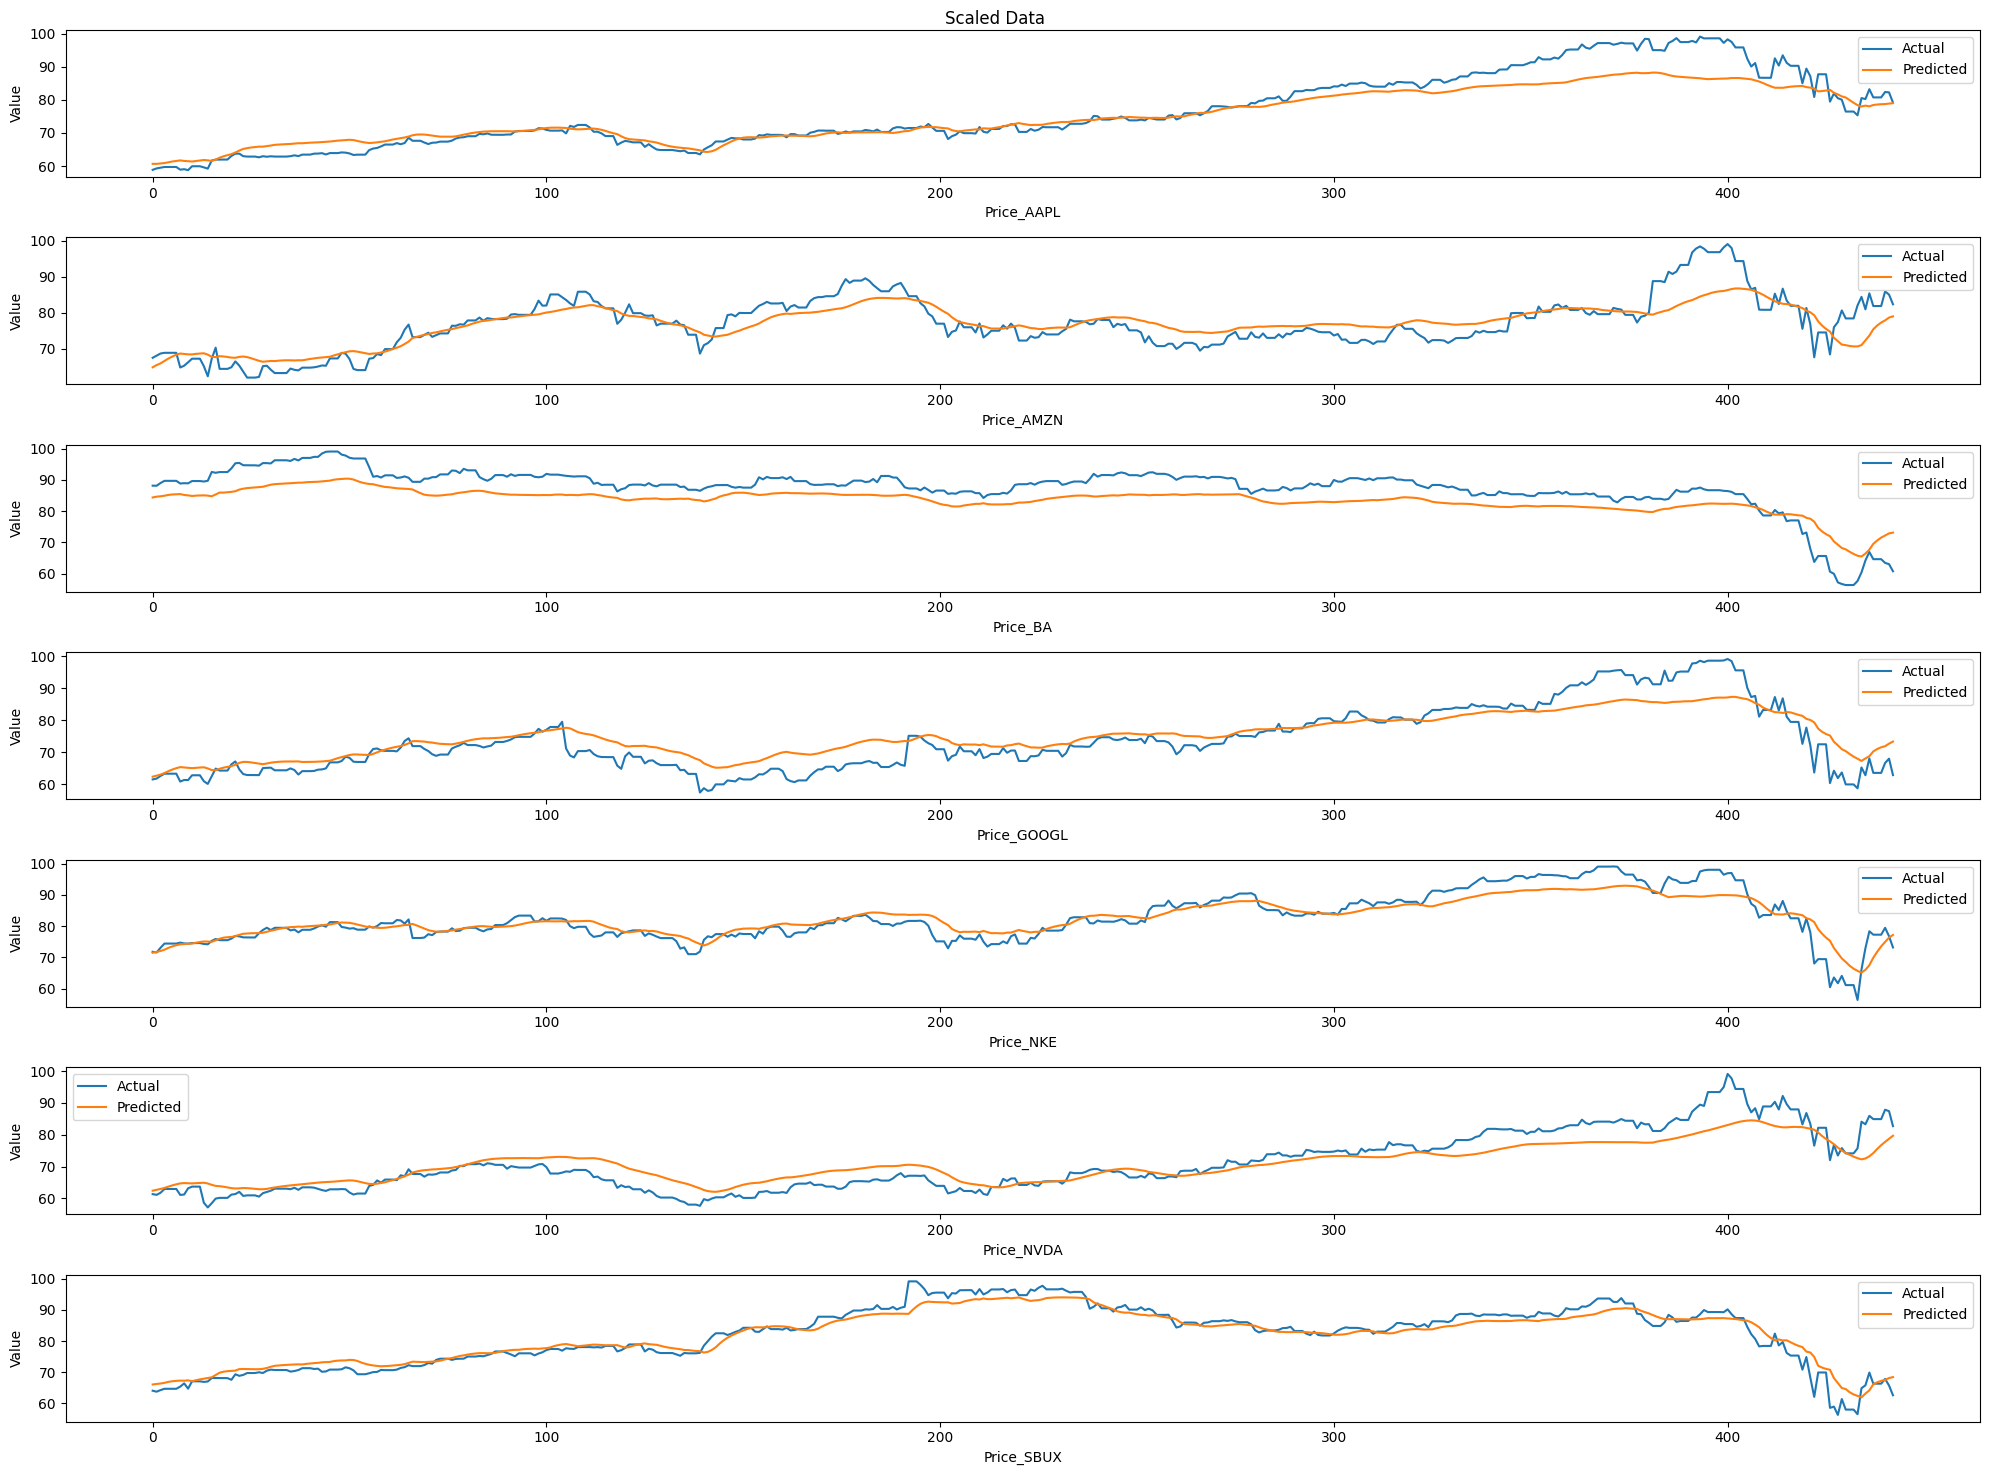

In [ ]:
plt.figure(figsize=(20, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_CNN_LSTM[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

## VARNN
### Define model

In [ ]:
def to_sequences_multivariate(dataset, p):
    x = []
    y = []
    for i in range(p, len(dataset)):
        x.append(dataset.iloc[i - p:i, 0:dataset.shape[1]])
        y.append(dataset.iloc[i:i + 1, 0:dataset.shape[1]])
    x = np.array(x)
    y = np.array(y)
    return x,y.reshape(y.shape[0], y.shape[2])

In [ ]:
p = 14

trainX, trainY = to_sequences_multivariate(VAR_train, p)
testX, testY = to_sequences_multivariate(VAR_test, p)

In [ ]:
class VARNN(tf.keras.Model):
    def __init__(self, ffnn_model, var_model):
        super(VARNN, self).__init__()
        self.ffnn_model = ffnn_model
        self.var_model = var_model

    def call(self, inputs):
        ffnn_output = self.ffnn_model(inputs)
        var_output = self.var_model(ffnn_output)
        return var_output

In [ ]:
num_outputs = 7
ffnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(p, 7)),
    tf.keras.layers.Dense(50, activation='sigmoid'),
])
var_model = tf.keras.layers.Dense(num_outputs)

### Model training

In [ ]:
VARNN_model = VARNN(ffnn_model, var_model)
start = time.time()
VARNN_model.compile(optimizer='adam', loss='mse')
history = VARNN_model.fit(trainX, trainY, verbose=0, epochs=100, batch_size=32, validation_split=0.2)
end = time.time()

In [ ]:
print(end-start)

26.792221784591675


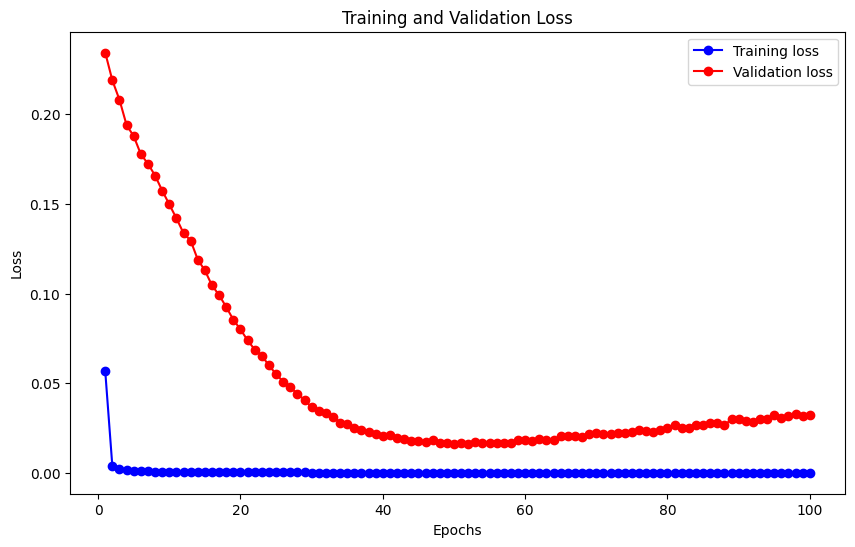

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pred_VARNN = VARNN_model.predict(testX)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Model Evaluation
#### Scaled data

In [ ]:
for i in range(7):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY, pred_VARNN)}')

MSE for Price_AAPL: 0.0053881353030667545
MSE for Price_AMZN: 0.10510562192759582
MSE for Price_BA: 0.049728698478803485
MSE for Price_DIS: 0.005745375213974777
MSE for Price_GOOGL: 0.0844870275779229
MSE for Price_INTC: 0.07942464448333693
MSE for Price_MSFT: 0.008195497813560038
MSE total: 0.04829642868546584


In [ ]:
for i in range(7):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY[:, i], pred_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY, pred_VARNN)}')

MAE for Price_AAPL: 0.05715320738907559
MAE for Price_AMZN: 0.3185147047697213
MAE for Price_BA: 0.21111357806327608
MAE for Price_DIS: 0.0557344894213101
MAE for Price_GOOGL: 0.2840889540599341
MAE for Price_INTC: 0.27054479456570774
MAE for Price_MSFT: 0.06912643876685913
MAE total: 0.1808965952908405


In [ ]:
for i in range(7):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], pred_VARNN[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY, pred_VARNN, squared=False)}')

RMSE for Price_AAPL: 0.07340391885360587
RMSE for Price_AMZN: 0.3241999721276913
RMSE for Price_BA: 0.2229993239424808
RMSE for Price_DIS: 0.07579825337021148
RMSE for Price_GOOGL: 0.29066652297422024
RMSE for Price_INTC: 0.2818237826787103
RMSE for Price_MSFT: 0.09052898880226178
RMSE total: 0.194202966107026


In [ ]:
for i in range(7):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(testY[:, i], pred_VARNN[:, i])}')
    
print(f'R2 total: {r2_score(testY, pred_VARNN)}')

R2 for Price_AAPL: 0.9680309789614902
R2 for Price_AMZN: -7.11955317433325
R2 for Price_BA: 0.4858154511110653
R2 for Price_DIS: 0.8360699753937249
R2 for Price_GOOGL: -1.1830711809955958
R2 for Price_INTC: -0.039932440614451226
R2 for Price_MSFT: 0.9008829516100538
R2 total: -0.7359653484095674


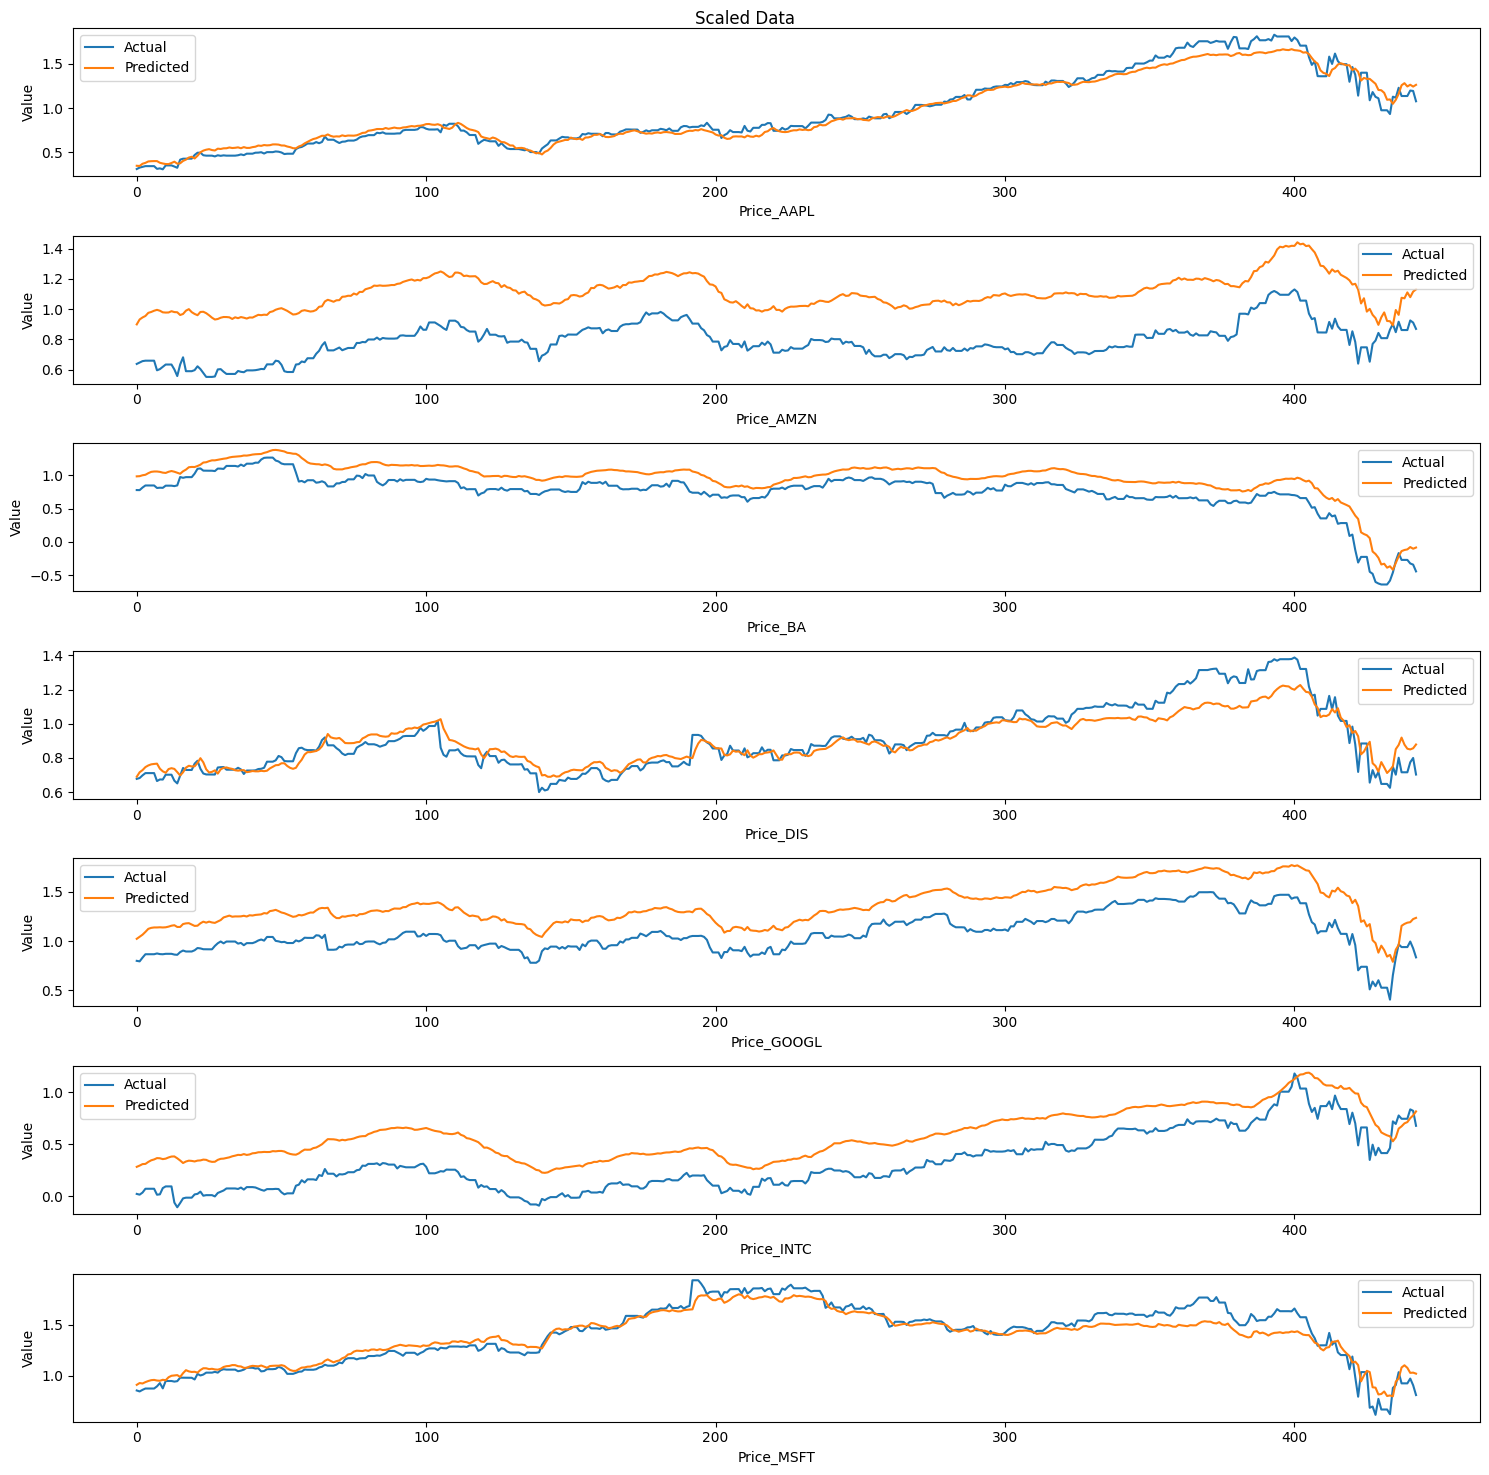

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(testY[:, i], label='Actual')
    plt.plot(pred_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
def unscale(data):
    temp = data.copy()
    for index, i in enumerate(temp_df.columns):
        scaler = scalers['scaler_' + i]
        temp[:, index] = scaler.inverse_transform(np.reshape(data[:, index], (-1, 1))).flatten()
    return temp

In [ ]:
unscaled_VARNN = unscale(pred_VARNN)
originY = unscale(testY)

In [ ]:
for i in range(7):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_VARNN)}')

MSE for Price_AAPL: 71.18155017117424
MSE for Price_AMZN: 106522.99513140939
MSE for Price_BA: 1637.6337862992214
MSE for Price_DIS: 2192.3266573441356
MSE for Price_GOOGL: 123.10541445747508
MSE for Price_INTC: 1618.1782470605579
MSE for Price_MSFT: 8.692488669179092
MSE total: 16024.873325058734


In [ ]:
for i in range(7):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_VARNN[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_VARNN, squared=False)}')

RMSE for Price_AAPL: 8.436915915853033
RMSE for Price_AMZN: 326.3786070369953
RMSE for Price_BA: 40.467688175867195
RMSE for Price_DIS: 46.82228804046355
RMSE for Price_GOOGL: 11.095287939367553
RMSE for Price_INTC: 40.22658632124478
RMSE for Price_MSFT: 2.9483026759780095
RMSE total: 68.05366801510992


In [ ]:
for i in range(7):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_VARNN[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_VARNN)}')

MAE for Price_AAPL: 6.569087973566682
MAE for Price_AMZN: 320.6551351095161
MAE for Price_BA: 38.31078178457428
MAE for Price_DIS: 34.42844916143483
MAE for Price_GOOGL: 10.844209838936075
MAE for Price_INTC: 38.61666088233414
MAE for Price_MSFT: 2.251275133602237
MAE total: 64.52508569770919


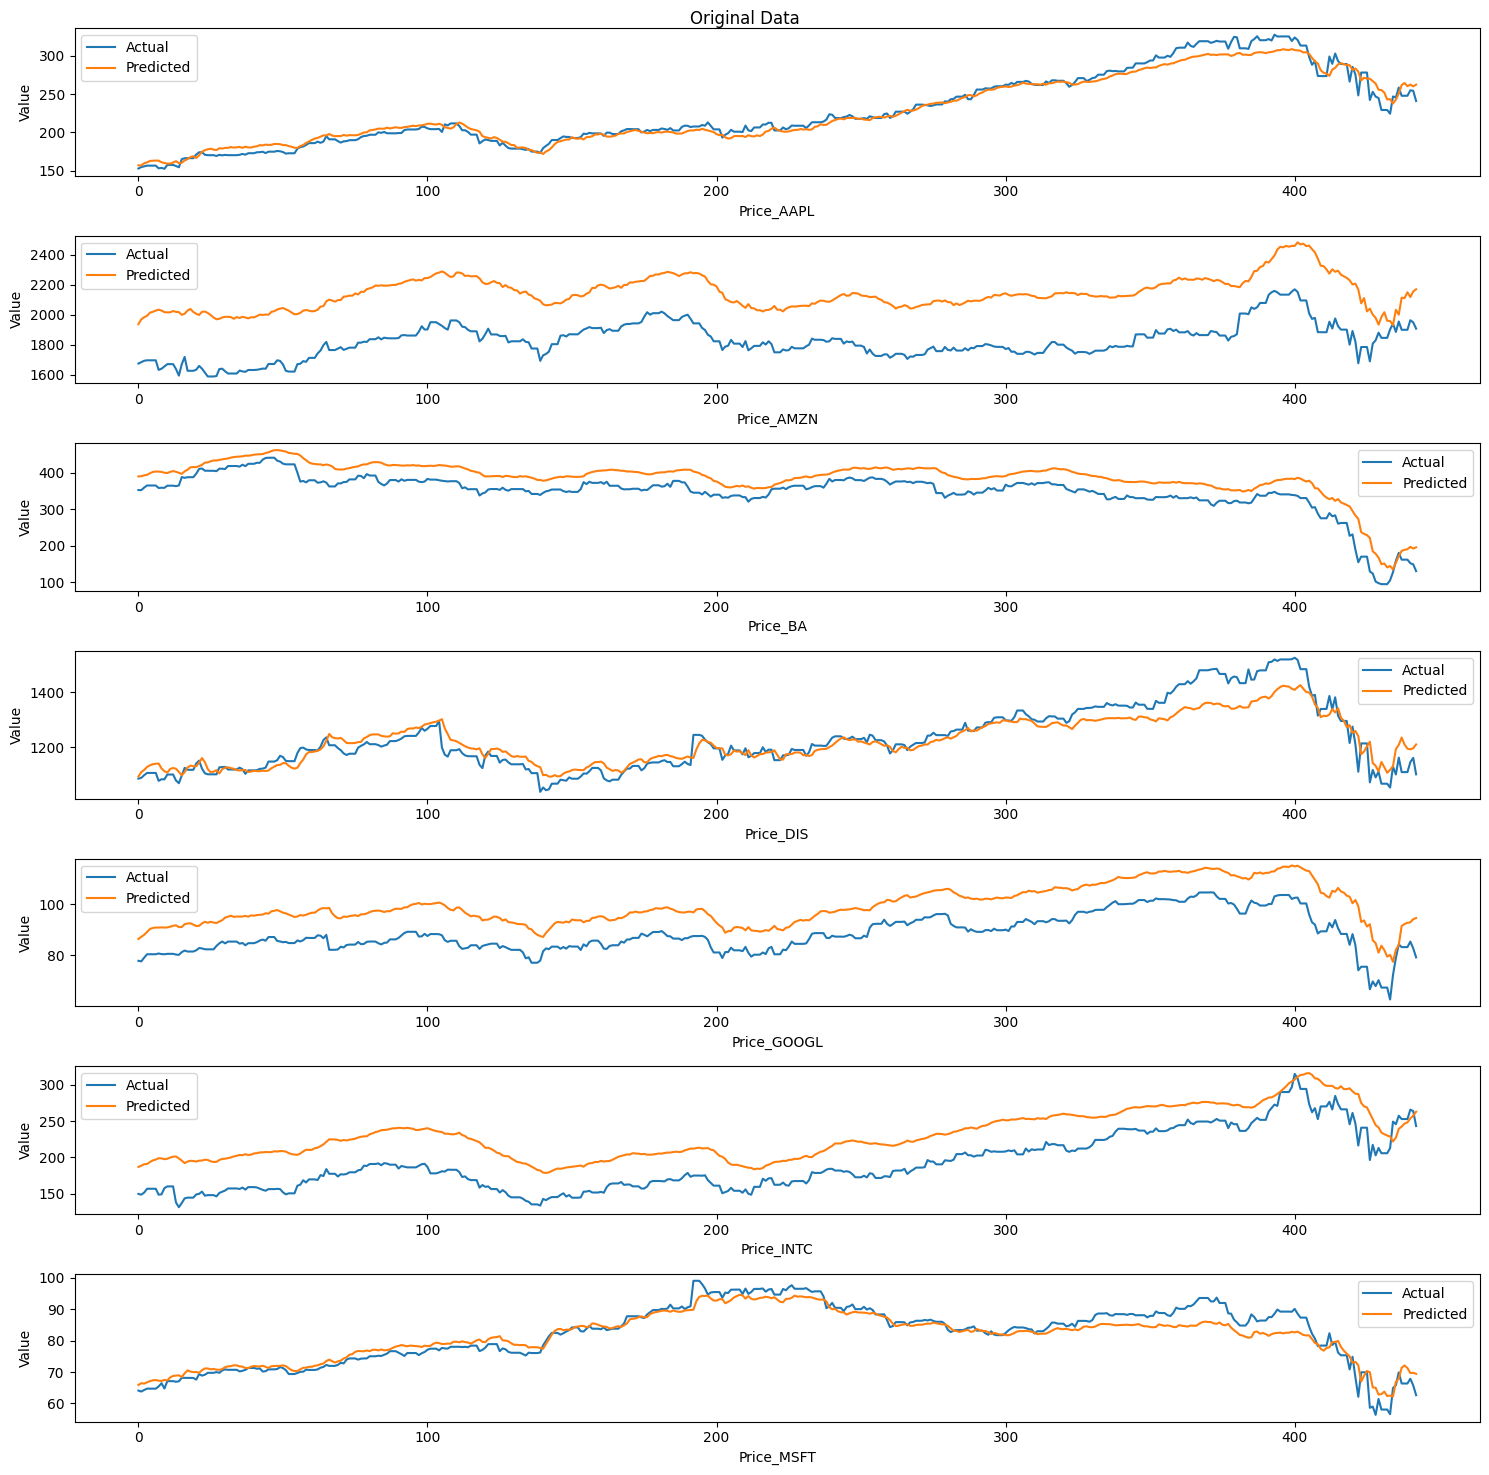

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_VARNN[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

## SrVAR
### Define model

In [ ]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]  # Vector trạng thái cuối

In [ ]:
class StateRegularizedUnit(nn.Module):
    def __init__(self, hidden_dim, num_states, tau=1.0):
        super(StateRegularizedUnit, self).__init__()
        self.state_encodings = nn.Parameter(torch.randn(num_states, hidden_dim))
        self.tau = tau

    def forward(self, u_t):
        # Tính điểm gần gũi (Proximity scores)
        proximity_scores = torch.matmul(u_t, self.state_encodings.T)  # Công thức (2) 
        alpha = torch.softmax(proximity_scores / self.tau, dim=-1)  # Công thức (4) 

        # Tính trạng thái h_t dựa trên phân phối alpha
        h_t = torch.matmul(alpha, self.state_encodings)  # Công thức (5)

        # Tính entropy regularization
        entropy_reg = -torch.sum(alpha * torch.log(alpha + 1e-10), dim=-1).mean() # Công thức (6)

        return h_t, alpha, entropy_reg

In [ ]:
class GraphGeneration(nn.Module):
    def __init__(self, hidden_dim, num_vars):
        super(GraphGeneration, self).__init__()
        self.g_a = nn.Linear(hidden_dim, num_vars * num_vars)
        self.g_d = nn.Linear(hidden_dim, num_vars)

    def forward(self, c_st):
        # Sinh ma trận DAG (Adjacency matrix A_st)
        A_st = self.g_a(c_st).view(-1, num_vars, num_vars)  # Công thức (10)

        # Sinh ma trận time-lagged (Diagonal matrix D_st)
        D_st = torch.diag_embed(self.g_d(c_st))  # Công thức (11)

        # Ràng buộc tính không chu kỳ (Acyclicity constraint)
        exp_A = torch.matrix_exp(A_st * A_st)  # Tính ma trận mũ của A_st * A_st, nếu có chu kì thì exp_A sẽ cao [batch_size, num_vars, num_vars]
        trace_exp_A = torch.sum(torch.diagonal(exp_A, dim1=-2, dim2=-1), dim=-1)  # Tính trace cho từng ma trận trong batch [batch_size,] = torch.trace
        acyclic_penalty = torch.mean(trace_exp_A - A_st.size(-1))  # Tổng hợp thành scalar [batch_sỉze]

        return A_st, D_st, acyclic_penalty

In [ ]:
class DynamicVAR(nn.Module):
    def __init__(self, num_vars):
        super(DynamicVAR, self).__init__()
        self.var_weights = nn.Parameter(torch.randn(num_vars, num_vars))

    def forward(self, x_t, A_st, D_st):
        batch_size = x_t.size(0)
        x_t = x_t.unsqueeze(-1)

        # Tính toán từ ma trận adjacency (x_hat_A)
        x_hat_A = torch.matmul(A_st, x_t).squeeze(-1)

        # Tính toán từ ma trận time-lagged (x_hat_D)
        weighted_x_t = torch.matmul(self.var_weights, x_t.squeeze(-1).unsqueeze(-1)).squeeze(-1)
        x_hat_D = torch.matmul(D_st, weighted_x_t.unsqueeze(-1)).squeeze(-1)

        # Tổng hợp dự đoán
        x_hat = x_hat_A + x_hat_D
        return x_hat

In [ ]:
class SrVARModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_states, num_vars, tau=10.0):
        super(SrVARModel, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim)
        self.state_regularized_unit = StateRegularizedUnit(hidden_dim, num_states, tau)
        self.graph_generation = GraphGeneration(hidden_dim, num_vars)
        self.dynamic_var = DynamicVAR(num_vars)

    def forward(self, x):
        u_t = self.encoder(x)  # Bước 1
        h_t, alpha, entropy_reg = self.state_regularized_unit(u_t)  # Bước 2
        A_st, D_st, acyclic_penalty = self.graph_generation(h_t)  # Bước 3
        x_hat = self.dynamic_var(x[:, -1, :], A_st, D_st)  # Bước 4

        return x_hat, alpha, entropy_reg, acyclic_penalty

In [ ]:
def train_srvarm(model, trainX, trainY, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=0):

    # Optimizer và Loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Lagrangian parameters
    rho = 1.0
    lagrangian_multiplier = 0.0
    max_rho = 10.0

    # Lưu lịch sử mất mát
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0

        # Huấn luyện
        for i in range(0, len(trainX), batch_size):
            # Lấy batch và chuyển về device
            batch_x = torch.tensor(trainX[i:i + batch_size], dtype=torch.float32)
            batch_y = torch.tensor(trainY[i:i + batch_size], dtype=torch.float32)

            # Forward pass
            x_hat, alpha, entropy_reg, acyclic_penalty = model(batch_x)

            # Tính hàm mất mát
            loss = (
                mse_loss(x_hat, batch_y)
                + 0.01 * entropy_reg
                + rho / 2 * acyclic_penalty.pow(2).mean()
                + lagrangian_multiplier * acyclic_penalty.mean()
            )

            # Backward pass và update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

        # Tính mất mát trung bình trên tập huấn luyện
        train_avg_loss = train_epoch_loss / (len(trainX) / batch_size)
        train_loss_history.append(train_avg_loss)

        # Đánh giá trên tập validation
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for i in range(0, len(valX), batch_size):
                batch_val_x = torch.tensor(valX[i:i + batch_size], dtype=torch.float32)
                batch_val_y = torch.tensor(valY[i:i + batch_size], dtype=torch.float32)

                # Forward pass
                x_hat, alpha, entropy_reg, acyclic_penalty = model(batch_val_x)

                # Tính hàm mất mát validation
                val_loss = mse_loss(x_hat, batch_val_y) + 0.01 * entropy_reg
                val_epoch_loss += val_loss.item()

        # Tính mất mát trung bình trên tập validation
        val_avg_loss = val_epoch_loss / (len(valX) / batch_size)
        val_loss_history.append(val_avg_loss)

        # Log thông tin
        if verbose == 1:
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_avg_loss:.4f}, Val Loss: {val_avg_loss:.4f}")

    return model, train_loss_history, val_loss_history
    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            # Forward pass
            y_pred, _ = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation on test data
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            y_pred, _ = model(x_batch)
            all_preds.append(y_pred.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    # Flatten the predictions and labels for calculating the mean squared error
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    mse = mean_squared_error(all_labels, all_preds)
    return mse

In [ ]:
# Chia dữ liệu thành train và validation
Xtrain, valX, Ytrain, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

input_dim = trainX.shape[2]
hidden_dim = 64
num_vars = trainX.shape[2]

for num_states in range(1, 6):
    model = SrVARModel(input_dim=input_dim, hidden_dim=hidden_dim, num_states=num_states, num_vars=num_vars)
    trained_model_SrVAR, train_loss_history_SrVAR, val_loss_history_SrVAR = train_srvarm(
        model, Xtrain, Ytrain, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=0
    )

    print(f"num_states: {num_states}, train_loss: {train_loss_history_SrVAR[-1]}, val_loss: {val_loss_history_SrVAR[-1]}")

num_states: 1, train_loss: 0.000269973673540783, val_loss: 0.0005107308331425119
num_states: 2, train_loss: 0.0006933429356062073, val_loss: 0.0007787047998326784
num_states: 3, train_loss: 0.0009737881489946872, val_loss: 0.001058649273505639
num_states: 4, train_loss: 0.000509954341679477, val_loss: 0.0005731993997976568
num_states: 5, train_loss: 0.0007288240831401372, val_loss: 0.00085452905079526


### Model training

In [ ]:
# Model parameters
num_states = 2

# Instantiate the model
model_SrVAR = SrVARModel(input_dim=input_dim, hidden_dim=hidden_dim, num_states=num_states, num_vars=num_vars)

start = time.time()
trained_model_SrVAR, train_loss_history_SrVAR, val_loss_history_SrVAR = train_srvarm(
    model_SrVAR, Xtrain, Ytrain, valX, valY, num_epochs=100, batch_size=32, lr=0.001, tau=1.0, verbose=1
)
end = time.time()

# Log training time
print(f"Training completed in {end - start:.2f} seconds")

Epoch 10/100, Train Loss: 0.0093, Val Loss: 0.0084
Epoch 20/100, Train Loss: 0.0033, Val Loss: 0.0045
Epoch 30/100, Train Loss: 0.0021, Val Loss: 0.0032
Epoch 40/100, Train Loss: 0.0013, Val Loss: 0.0017
Epoch 50/100, Train Loss: 0.0009, Val Loss: 0.0010
Epoch 60/100, Train Loss: 0.0008, Val Loss: 0.0009
Epoch 70/100, Train Loss: 0.0006, Val Loss: 0.0008
Epoch 80/100, Train Loss: 0.0005, Val Loss: 0.0008
Epoch 90/100, Train Loss: 0.0004, Val Loss: 0.0007
Epoch 100/100, Train Loss: 0.0004, Val Loss: 0.0006
Training completed in 100.98 seconds


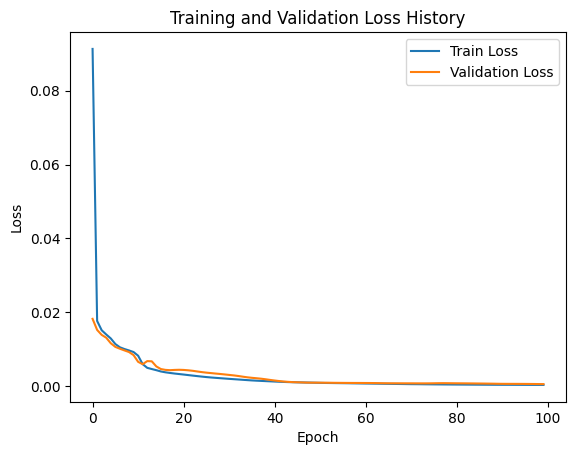

In [ ]:
plt.plot(train_loss_history_SrVAR, label="Train Loss")
plt.plot(val_loss_history_SrVAR, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.show()

In [ ]:
model_SrVAR.eval()  # Đặt mô hình ở chế độ đánh giá
predictions_SrVAR = []
batch_size = 32
n_features = 7

with torch.no_grad():  # Không cần tính gradient trong chế độ dự đoán
    for i in range(0, len(testX), batch_size):
        # Lấy batch từ testX và chuyển về device
        batch_x = torch.tensor(testX[i:i+batch_size], dtype=torch.float32)

        # Dự đoán với mô hình
        batch_pred, _, _, _ = model_SrVAR(batch_x)  # Nếu forward của model trả về nhiều giá trị

        # Chuyển kết quả về CPU và thêm vào danh sách predictions
        predictions_SrVAR.append(batch_pred.cpu().numpy())

# Kết hợp danh sách predictions thành một mảng numpy
predictions_SrVAR = np.concatenate(predictions_SrVAR, axis=0)

### Model Evaluation
#### Scaled data

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], predictions_SrVAR[:, i])}')
    
print(f'MSE total: {mean_squared_error(testY, predictions_SrVAR)}')

MSE for Price_AAPL: 0.00321402794939881
MSE for Price_AMZN: 0.005173340636574804
MSE for Price_BA: 0.00180499134808922
MSE for Price_DIS: 0.0016087158355383045
MSE for Price_GOOGL: 0.0037457883702912437
MSE for Price_INTC: 0.0020229018943477475
MSE for Price_MSFT: 0.004245418701258754
MSE total: 0.0031164549622141255


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(testY[:, i], predictions_SrVAR[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(testY, predictions_SrVAR, squared=False)}')

RMSE for Price_AAPL: 0.05669239763318191
RMSE for Price_AMZN: 0.07192593855192161
RMSE for Price_BA: 0.04248518974994957
RMSE for Price_DIS: 0.04010879997629329
RMSE for Price_GOOGL: 0.06120284609633153
RMSE for Price_INTC: 0.04497668167337101
RMSE for Price_MSFT: 0.06515687762054559
RMSE total: 0.054649818757370634


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(testY[:, i], predictions_SrVAR[:, i])}')
    
print(f'MAE total: {mean_absolute_error(testY, predictions_SrVAR)}')

MAE for Price_AAPL: 0.04574381202341747
MAE for Price_AMZN: 0.06334005161080776
MAE for Price_BA: 0.028147554093003638
MAE for Price_DIS: 0.031164333251435188
MAE for Price_GOOGL: 0.04953154489167494
MAE for Price_INTC: 0.029061375756475917
MAE for Price_MSFT: 0.055454010305823906
MAE total: 0.04320609741894838


In [ ]:
for i in range(n_features):
    print(f'R2 for {scaled_test.columns[i]}: {r2_score(testY[:, i], predictions_SrVAR[:, i])}')
    
print(f'R2 total: {r2_score(testY, predictions_SrVAR)}')

R2 for Price_AAPL: 0.9809304478537858
R2 for Price_AMZN: 0.6003523539726132
R2 for Price_BA: 0.9813367594476401
R2 for Price_DIS: 0.9540992856545127
R2 for Price_GOOGL: 0.9032120921315491
R2 for Price_INTC: 0.9735134942334681
R2 for Price_MSFT: 0.9486555447367683
R2 total: 0.9060142825757624


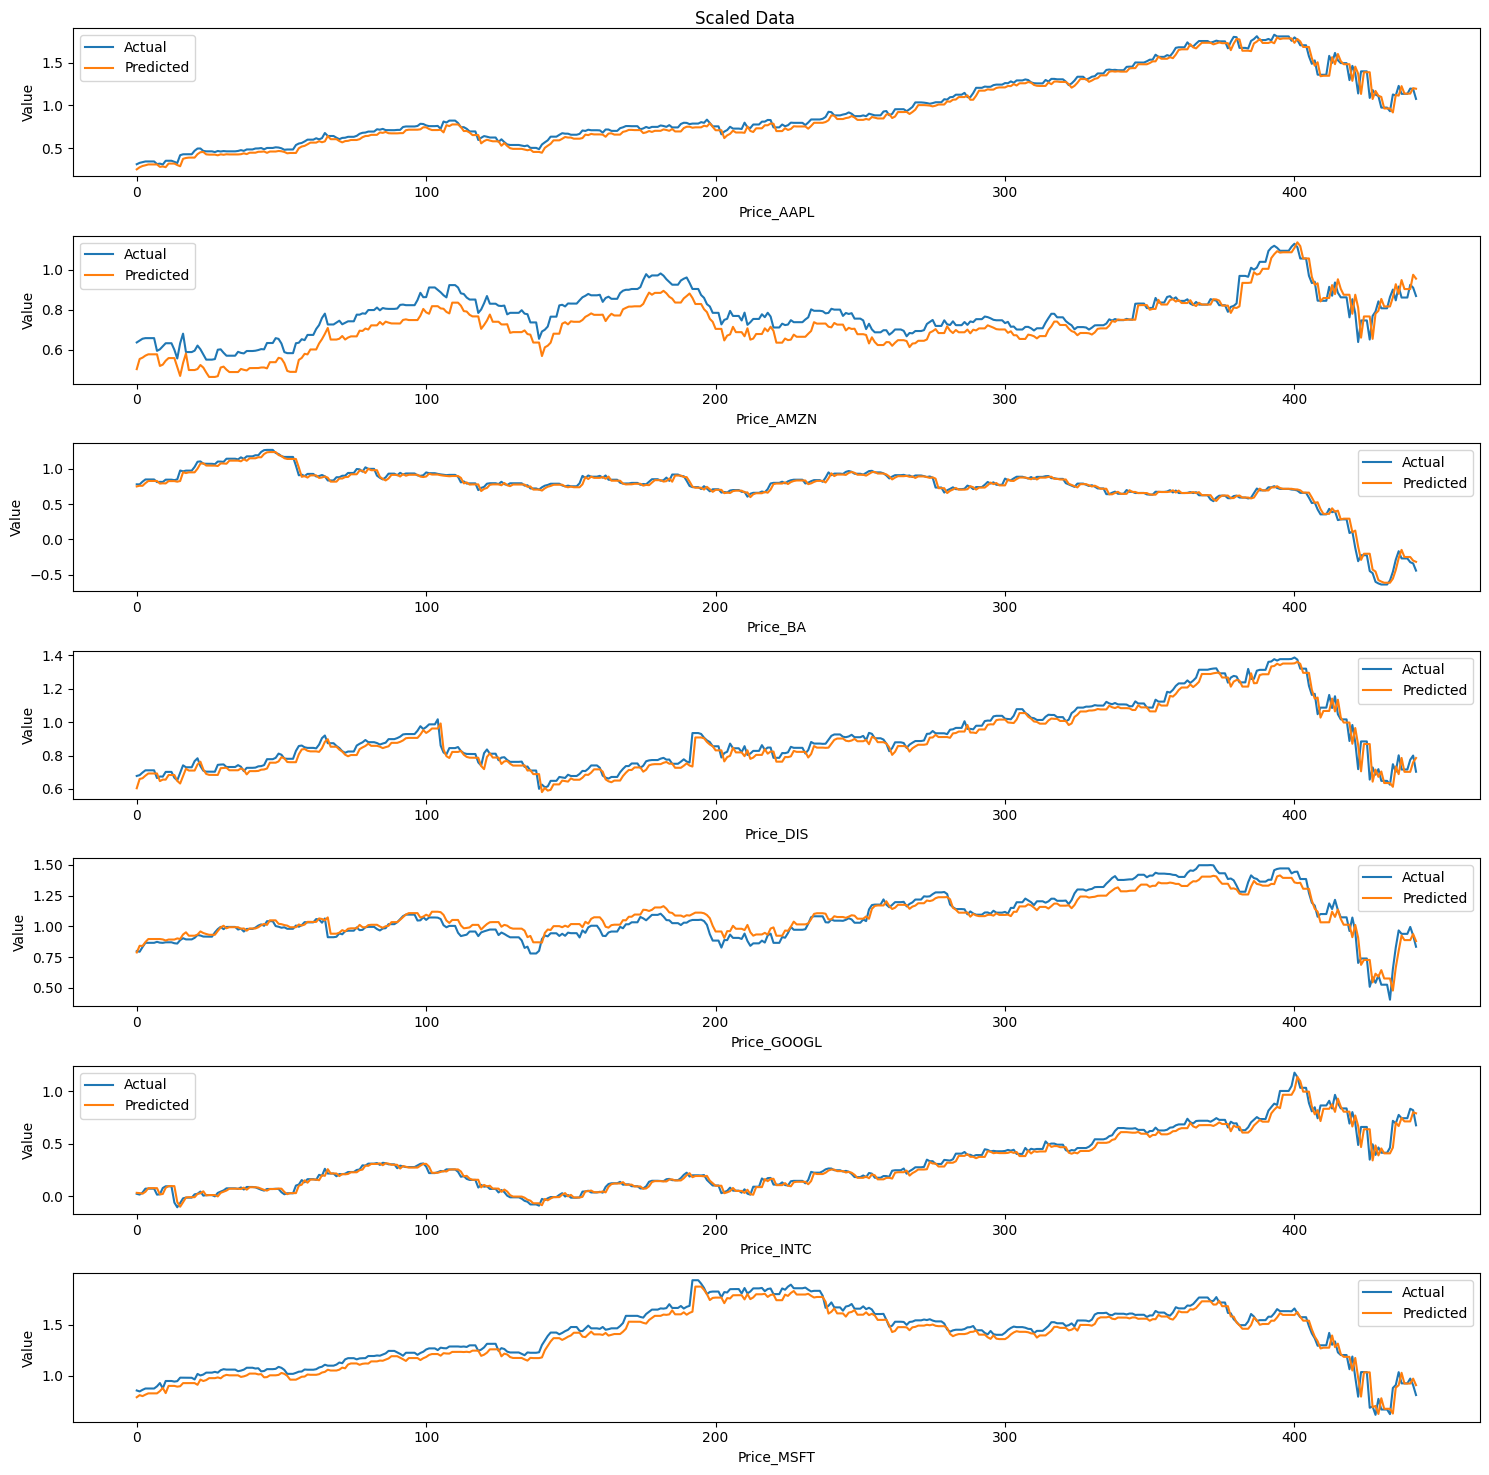

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(testY[:, i], label='Actual')
    plt.plot(predictions_SrVAR[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Scaled Data')
plt.tight_layout()
plt.show()

#### Unscaled data

In [ ]:
unscaled_SrVAR = unscale(predictions_SrVAR)
originY = unscale(testY)

In [ ]:
for i in range(n_features):
    print(f'MSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_SrVAR[:, i])}')
    
print(f'MSE total: {mean_squared_error(originY, unscaled_SrVAR)}')

MSE for Price_AAPL: 42.45987583758914
MSE for Price_AMZN: 5243.104615330326
MSE for Price_BA: 59.440799180132764
MSE for Price_DIS: 613.8549366577889
MSE for Price_GOOGL: 5.457959261526726
MSE for Price_INTC: 41.21410374166225
MSE for Price_MSFT: 4.502867759997643
MSE total: 858.5764511098604


In [ ]:
for i in range(n_features):
    print(f'RMSE for {scaled_test.columns[i]}: {mean_squared_error(originY[:, i], unscaled_SrVAR[:, i], squared=False)}')
    
print(f'RMSE total: {mean_squared_error(originY, unscaled_SrVAR, squared=False)}')

RMSE for Price_AAPL: 6.516124295744299
RMSE for Price_AMZN: 72.40928542203912
RMSE for Price_BA: 7.709785936077133
RMSE for Price_DIS: 24.776096073792356
RMSE for Price_GOOGL: 2.3362275705775595
RMSE for Price_INTC: 6.419821161189947
RMSE for Price_MSFT: 2.121996173417295
RMSE total: 17.469905233262534


In [ ]:
for i in range(n_features):
    print(f'MAE for {scaled_test.columns[i]}: {mean_absolute_error(originY[:, i], unscaled_SrVAR[:, i])}')
    
print(f'MAE total: {mean_absolute_error(originY, unscaled_SrVAR)}')

MAE for Price_AAPL: 5.257713679535394
MAE for Price_AMZN: 63.76570022617452
MAE for Price_BA: 5.1079344222023595
MAE for Price_DIS: 19.250893896374162
MAE for Price_GOOGL: 1.890712238595933
MAE for Price_INTC: 4.148123816496633
MAE for Price_MSFT: 1.805997964759982
MAE total: 14.461010892019855


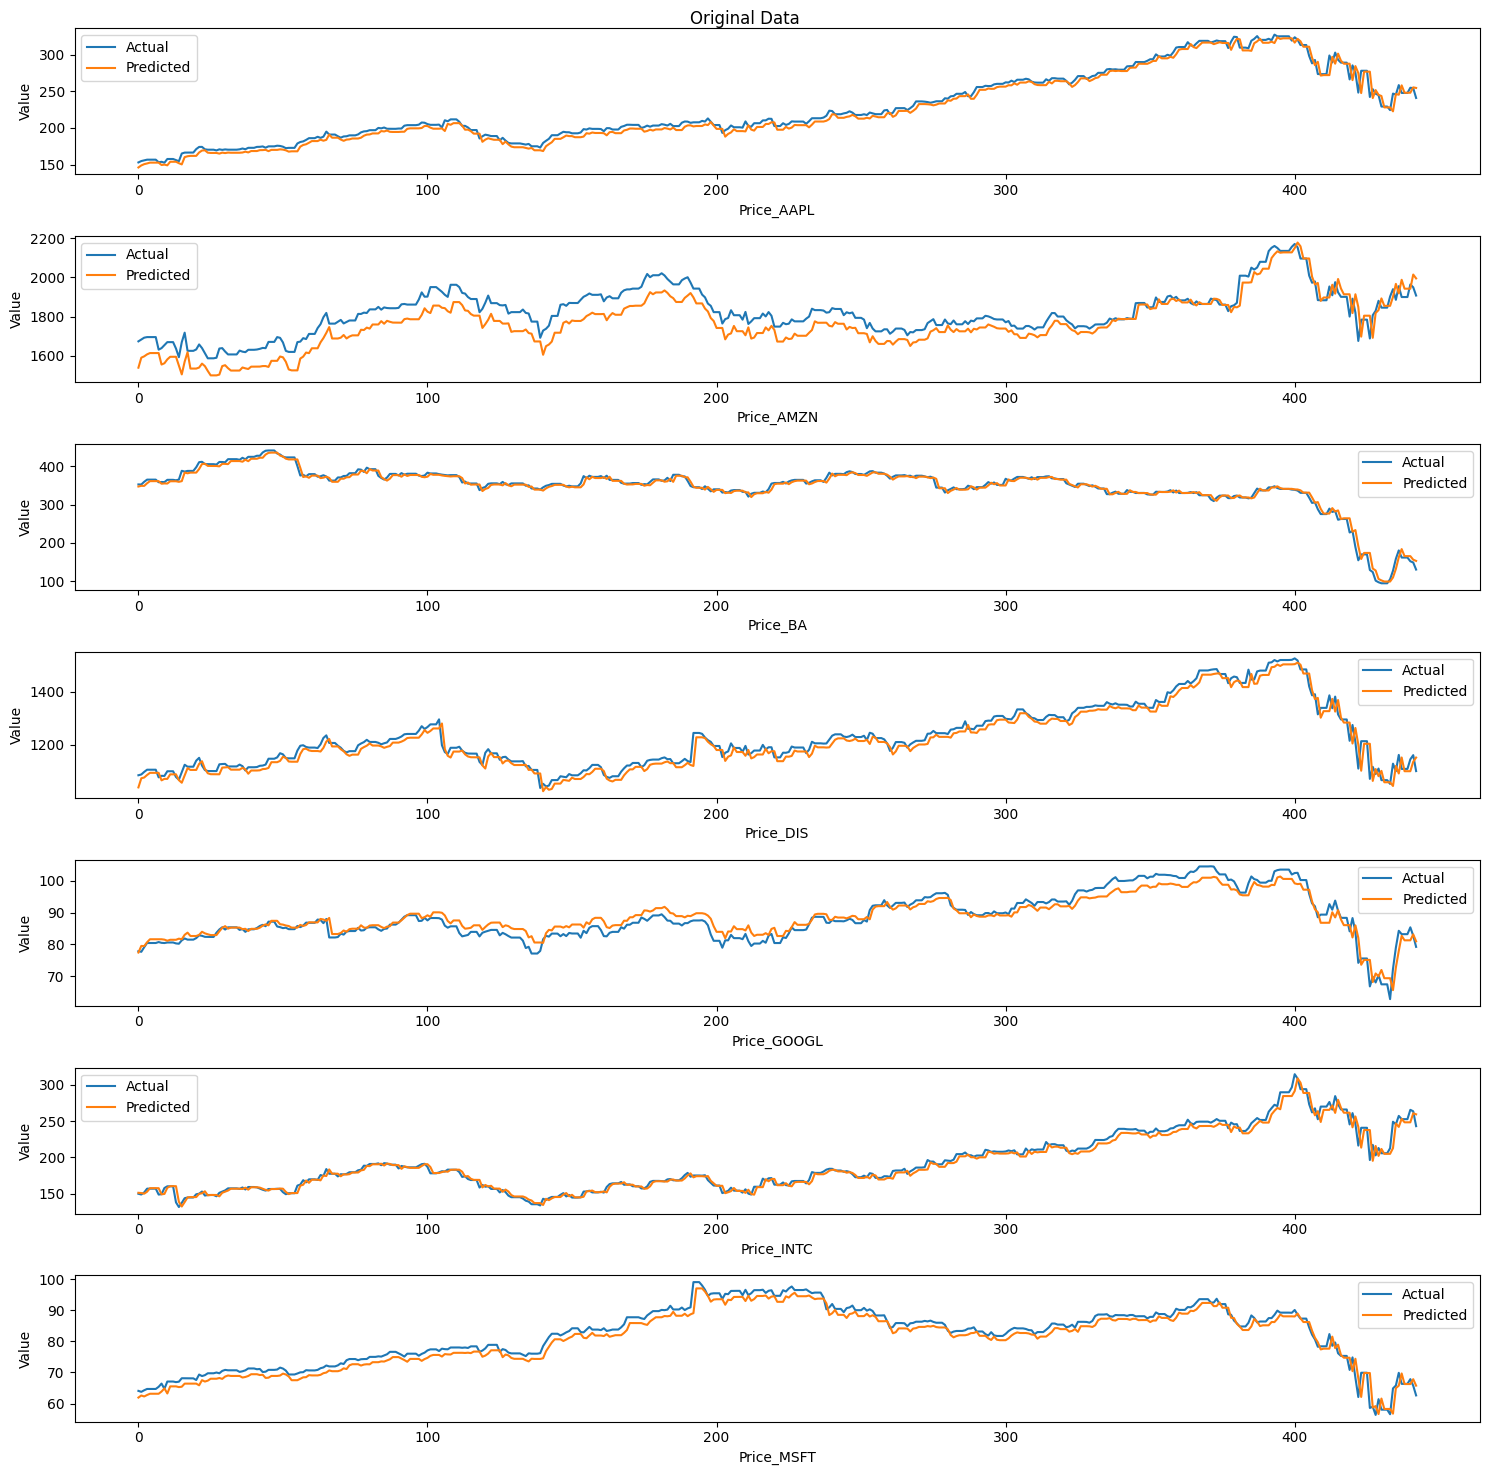

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(n_features):
    plt.subplot(n_features, 1, i+1)
    plt.plot(originY[:, i], label='Actual')
    plt.plot(unscaled_SrVAR[:, i], label='Predicted')
    plt.title('')
    plt.xlabel(f'{scaled_test.columns[i]}')
    plt.ylabel('Value')
    plt.legend()
    
plt.suptitle('Original Data')
plt.tight_layout()
plt.show()

In [ ]:
torch.save(trained_model_SrVAR.state_dict(), "srvar_model.pth")